This notebook can be run to analyze the alleleome from the pre-existing build (or a new build generated if you choose to run the `0__build_alleleome` notebook)

# Import Packages

In [52]:
# built-in packages
from collections import Counter
import gzip
import os
from pathlib import Path
import pickle
import re
import sys

# third-party packages
from Bio.Seq import Seq
from Bio.SeqUtils import GC
import logomaker as logo
import matplotlib.patches as plt_patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import squareform
from scipy.stats import chisquare, f_oneway, mannwhitneyu, spearmanr
from sklearn.metrics import silhouette_samples
from statsmodels.stats.multitest import fdrcorrection  
import seaborn as sns

# import local bitome2
sys.path.append('bitome2')
from bitome.core import Bitome

# Set Paths

This will set paths on your local machine that this workflow needs to be aware of - see comments in this cell to understand which folders you need to create

This MUST be aware of paths set in `0__build_allelome` if you chose to run that notebook first

In [55]:
# overall general data directory
DATA_DIR = Path('data/')

# this contains tables used to generate the bitome object
BITOME_DATA_PATH = Path(DATA_DIR, 'bitome')

# this path contains alignments (you should un-zip the `upstream_alignments.zip` file that comes with this repository
# to ensure this directory exists)
ALIGN_RESULT_PATH = Path(DATA_DIR, 'upstream_alignments')

# path where all figures will be stored
FIG_PATH = Path('figures/')

In [ ]:


PANGENOME_DIR = Path(LARGE_DATA_DIR, 'pangenome')
# this will store files used for phylogrouping the strains
PHYLOGROUPING_DIR = Path(LARGE_DATA_DIR, 'phylogrouping')
# this will store files related to the coding pangenome
CODING_PANGENOME_DIR = Path(LARGE_DATA_DIR, 'cds_pangenome')
# this directory will store blast results organized by reference feature
BLAST_BY_UPSTREAM_REGION_DIR = Path(LARGE_DATA_DIR, 'blast_by_upstream_region')
# this will store ALE mutation files
ALE_DIR = Path(LARGE_DATA_DIR, 'ale')



# this path will contain the input FASTA files from the reference organism for blasting
BLAST_INPUT_DIR = Path(DATA_DIR, 'blast_input')

# this path will be used to write temporary files for alignment with MUSCLE
# allowing us to collapse duplicate alleles
ALIGN_TEMP_DIR = Path(DATA_DIR, 'align_tmp')

In [2]:
BVBRC_DATA_DIR = Path('../data/bv-brc/')
BITOME_DATA_PATH = Path('../data/bitome2/mg1655')
LARGE_DATA_DIR = Path('/Users/cam/Projects/large_data/')
PANGENOME_DIR = Path(LARGE_DATA_DIR, 'pangenome')
PANGENOME_OUT_DIR = Path('../data/pangenome_output/')
BLAST_DIR = Path(PANGENOME_OUT_DIR, 'blast')
MG1655_BLAST_DIR = Path(BLAST_DIR, 'mg1655')
MG_PANGENOME_BLAST_RESULT_DIR = Path(LARGE_DATA_DIR, 'mg_pangenome_blast')
ALE_DIR = Path('../data/ale/')
FIG_PATH = Path('figures/')

# COG Lookup

Define a lookup with shortened names for COG labeling from COG codes that we can use in a couple of places

In [4]:
cog_name_lookup = {
    'J': 'Translation',
    'A': 'RNA processing',
    'K': 'Transcription',
    'L': 'Replication/recombination',
    'B': 'Chromatin',
    'D': 'Cell cycle',
    'Y': 'Nuclear structure',
    'V': 'Defense mechanisms',
    'T': 'Signal transduction',
    'M': 'Cell wall/membrane/envelope',
    'N': 'Cell motility',
    'Z': 'Cytoskeleton',
    'W': 'Extracellular structures',
    'U': 'Intracellular trafficking',
    'O': 'Posttranslational modification',
    'X': 'Mobilome: prophages, transposons',
    'C': 'Energy production and conversion',
    'G': 'Carbohydrate transport and metabolism',
    'E': 'Amino acid transport and metabolism',
    'F': 'Nucleotide transport and metabolism',
    'H': 'Coenzyme transport and metabolism',
    'I': 'Lipid transport and metabolism',
    'P': 'Inorganic ion transport and metabolism',
    'Q': 'Secondary metabolites biosynthesis',
    'R': 'General function prediction only',
    'S': 'Function unknown'
}

# Load Required Information

Load a series of tables/metadata needed to define and interact with the alleleome

Most of these were assembled in `0__build_alleleome` notebook; that does _not_ necessarily need to be run to execute this notebook as-is

## Genome Metadata

In [8]:
valid_genome_md = pd.read_csv(Path(DATA_DIR, 'valid_genome_md.csv'), index_col=0, dtype='object')
# make sure float issue isn't happening (BV-BRC genome IDs sometimes look like floats, which cuts off trailing 0s)
assert valid_genome_md['genome_id'].dtype == 'O'
valid_genome_md.head()

,Genome Name,Other Names,NCBI Taxon ID,Taxon Lineage IDs,Taxon Lineage Names,Superkingdom,Kingdom,Phylum,Class,Order,...,Other Clinical,Additional Metadata,Comments,Date Inserted,Date Modified,phylogroup,genome_id,faa,fna,gff
0,Escherichia coli strain PigCaeca_2,NaN,562,131567;2;1224;1236;91347;543;561;562,cellular organisms;Bacteria;Proteobacteria;Gam...,Bacteria,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,...,NaN,sample_type:Single colony culture,In this pilot study we used shotgun metagenomi...,2019-07-14T17:53:39.077Z,2019-07-14T17:53:39.077Z,A,562.46071,/Users/cam/Projects/large_data/pangenome/562.4...,/Users/cam/Projects/large_data/pangenome/562.4...,/Users/cam/Projects/large_data/pangenome/562.4...
1,Escherichia coli strain RIVM_C029033,NaN,562,131567;2;1224;1236;91347;543;561;562,cellular organisms;Bacteria;Proteobacteria;Gam...,Bacteria,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,...,NaN,sample_type:chromosome,OXA-48-type of carbapenem hydrolyzing enzymes ...,2021-02-27T16:09:51.172Z,2021-02-27T16:09:51.172Z,D,562.70513,/Users/cam/Projects/large_data/pangenome/562.7...,/Users/cam/Projects/large_data/pangenome/562.7...,/Users/cam/Projects/large_data/pangenome/562.7...
2,Escherichia coli strain L5_E1779_ETEC,NaN,562,131567;2;1224;1236;91347;543;561;562,cellular organisms;Bacteria;Proteobacteria;Gam...,Bacteria,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,...,NaN,NaN,Long-read-sequenced reference genomes of the s...,2020-12-01T01:59:20.766Z,2020-12-01T01:59:20.766Z,B1,562.67796,/Users/cam/Projects/large_data/pangenome/562.6...,/Users/cam/Projects/large_data/pangenome/562.6...,/Users/cam/Projects/large_data/pangenome/562.6...
3,Escherichia coli O157:H7 strain 380-94,NaN,83334,131567;2;1224;1236;91347;543;561;562;83334,cellular organisms;Bacteria;Proteobacteria;Gam...,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Enterobacterales,...,NaN,sample_type:bacteria;collected_by:CDC,"The project goals are to study DNA sequence, t...",2022-10-04T12:12:37.421Z,2022-10-04T12:12:37.421Z,E,83334.637,/Users/cam/Projects/large_data/pangenome/83334...,/Users/cam/Projects/large_data/pangenome/83334...,/Users/cam/Projects/large_data/pangenome/83334...
4,Escherichia coli EC6868,NaN,562,131567;2;1224;1236;91347;543;561;562,cellular organisms;Bacteria;Proteobacteria;Gam...,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Enterobacterales,...,NaN,collected_by:Zhuhai People's Hospital,NaN,2022-04-26T18:10:20.767Z,2022-04-26T18:10:20.767Z,D,562.102351,/Users/cam/Projects/large_data/pangenome/562.1...,/Users/cam/Projects/large_data/pangenome/562.1...,/Users/cam/Projects/large_data/pangenome/562.1...


## ALE SNPs

In [38]:
ale_muts_df = pd.read_csv(Path(DATA_DIR, 'mutations_curated.csv'), index_col=0)
ale_muts_df.head()

,exp,ale,flask,isolate,tech_rep,presence,Position,Mutation Type,Sequence Change,Details,Gene,Reference Seq,sample,exp ALE,coding
ale_82393,42C,1,124,1,1,1.00/0.00,702352,DEL,Δ21 bp,coding (380‑400/1149 nt),nagA,NC_000913,1 124 1 1,42C 1,True
ale_82394,42C,1,124,1,1,1.00/0.00,1308318,SNP,G→C,R110G (CGT→GGT),clsA,NC_000913,1 124 1 1,42C 1,True
ale_82392,42C,1,124,1,1,1.00/0.00,2173364,DEL,Δ1 bp,intergenic (‑2/+1),gatC/gatC,NC_000913,1 124 1 1,42C 1,False
ale_82395,42C,1,124,1,1,1.00/0.00,3815859,DEL,Δ82 bp,NaN,rph,NC_000913,1 124 1 1,42C 1,True
ale_82396,42C,1,124,1,1,1.00/0.00,4187550,SNP,C→T,A734V (GCG→GTG),rpoC,NC_000913,1 124 1 1,42C 1,True


## Base-pair Resolution Variation Info

In [39]:
base_pair_df = pd.read_csv(Path(DATA_DIR, 'alleleome_base_pairs.csv.tar.gz'), index_col=0)

in_bool_cols = [col for col in base_pair_df.columns if 'bool' in col]

bool_col_to_nice_name = {
    'in_rbs_bool': 'RBS',
    'in_b10_bool': '-10 Box',
    'in_b35_bool': '-35 Box',
    'in_tss_bool': 'TSS',
    'in_cre_bool': 'CRE',
    'in_spacer_bool': 'Spacer',
    'in_gene_bool': 'Coding',
    'in_ale_mut_bool': 'ALE',
    'in_nothing_bool': 'None',
    'in_tfbs_bool': 'TFBS',
    'in_nothing_bool': 'Nothing',
    'in_atten_bool': 'Atten'
}
nice_to_bool = {v: k for k, v in bool_col_to_nice_name.items()}

left_to_right = ['TFBS', '-35 Box', 'Spacer', '-10 Box', 'TSS', 'Atten', 'ALE', 'Nothing', 'RBS', 'Coding']

assert set(in_bool_cols) - set(bool_col_to_nice_name.keys()) == set()

base_pair_df.head()

,feat_id,tss_id,gene_id,gene_name,strand,align_idx,mg_rel_pos,mg_abs_coord,mg_base,num_seqs,...,C_pct,T_pct,G_pct,-_pct,dominant_pct,variant_pct,in_nothing_bool,essential,tpm_median_cat,tpm_mad_cat
0,TSS_2460979_r__b2343__5utr,TSS_2460979_r,b2343,yfcZ,-1,0,-245,2461179,G,2346,...,0.0,0.0,90.537084,9.462916,90.537084,9.462916,True,False,Medium,High
1,TSS_2460979_r__b2343__5utr,TSS_2460979_r,b2343,yfcZ,-1,1,-244,2461178,G,2346,...,0.0,0.0,99.019608,0.980392,99.019608,0.980392,True,False,Medium,High
2,TSS_2460979_r__b2343__5utr,TSS_2460979_r,b2343,yfcZ,-1,2,-243,2461177,A,2346,...,0.0,0.0,5.583973,0.042626,94.373402,5.626598,True,False,Medium,High
3,TSS_2460979_r__b2343__5utr,TSS_2460979_r,b2343,yfcZ,-1,3,-242,2461176,A,2346,...,0.0,0.0,0.042626,0.000000,99.957374,0.042626,True,False,Medium,High
4,TSS_2460979_r__b2343__5utr,TSS_2460979_r,b2343,yfcZ,-1,4,-241,2461175,T,2346,...,0.0,100.0,0.000000,0.000000,100.000000,0.000000,True,False,Medium,High


## Genome to Allele Lookup

This is useful for phylogenetic analyses

In [53]:
with gzip.open(Path(DATA_DIR, 'genome_id_to_alleles.pickle.gz'), 'rb') as f:
    genome_id_to_alleles = pickle.load(f)

## Alignment Results

This will require you to have already un-zipped the `upstream_alignments.zip` folder that came with this repository

In [60]:
feat_id_to_align_df = {}
feat_id_to_full_result_df = {}

progress_len = len(os.listdir(ALIGN_RESULT_PATH))
for i, align_file in enumerate(os.listdir(ALIGN_RESULT_PATH)):
    
    # this helps us make sure we're looking at pairs of files that go together
    if 'align' not in align_file:
        continue
    
    print(f"{(i+1)//2}/{progress_len // 2}", end='\r')
    
    feat_id = align_file.split('.')[0].split('_align')[0]

    align_result_df = pd.read_csv(Path(ALIGN_RESULT_PATH, align_file), index_col=0)
    full_result_df = pd.read_csv(Path(ALIGN_RESULT_PATH, align_file.replace('_align', '')), index_col=0)

    feat_id_to_align_df[feat_id] = align_result_df
    feat_id_to_full_result_df[feat_id] = full_result_df
    
feat_ids_to_use = list(feat_id_to_align_df.keys())

## Bitome Object

In [13]:
# origin from GenBank annotation
# terminus from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
mg1655 = Bitome(
    Path(BITOME_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=(3925743, 3925975), terminus=(1341745, 1609180),
    gene_table=Path(BITOME_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(BITOME_DATA_PATH, 'tu.csv'),
    operon_table=Path(BITOME_DATA_PATH, 'operon.csv'),
    tss_table=Path(BITOME_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(BITOME_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(BITOME_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(BITOME_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(BITOME_DATA_PATH, 'rbs.csv')
)

## TSS Table and Regulatory Interactions

In [76]:
bitome_mg1655_tss_df = pd.read_csv(Path(BITOME_DATA_PATH, 'tss_combined.csv'), index_col=0)
# add in a column we don't have yet - FIRST gene
def get_first_gene(row):
    gene_ids = row['gene_ids']
    tss_gene_df = mg1655.gene_table.loc[row['gene_ids'].split(';')]
    strand = row['strand']
    def dist_to_tss(gene_row):
        if strand == 1:
            return gene_row['left'] - row['tss']
        else:
            return row['tss'] - gene_row['right']
    tss_gene_df = tss_gene_df.assign(
        tss_dist=tss_gene_df.apply(dist_to_tss, axis=1)
    )
    tss_gene_df = tss_gene_df.sort_values(by='tss_dist')
    closest_gene_row = tss_gene_df.iloc[0]
    closest_gene_id = closest_gene_row.name
    return closest_gene_id
with_genes = bitome_mg1655_tss_df[bitome_mg1655_tss_df['gene_ids'].notna()]
with_genes = with_genes.assign(
    first_gene_id=with_genes.apply(get_first_gene, axis=1)
)
bitome_mg1655_tss_df.head()

,tss,strand,tss_base,promoter_id,tu_id,tu_name,gene_ids,gene_names,n_genes,tu_left,...,Sigma32_box_35_score,Sigma28_box_10_score,Sigma28_box_35_score,Sigma24_box_10_score,Sigma24_box_35_score,box_10_seq,box_35_seq,spacer_len,spacer_gc,replication_region
tss_recon_id,,,,,,,,,,,,,,,,,,,,,
TSS_1832013_r,1832013,-1,A,ECK120009851,ECK120008913,astCADBE,b1744;b1745;b1746;b1747;b1748,astE;astB;astD;astA;astC,5,1825955.0,...,-inf,NaN,NaN,NaN,-0.763211,TATTAT,CTACAT,0.0,NaN,leading
TSS_1832044_r,1832044,-1,A,ECK120009852,ECK120008914,astCADBE,b1744;b1745;b1746;b1747;b1748,astE;astB;astD;astA;astC,5,1825955.0,...,0.910541,NaN,NaN,-0.447979,-10.391454,TGCAA,TGGCAC,0.0,NaN,leading
TSS_1832039_r,1832039,-1,G,ECK120009853,ECK120008915,astCADBE,b1744;b1745;b1746;b1747;b1748,astE;astB;astD;astA;astC,5,1825955.0,...,-3.223795,NaN,NaN,NaN,-10.004002,CAATCTACATT,CTGGCT,0.0,NaN,leading
TSS_2800656_f,2800656,1,A,ECK120009855,ECK120008916,nrdHIEF,b2673;b2674;b2675;b2676,nrdH;nrdI;nrdE;nrdF,4,2800656.0,...,7.898709,NaN,NaN,NaN,-10.351926,TAGTAT,TTGAAT,0.0,NaN,lagging
TSS_4105785_f,4105785,1,G,ECK120010879,ECK120008917,cpxPQ,b4484,cpxP,1,4105785.0,...,0.464915,NaN,NaN,NaN,-10.821138,TAAACT,CTGACG,0.0,NaN,leading


In [15]:
ri_df = pd.read_csv(Path(BITOME_DATA_PATH, 'regulatory_interaction.csv'), index_col=0)
ri_df.head()

,REGULATORY_INTERACTION_ID,CONFORMATION_ID,PROMOTER_ID,SITE_ID,RI_FUNCTION,CENTER_POSITION,RI_DIST_FIRST_GENE,RI_FIRST_GENE_ID,REGULATORY_INTERACTION_NOTE,RI_SEQUENCE,...,SITE_NOTE,SITE_LENGTH,SITE_ABSOLUTE_CENTER_POSITION,SITE_SEQUENCE_REVERSE_COMPLEMENT,TF_ID,T_FACTOR_ID,T_FACTOR_NAME,T_FACTOR_SITE_LENGTH,T_FACTOR_KEY_ID_ORG,T_FACTOR_SITE_GROUP
0,ECK120030767,ECK125269234,ECK120010130,ECK120012046,activator,-61.5,-99.5,ECK120000520,The CRP-binding site controlling the <i>lacZ</...,gcaacgcaatTAATGTGAGTTAGCTCACTCATtaggcacccc,...,NaN,22.0,366404.5,gcaacgcaatTAATGTGAGTTAGCTCACTCATtaggcacccc,29,ECK120011235,CRP,22,ECK12,291
1,ECK120030768,ECK125269282,ECK120010108,ECK120012328,activator,-64.0,-91.0,ECK120000049,NaN,tgctatgccaTAGCATTTTTATCCATAagattagcgg,...,NaN,17.0,70139.0,tgctatgccaTAGCATTTTTATCCATAagattagcgg,14,ECK120012316,AraC,17,ECK12,16
2,ECK120030769,ECK125269395,ECK120010108,ECK120012328,repressor,-64.0,-91.0,ECK120000049,NaN,tgctatgccaTAGCATTTTTATCCATAagattagcgg,...,NaN,17.0,70139.0,tgctatgccaTAGCATTTTTATCCATAagattagcgg,14,ECK120012316,AraC,17,ECK12,16
3,ECK120030770,ECK125269282,ECK120010988,ECK120012328,activator,-84.0,-248.0,ECK120000050,NaN,ccgctaatctTATGGATAAAAATGCTAtggcatagca,...,NaN,17.0,70139.0,tgctatgccaTAGCATTTTTATCCATAagattagcgg,14,ECK120012316,AraC,17,ECK12,16
4,ECK120030771,ECK125269395,ECK120010988,ECK120012328,repressor,-84.0,-248.0,ECK120000050,NaN,ccgctaatctTATGGATAAAAATGCTAtggcatagca,...,NaN,17.0,70139.0,tgctatgccaTAGCATTTTTATCCATAagattagcgg,14,ECK120012316,AraC,17,ECK12,16


## PRECISE-1K IcaData

In [17]:
p1k = load_json_model(Path(DATA_DIR, 'precise1k.json.gz').as_posix())

# Summary of Dataset

## By the Numbers

2350 strains
418549 alignment base pairs
371571 unique K-12 positions
1169 regions
Coding % of Seq: 89.1
Noncoding % of Seq: 10.9
This analysis % of Seq: 8.0
This analysis % of Coding: 4.6
This analysis % of noncoding: 35.7
113 RBS
1188 -10 Box
1122 -35 Box
1739 TSS
1739 CRE
1123 Spacer
1620 Coding
1017 ALE
1908 TFBS
287 Atten
1975 genes transcribed
RBS: 63.1
Atten: 38.2
TSS: 84.3
-10 Box: 79.6
Spacer: 80.8
-35 Box: 80.8
TFBS: 63.7


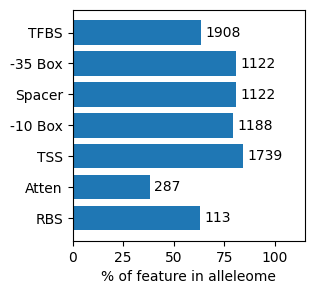

In [42]:
print(f"{valid_genome_md.shape[0]} strains")

print(f'{base_pair_df.shape[0]} alignment base pairs')

print(f"{base_pair_df['mg_abs_coord'].nunique()} unique K-12 positions")

print(f"{base_pair_df['feat_id'].nunique()} regions")

n_unique_k12_pos = base_pair_df['mg_abs_coord'].nunique()
n_non_coding_k12_pos = base_pair_df[~base_pair_df['in_gene_bool']]['mg_abs_coord'].nunique()
n_coding_k12_pos = n_unique_k12_pos - n_non_coding_k12_pos

all_gene_pos = []

for _, gene_row in mg1655.gene_table.iterrows():
    gene_l, gene_r = gene_row[['left', 'right']]
    if pd.notna(gene_l) and pd.notna(gene_r):
        all_gene_pos.extend(list(range(gene_l, gene_r + 1)))
        
n_coding_pos_total = len(set(all_gene_pos))
n_noncoding_pos_total = len(set(list(range(1, mg1655.seq_length + 1))) - set(all_gene_pos))

print(f'Coding % of Seq: {n_coding_pos_total / mg1655.seq_length * 100:.1f}')
print(f'Noncoding % of Seq: {n_noncoding_pos_total / mg1655.seq_length * 100:.1f}')

print(f'This analysis % of Seq: {n_unique_k12_pos / mg1655.seq_length * 100:.1f}')
print(f'This analysis % of Coding: {n_coding_k12_pos / n_coding_pos_total * 100:.1f}')
print(f'This analysis % of noncoding: {n_non_coding_k12_pos / n_noncoding_pos_total * 100:.1f}')

bitome_total = {
    'RBS': mg1655.rbs_table.shape[0],
    'Atten': mg1655.attenuator_table.shape[0],
    'TSS': mg1655.tu_table['tss'].nunique(),
    '-10 Box': mg1655.tu_table[['box_10_left', 'box_10_right', 'strand']].dropna(how='any').drop_duplicates().shape[0],
    'Spacer': mg1655.tu_table[['box_35_left', 'box_35_right', 'strand']].dropna(how='any').drop_duplicates().shape[0],
    '-35 Box': mg1655.tu_table[['box_35_left', 'box_35_right', 'strand']].dropna(how='any').drop_duplicates().shape[0],
    'TFBS': ri_df['SITE_ID'].nunique()
}
nice_name_to_n_covered = {}
for bool_col, nice_name in bool_col_to_nice_name.items():
    if bool_col == 'in_nothing_bool':
        continue
    non_bool_col = bool_col.replace('_bool', '')
    nice_name_df = base_pair_df[base_pair_df[bool_col]]
    raw_name_col = nice_name_df[non_bool_col].unique()
    final_names = []
    for raw in raw_name_col:
        final_names.extend(raw.split(';'))
    final_names = list(set(final_names))
    if bool_col == 'in_tss_bool':
        all_tss_covered = final_names[:]
    print(f'{len(final_names)} {nice_name}')
    nice_name_to_n_covered[nice_name] = len(final_names)
nice_name_to_n_covered['Spacer'] -= 1
    
genes_from_tsses = []
for tss_id in all_tss_covered:
    tss_gene_ids_raw = bitome_mg1655_tss_df.loc[tss_id]['gene_ids']
    if pd.notna(tss_gene_ids_raw):
        genes_from_tsses.extend(tss_gene_ids_raw.split(';'))
        
genes_from_tsses = list(set(genes_from_tsses))
print(f'{len(genes_from_tsses)} genes transcribed')
nice_name_to_n_covered['Coding'] = len(genes_from_tsses)

_, ax = plt.subplots(figsize=(3, 3))

for i, (nice_name, bitome_tot) in enumerate(bitome_total.items()):
    pct = (nice_name_to_n_covered[nice_name] / bitome_tot) * 100
    print(f'{nice_name}: {pct:.1f}')
    ax.barh(i, pct, color='tab:blue')
    ax.text(pct+2, i, nice_name_to_n_covered[nice_name], va='center')

ax.set_yticks(range(len(bitome_total)))
ax.set_yticklabels(bitome_total.keys())
ax.set_xlim(0, 115)
ax.set_xticks(np.arange(0, 125, 25))
ax.set_xlabel('% of feature in alleleome')

plt.savefig(Path(FIG_PATH, f'bitome_feat_nums.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'bitome_feat_nums.png'), dpi = 600, bbox_inches = 'tight')

## Isolation Source

In [43]:
source_only = valid_genome_md.copy()
source_only = source_only.assign(
    host_common_name=source_only['Host Common Name'].apply(lambda hcn: {'Poultry': 'Chicken', 'Null': np.nan}.get(hcn, hcn))
)

remap = {
    'rectal swab from healthy college student': 'rectal swab',
    'Rectal swab': 'rectal swab',
    'human stool': 'stool',
    'Stool': 'stool',
    'feces': 'stool',
    'human stool': 'stool',
    'Human feces': 'stool',
    'feces from healthy individual': 'stool',
    'fecal sample': 'stool',
    'Urine': 'urine',
    'faecal sample': 'stool',
    'Clinical: Human (Homo sapiens)': np.nan,
    'Human': np.nan,
    'Clinical': np.nan,
    'patient blood': 'blood',
    'hospital': np.nan,
    'Chronic wound': 'wound',
    'patients and hospital environment': np.nan,
    'urine from healthy adult with cystitis': 'urine',
    'urine; urinary tract infection': 'urine',
    'faeces': 'stool',
    'rectal swab from HIV infected patient': 'rectal swab',
    'Rectal Swab': 'rectal swab',
    'Diarrheal stool': 'stool',
    'Healthy human (stool)': 'stool',
    'Human Stool': 'stool',
    'Pork': np.nan,
    'Swab from Wound': 'wound',
    'Urine sample': 'urine',
    'Rectal': 'rectal swab',
    'Blood culture': 'blood',
    'stool sample': 'stool',
    'Japanese patient with no history of travel abroad, we performed whole-genome sequencing using the illumina MiSeq and the Oxford Nanopore Technologies MinION': np.nan,
    'woman with uncomplicated cystitis (bladder inflammation) that has been demonstrated to cause cystitis': np.nan,
    'Clinical sample: urine': 'urine',
    'urine, catheter urine': 'urine',
    'fecal sample from patient': 'stool',
    'human feces': 'stool',
    'Rectal swab of patient hospitalized for an unrelated disease': 'rectal swab',
    'rectal swab from neonate': 'rectal swab',
    'Rectum': 'rectal swab',
    'Stool sample': 'stool',
    'adult female': np.nan,
    'clinical isolate': np.nan,
    'feces; clinical sample': 'stool',
    'infant with diarrhea': 'stool',
    'stool sample from a 64-year-old woman from Hamburg who presented with bloody diarrhea and did not develop hemolytic uremic syndrome (HUS)': np.nan,
    'Sanger Centre via Imperial College': np.nan,
    "patient with Crohn's disease": np.nan,
    'Infant diarrheic stool': 'stool',
    'vaginal swab': 'vaginal secretion',
    'Vaginal secretion': 'vaginal secretion',
    '5 Bangladeshi children with diarrhea': np.nan,
    'Pus': 'pus',
    'Artificial construct derived from EPEC E2348/69 variety 2': np.nan,
    'three burns patients': np.nan,
    'urine pellicle': 'urine',
    'Anal swab': 'rectal swab',
    'secretion': np.nan,
    'Manawatu river': np.nan,
    'laboratory mutant of 6535': np.nan,
    'patient with acute pyelonephritis (inflammation of the kidney and pelvis)': np.nan,
    'rectal swab from college student': 'rectal swab',
    'blood draw same patient as MB9267': 'blood',
    'Child feces': 'stool',
    'urinary catheter': 'catheter',
    'outbreaks of food poisoning': np.nan,
    'rectum': 'rectal swab',
    'diarrhea from outbreaks of food poisoning': 'stool',
    'Hospital Universitari Germans Trias i Pujol (Badalona)': np.nan,
    'bladder epithelial biopsy from 30-year-old female patient with recurrent urinary tract infection': 'bladder epithelium',
    'Biopsy of human bladder epithelium': 'bladder epithelium',
    'location throughout The Netherlands': np.nan,
    'adult': np.nan,
    'human, urinary tract infection': 'urinary tract',
    'persons infected with HNoV': np.nan,
    'Flour': np.nan,
    'Skin swab': 'skin',
    'bile duct discharge': 'bile',
    'Pelvic abcsess': 'pelvic abscess',
    'Respiratory secretions': 'respiratory tract',
    'upper respiratory tract': 'respiratory tract',
    'lower respiratory tract': 'respiratory tract',
    'perirectal swab': 'rectal swab',
    'human feces of different individuals': 'stool',
    'Human gut': 'gut',
    'cerebrospinal fluid': 'CSF',
    'Hospital Universitario Son de Espases (Palma de Mallorca)': np.nan,
    'Urine cathether': 'catheter',
    'urethral catheter': 'catheter',
    'Peritoneal fluid': 'peritoneal fluid',
    'Fecal sample': 'stool',
    'Stool specimen': 'stool',
    'rectal swab of 45 year old man with liver cirrhosis returning from Russia': 'rectal swab',
    'Human intestinal microflora': 'gut',
    'Chicken meat': np.nan,
    'urinary': 'urinary tract',
    'cerebrospinal fluid from newborn infant': 'CSF',
    'ascites': 'ascitic fluid',
    'Feces, human': 'stool',
    'outbreak': np.nan,
    'child': np.nan,
    'colonoscopy': 'gut',
    'throat swab': 'throat',
    'abdominal drainage': 'ascitic fluid'
}

hum_only = source_only[source_only['host_common_name'] == 'Human']
hum_only = hum_only.assign(
    iso_source=hum_only['Isolation Source'].apply(lambda isosrc: {'rectal swab': 'rectal'}.get(remap.get(isosrc, isosrc), remap.get(isosrc, isosrc)))
)

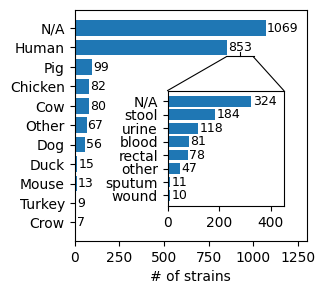

In [44]:
cutoff = 9
source_to_count = source_only['host_common_name'].value_counts()
other = 0
for count in source_to_count.iloc[cutoff:]:
    other += count
source_to_count = source_to_count.iloc[:cutoff]
source_to_count.loc['Other'] = other
source_to_count.loc['N/A'] = source_only['host_common_name'].isna().sum()
source_to_count = source_to_count.sort_values(ascending=False)

_, ax = plt.subplots(figsize=(3, 3))

for i, (src, count) in enumerate(list(source_to_count.items())[::-1]):
    ax.barh(i, count, color='tab:blue')
    ax.text(count + 5, i, count, fontsize=9, va='center')
    
ax.set_yticks(range(len(source_to_count)))
ax.set_yticklabels(list(source_to_count.keys())[::-1])
ax.set_xlim(0, 1300)
ax.set_xticks(range(0, 1300, 250))

ax.set_ylabel('')
ax.set_xlabel('# of strains')

ax_in = ax.inset_axes([0.4, 0.15, 0.5, 0.5])
ax.plot([0.4, 0.65], [0.65, 0.795], transform=ax.transAxes, color='k', lw=0.8)
ax.plot([0.77, 0.9], [0.795, 0.65], transform=ax.transAxes, color='k', lw=0.8)
ax.plot([0.65, 0.77], [0.8, 0.8], transform=ax.transAxes, color='k', lw=0.8)
ax.plot([0.71, 0.71], [0.8, 0.815], transform=ax.transAxes, color='k', lw=0.8)

cutoff = 6
poop_to_count = hum_only['iso_source'].value_counts()
other = 0
for count in poop_to_count.iloc[cutoff:]:
    other += count
poop_to_count = poop_to_count.iloc[:cutoff]
poop_to_count.loc['other'] = other
poop_to_count.loc['N/A'] = hum_only['iso_source'].isna().sum()
poop_to_count = poop_to_count.sort_values(ascending=False)

for i, (poop, count) in enumerate(list(poop_to_count.items())[::-1]):
    ax_in.barh(i, count, color='tab:blue')
    ax_in.text(count + 5, i, count, fontsize=9, va='center')
    
ax_in.set_yticks(range(len(poop_to_count)))
ax_in.set_yticklabels(list(poop_to_count.keys())[::-1])
ax_in.set_xlim(0, 450)
ax_in.set_xticks([0, 200, 400])

plt.savefig(Path(FIG_PATH, f'source_counts.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'source_counts.png'), dpi = 600, bbox_inches = 'tight')

## Phylogroup Distribution

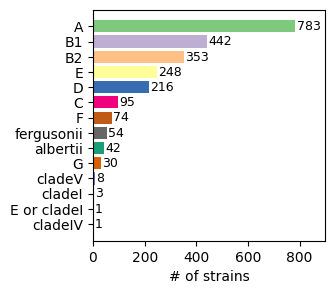

In [45]:
phylo_to_count = valid_genome_md['phylogroup'].value_counts()

phy_to_col = dict(zip(phylo_to_count.keys(), plt.cm.get_cmap('Accent').colors + plt.cm.get_cmap('Dark2').colors))

_, ax = plt.subplots(figsize=(3, 3))

for i, (phy, count) in enumerate(list(phylo_to_count.items())[::-1]):
    ax.barh(i, count, color=phy_to_col[phy])
    ax.text(count + 5, i, count, fontsize=9, va='center')
    
ax.set_yticks(range(len(phylo_to_count)))
ax.set_xlim(0, 900)
ax.set_yticklabels(list(phylo_to_count.keys())[::-1])

ax.set_ylabel('')
ax.set_xlabel('# of strains')

plt.savefig(Path(FIG_PATH, f'phylo_counts.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'phylo_counts.png'), dpi = 600, bbox_inches = 'tight')

## Variant % per bp Histogram

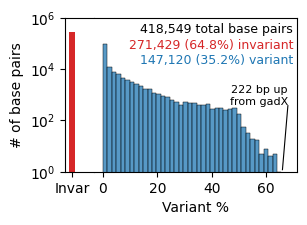

In [46]:
_, (ax_bar, ax) = plt.subplots(1, 2, figsize=(3, 2), width_ratios=[1, 7], sharey=True)

plt.subplots_adjust(wspace=0)

n_total = base_pair_df.shape[0]
n_invariant = base_pair_df[base_pair_df['variant_pct'] == 0].shape[0]
ax_bar.bar(0, n_invariant, color='tab:red')
ax_bar.set_ylim(bottom=1, top=1000000)
ax_bar.set_xticks([0])
ax_bar.set_xticklabels(['Invar'])
ax_bar.set_xlim(-1, 3)
ax_bar.spines['right'].set_visible(False)
ax_bar.set_ylabel('# of base pairs')

var_only = base_pair_df[base_pair_df['variant_pct'] > 0]
sns.histplot(var_only['variant_pct'], ax=ax, bins=40, color='tab:blue')

ax.set_yscale('log')
ax.set_ylabel('# of aligned base pairs')
ax.set_xlabel('Variant %')
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', length=0)

ax.text(0.98, 0.9, f"{n_total:,d} total base pairs", transform=ax.transAxes, fontsize=9, ha='right', color='k')
ax.text(0.98, 0.8, f"{n_invariant:,d} ({n_invariant/n_total*100:.1f}%) invariant", transform=ax.transAxes, fontsize=9, ha='right', color='tab:red')
ax.text(0.98, 0.7, f"{var_only.shape[0]:,d} ({var_only.shape[0]/n_total*100:.1f}%) variant", transform=ax.transAxes, fontsize=9, ha='right', color='tab:blue')

ax.text(68, 400, '222 bp up\nfrom gadX', fontsize=8, ha='right')
ax.plot([68, 66], [375, 1.2], lw=0.8, color='k')

plt.savefig(Path(FIG_PATH, f'variant_pct_all_hist.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'variant_pct_all_hist.png'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'variant_pct_all_hist.pdf'), dpi = 600, bbox_inches = 'tight')

## Alleles per Region

In [62]:
n_alleles = []
allele_lengths = []

for fid_2use in feat_ids_to_use:
    feat_al_df = feat_id_to_align_df[fid_2use]
    n_alleles.append(feat_al_df.shape[0])
    allele_lengths.append(len(feat_al_df['seq_align'].iloc[0]))

### Histogram

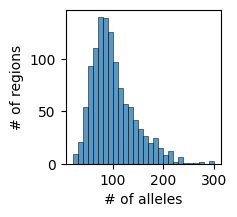

In [63]:
_, ax = plt.subplots(figsize=(2, 2))

sns.histplot(n_alleles, ax=ax)
ax.set_xlabel('# of alleles')
ax.set_ylabel('# of regions')

plt.savefig(Path(FIG_PATH, f'allele_count_hist.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'allele_count_hist.png'), dpi = 600, bbox_inches = 'tight')

### vs Align Length

/Users/cam/.venv/bitome/lib/python3.10/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


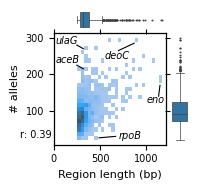

In [64]:
hist_df = pd.DataFrame(data={
    'length': allele_lengths,
    'num_alleles': n_alleles
},index=feat_ids_to_use)

g = sns.JointGrid(data=hist_df, x='length',y='num_alleles',
                  height=1.75, marginal_ticks=False)
g.plot_joint(sns.histplot, color='tab:blue', bins=25)
g.plot_marginals(sns.boxplot, color='tab:blue', fliersize=0.5, linewidth=0.5)

g.ax_joint.set_xlabel('Region length (bp)', fontsize=8)
g.ax_joint.set_ylabel('# alleles', fontsize=8)
g.ax_joint.set_xlim(left=0)
g.ax_joint.set_xticks([0, 500, 1000])
g.ax_joint.tick_params(axis='both', labelsize=7)
for s in g.ax_joint.spines.values():
    s.set_visible(True)
    s.set_color('k')
    s.set_linewidth(0.9)

for s in (list(g.ax_marg_x.spines.values()) + list(g.ax_marg_y.spines.values())):
    s.set_visible(False)

corr, p = spearmanr(hist_df['length'], hist_df['num_alleles'])
g.ax_joint.text(-20, 25, f"r: {corr:.2f}", fontsize=7, ha='right')

g.ax_joint.text(700, 30, f'rpoB', fontstyle='italic', fontsize=7, va='center', ha='left')
g.ax_joint.plot([670, 490], [30, 26], lw=0.8, color='k')

g.ax_joint.text(20, 240, f'aceB', fontstyle='italic', fontsize=7, va='center', ha='left')
g.ax_joint.plot([250, 320], [225, 215], lw=0.8, color='k')

g.ax_joint.text(20, 290, f'ulaG', fontstyle='italic', fontsize=7, va='center', ha='left')
g.ax_joint.plot([250, 320], [280, 270], lw=0.8, color='k')

g.ax_joint.text(550, 250, f'deoC', fontstyle='italic', fontsize=7, va='center', ha='left')
g.ax_joint.plot([700, 870], [265, 285], lw=0.8, color='k')

g.ax_joint.text(1100, 130, f'eno', fontstyle='italic', fontsize=7, va='center', ha='center')
g.ax_joint.plot([1135, 1150], [140, 170], lw=0.8, color='k')

plt.savefig(Path(FIG_PATH, f'align_v_allele_2dhist.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'align_v_allele_2dhist.png'), dpi = 600, bbox_inches = 'tight')

# Phylogenetic Analysis

## Similarity

Custom similarity computation based on sets of shared alleles

In [65]:
all_gids = list(genome_id_to_alleles.keys())

comp_rows = []
for i, gid1 in enumerate(all_gids):
    print(f'{i+1}/{len(all_gids)}', end='\r')
    gid_row = {}
    for j, gid2 in enumerate(all_gids):
        if j > i:
            n_shared = len(genome_id_to_alleles[gid1].intersection(genome_id_to_alleles[gid2]))
            gid_row[gid2] = n_shared
        else:
            gid_row[gid2] = None
    comp_rows.append(gid_row)
    
simil_df = pd.DataFrame(comp_rows, index=all_gids, columns=all_gids)

# add in the diagonal and bottom triangle
simil_df = simil_df.fillna(0)
simil_df = simil_df + simil_df.T
simil_df = simil_df + np.eye(len(all_gids)) * len(feat_ids_to_use)
simil_df = simil_df / len(feat_ids_to_use)

dist_df = 1 - simil_df

## Clustering

Use hierarchical clustering on the distance matrix

### Sensitivity Analysis

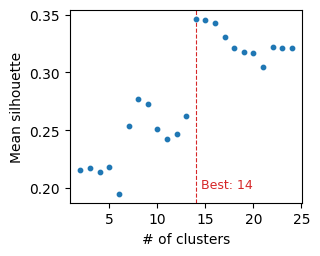

In [66]:
max_clusters_to_try = np.arange(2, 25)
condensed_dist = squareform(dist_df)
link_mat = linkage(condensed_dist, method='average')

sil_score_means = []
for max_clst in max_clusters_to_try:

    clst_row = pd.Series(
        fcluster(link_mat, max_clst, 'maxclust'),
        index=dist_df.index
    )

    sil_scores = silhouette_samples(dist_df, clst_row.values, metric='precomputed')
    sil_score_means.append(np.mean(sil_scores))
    
max_idx = np.argmax(sil_score_means)
best_n_clst = max_clusters_to_try[max_idx]

_, ax = plt.subplots(figsize=(3, 2.5))

ax.scatter(max_clusters_to_try, sil_score_means, color='tab:blue', s=10)
ax.axvline(best_n_clst, linestyle='--', color='tab:red', lw=0.8, zorder=-5)
ax.text(best_n_clst + 0.5, 0.2, f'Best: {best_n_clst}', fontsize=9, color='tab:red')
ax.set_xlabel('# of clusters')
ax.set_ylabel('Mean silhouette')

plt.savefig(Path(FIG_PATH, f'cluster_sensitivity.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'cluster_sensitivity.png'), dpi = 600, bbox_inches = 'tight')

### Clustermap

Re-compute clustering with the best # of clusters

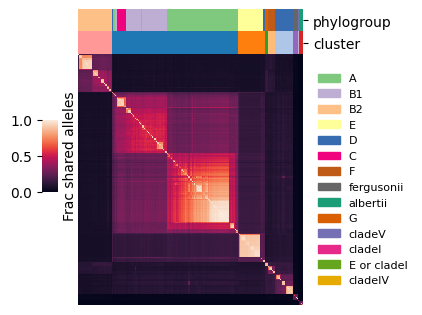

In [67]:
gid_to_phylogroup = dict(zip(valid_genome_md['genome_id'], valid_genome_md['phylogroup']))

clst_df = pd.DataFrame(
    data={
        'cluster': fcluster(link_mat, 14, 'maxclust'),
        'phylogroup': [gid_to_phylogroup[gid] for gid in dist_df.index]
    },
    index=dist_df.index
)

#get colors for each cluster; and also color the phylogroups based on their
# majority color
clst_to_col = dict(zip(clst_df['cluster'].unique(), plt.cm.get_cmap('tab20').colors))
phy_to_count = dict(clst_df['phylogroup'].value_counts())
color_only_df = pd.DataFrame(
    data={
        'phylogroup': clst_df['phylogroup'].map(phy_to_col),
        'cluster': clst_df['cluster'].map(clst_to_col)
    },
    index=clst_df.index
)

cg = sns.clustermap(
    simil_df,
    figsize=(4, 4),
    row_linkage=link_mat,
    col_linkage=link_mat,
    col_colors=color_only_df,
    colors_ratio=0.06,
    xticklabels=False,
    yticklabels=False,
    cbar_kws={'label': 'Frac shared alleles'},
    cbar_pos=(0.0875, 0.32, 0.04, 0.18)
)
cg.ax_row_dendrogram.set_visible(False)
# make a custom legend to list out the phylogroups
legend_stuff = [plt_patches.Patch(color=phy_to_col[phy], label=f'{phy}') for phy, phy_ct in phy_to_count.items()]
cg.ax_heatmap.legend(handles=legend_stuff, bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False, fontsize=8)
cg.ax_cbar.yaxis.set_ticks_position('left')
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_visible(False)

# plt.savefig(Path(FIG_PATH, f'clustermap.svg'), dpi = 300)
# # plt.savefig(Path(FIG_PATH, f'clustermap.png'), dpi = 300, bbox_inches = 'tight')

### Clustering Confusion Matrix

Want to express what fraction of each phylogroup is falling into each cluster

Rows are phylogroups, columns are clusters

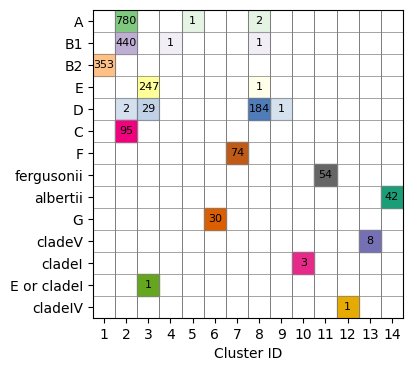

In [68]:
clst_phy_rows = []
phy_idx = []

for phy, phy_df in clst_df.groupby('phylogroup'):
    clst_phy_rows.append(dict(phy_df['cluster'].value_counts()))
    phy_idx.append(phy)
    
clst_phy_df = pd.DataFrame(clst_phy_rows, index=phy_idx)
clst_phy_df = clst_phy_df.fillna(0)
clst_phy_df = clst_phy_df[sorted(clst_phy_df.columns)]
clst_phy_df = clst_phy_df.loc[phy_to_count.keys()]

_, ax = plt.subplots(figsize=(4, 4))

n_rows, n_cols = clst_phy_df.shape
rect_w, rect_h = 1 / n_cols, 1 / n_rows
row_bottoms = []
col_lefts = []
for row_i, phy in enumerate(clst_phy_df.index):
    actual_row_i = n_rows - 1 - row_i
    row_bottom = actual_row_i/n_rows
    row_bottoms.append(row_bottom)
    ax.axhline(row_bottom, color='tab:gray', lw=0.5)
    row_total = clst_phy_df.loc[phy].sum()
    for col_i, clst in enumerate(clst_phy_df.columns):
        col_left = col_i/n_cols
        if row_i == 0:
            col_lefts.append(col_left)
        ax.axvline(col_left, color='tab:gray', lw=0.5)
        val = clst_phy_df.loc[phy, clst]
        patch = plt_patches.Rectangle(
            (col_left, row_bottom), rect_w, rect_h,
            color=phy_to_col[phy], alpha=(0.2 + 0.8 * (val / row_total)) if val > 0 else 0
        )
        ax.add_patch(patch)
        if val > 0:
            ax.text(col_left + rect_w / 2, row_bottom + rect_h / 2, f'{val:.3f}'.replace('.000', ''),
                    ha='center', va='center', fontsize=8)
            
ax.set_yticks(np.array(row_bottoms) + rect_h / 2)
ax.set_yticklabels(clst_phy_df.index)
ax.set_xticks(np.array(col_lefts) + rect_w / 2)
ax.set_xticklabels(clst_phy_df.columns)
ax.set_xlabel('Cluster ID')

plt.savefig(Path(FIG_PATH, f'cluster_conf_mat.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'cluster_conf_mat.png'), dpi = 600, bbox_inches = 'tight')

## Outlier Case Studies

What's up with cluster 4 and 5?

### Weird B1

In [69]:
weird_b1_df = clst_df[(clst_df['phylogroup'] == 'B1') & (clst_df['cluster'] != 2)]
weird_b1_df

,cluster,phylogroup
562.60624,8,B1
562.60446,4,B1


In [70]:
valid_genome_md[valid_genome_md['genome_id'].isin(weird_b1_df.index)][['Genome Name', 'genome_id']]

,Genome Name,genome_id
751,Escherichia coli strain SC457,562.60624
1918,Escherichia coli strain GF4-3,562.60446


In [71]:
weird_b1_lookup = {
    'Cluster 4 (Strain GF4-3)': '562.60446',
    'Cluster 8 (Strain SC457)': '562.60624'
}

other_b1 = list(clst_df[clst_df['phylogroup'] == 'B1'].index)
print(len(other_b1))
other_b1.remove(weird_b1_lookup['Cluster 4 (Strain GF4-3)'])
other_b1.remove(weird_b1_lookup['Cluster 8 (Strain SC457)'])
print(len(other_b1))

442
440


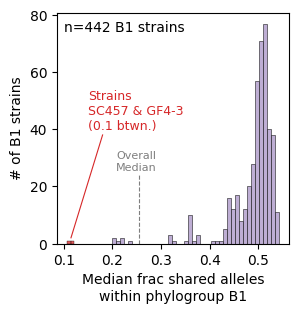

In [72]:
overall_median_simil = simil_df.median().median()

other_sim_medians = simil_df.loc[other_b1, other_b1].median()
weird8_median = simil_df.loc[weird_b1_lookup['Cluster 8 (Strain SC457)'], other_b1].median()
weird4_median = simil_df.loc[weird_b1_lookup['Cluster 4 (Strain GF4-3)'], other_b1].median()

_, ax = plt.subplots(figsize=(3, 3))

sns.histplot(other_sim_medians, ax=ax, color=phy_to_col['B1'], alpha=1)
ax.axvline(overall_median_simil, linestyle='--', color='tab:gray', lw=0.8, zorder=-5, ymax=0.3)
ax.text(0.25, 25, 'Overall\nMedian', va='bottom', ha='center', color='tab:gray', fontsize=8)
ax.set_xlabel('Median frac shared alleles\nwithin phylogroup B1')
ax.set_ylabel('# of B1 strains')

btwn_weird = simil_df.loc[weird_b1_lookup['Cluster 8 (Strain SC457)'], weird_b1_lookup['Cluster 4 (Strain GF4-3)']]

sns.histplot([weird8_median, weird4_median], ax=ax, color='tab:red')
ax.text(0.15, 40, f'Strains\nSC457 & GF4-3\n({btwn_weird:.1f} btwn.)', color='tab:red', ha='left', fontsize=9)
ax.plot([0.18, 0.115], [38, 2], color='tab:red', lw=0.8)

ax.text(0.03, 0.92, f'n={len(other_b1)+len(weird_b1_lookup)} B1 strains', transform=ax.transAxes)

plt.savefig(Path(FIG_PATH, f'cluster_weird_b1_hist.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'cluster_weird_b1_hist.png'), dpi = 600, bbox_inches = 'tight')

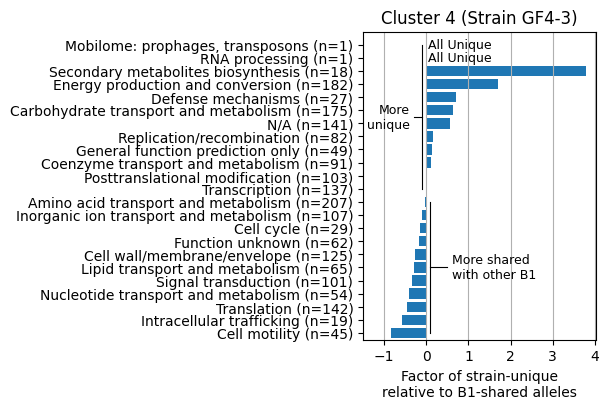

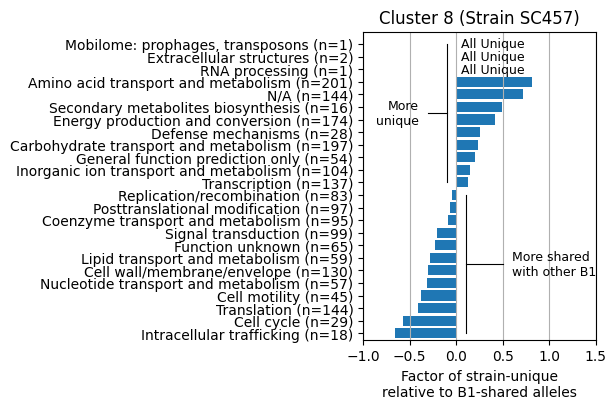

In [77]:
for adjust_man_i, (weird_name, weird_gid) in enumerate(weird_b1_lookup.items()):

    shared_sometimes = []

    for other in other_b1:
        shared = genome_id_to_alleles[weird_gid].intersection(genome_id_to_alleles[other])
        shared_sometimes.extend(list(shared))

    shared_sometimes = set(shared_sometimes)
    unique_to_this = genome_id_to_alleles[weird_gid] - shared_sometimes
    
    gene_provenance_dict = {
        'Shared': shared_sometimes,
        'Unique': unique_to_this
    }
    provenance_to_cogs = {}
    for provenance, allele_group in gene_provenance_dict.items():
    
        genes = []
        for feat_allele_id in allele_group:
            tss_id, gene_id, utr_id, allele_id = feat_allele_id.split('__')
            feat_id = '__'.join([tss_id, gene_id, utr_id])
            all_tss_df = with_genes[with_genes['first_gene_id'] == gene_id]
            for gid_raw in all_tss_df['gene_ids']:
                gids = gid_raw.split(';')
                genes.extend(gids)
        genes = list(set(genes))
        cogs = mg1655.gene_table.loc[genes]['cog'].fillna('N/A').values
        provenance_to_cogs[provenance] = cogs
        
    cog_to_total = Counter(list(provenance_to_cogs['Shared']) + list(provenance_to_cogs['Unique']))
    
    prov_to_cog_fracs = {prov: pd.Series(Counter(cogs)) / len(cogs) for prov, cogs in provenance_to_cogs.items()}
    prov_to_cog_fracs = {prov: cog_ser.loc[sorted(cog_ser.index)] for prov, cog_ser in prov_to_cog_fracs.items()}
    # default to -1 if missing
    cog_to_ratios = {}
    for cog in sorted(mg1655.gene_table['cog'].fillna('N/A').unique()):
        if cog in prov_to_cog_fracs['Unique'] and cog in prov_to_cog_fracs['Shared']:
            cog_to_ratios[cog] = (prov_to_cog_fracs['Unique'][cog] / prov_to_cog_fracs['Shared'][cog]) - 1
        elif cog in prov_to_cog_fracs['Unique']:
            cog_to_ratios[cog] = 1069
        elif cog in prov_to_cog_fracs['Shared']:
            cog_to_ratios[cog] = -1069
        # otherwise we don't have it at all - ignore
            
    sorted_cog_ratio_tups = sorted(cog_to_ratios.items(), key=lambda tup: tup[1])
            
    _, ax = plt.subplots(figsize=(3, 4))
    
    i_crossed_0 = None
    for i, (cog, ratio) in enumerate(sorted_cog_ratio_tups):
        if ratio > 0 and i_crossed_0 is None:
            i_crossed_0 = i - 1
        
        if ratio == 1069:
            ax.text(0.05, i, 'All Unique', fontsize=9, ha='left', va='center')
        elif ratio == -1069:
            ax.text(-0.05, i, 'All Shared', fontsize=9, ha='right', va='center')
        else:
            ax.barh(i, ratio, color='tab:blue')
    
    ax.plot([0.1, 0.1], [0, i_crossed_0], color='k', lw=0.8)
    ax.plot([0.1, 0.5], [i_crossed_0 / 2] * 2, color='k', lw=0.8)
    ax.text(0.6, i_crossed_0 / 2, 'More shared\nwith other B1', ha='left', va='center', multialignment='left', fontsize=9)
    
    ax.plot([-0.1, -0.1], [i_crossed_0 + 1, len(sorted_cog_ratio_tups) - 1], color='k', lw=0.8)
    unique_mid = ((len(sorted_cog_ratio_tups) - 1) + (i_crossed_0 + 1)) / 2
    ax.plot([-0.1, -0.3], [unique_mid] * 2, color='k', lw=0.8)
    ax.text(-0.4, unique_mid, 'More\nunique', ha='right', va='center', multialignment='right', fontsize=9)
    
    if adjust_man_i == 0:
        ax.set_xlim(left=-1.5)
        ax.set_xticks(range(-1, 5))
    elif adjust_man_i == 1:
        ax.set_xlim(-1, 1.5)
    ax.grid(axis='x', zorder=-5)
    ax.set_ylim(-0.5, len(sorted_cog_ratio_tups))
    ax.set_yticks(range(len(sorted_cog_ratio_tups)))
    ytick_labs = [f'{cog_name_lookup.get(cog, cog)} (n={cog_to_total[cog]})' for cog in list(zip(*sorted_cog_ratio_tups))[0]]
    ax.set_yticklabels(ytick_labs)
    ax.set_xlabel('Factor of strain-unique\nrelative to B1-shared alleles')
    ax.set_title(weird_name)
    
    plt.savefig(Path(FIG_PATH, f'{weird_name}_cog_unique.svg'), dpi = 300, bbox_inches = 'tight')
    plt.savefig(Path(FIG_PATH, f'{weird_name}_cog_unique.png'), dpi = 300, bbox_inches = 'tight')

### Weird A

In [78]:
weird_A_df = clst_df[(clst_df['phylogroup'] == 'A') & (clst_df['cluster'] != 2)]
weird_A_df

,cluster,phylogroup
562.61628,8,A
562.67849,8,A
562.66609,5,A


In [79]:
valid_genome_md[valid_genome_md['genome_id'].isin(weird_A_df.index)][['Genome Name', 'genome_id']]

,Genome Name,genome_id
1481,Escherichia coli strain MSB1_4G-sc-2280381,562.67849
2292,Escherichia coli strain EC96,562.66609
2346,Escherichia coli strain SCU-321,562.61628


In [80]:
weird_a_lookup = {
    'Cluster 5 (EC96)': '562.66609',
    'Cluster 8 (SCU-321)': '562.61628',
    'Cluster 8 (MSB1_4G-sc-2280381)': '562.67849'
}

other_a = list(clst_df[clst_df['phylogroup'] == 'A'].index)
print(len(other_a))
for weird_a_gid in weird_a_lookup.values():
    other_a.remove(weird_a_gid)
print(len(other_a))

783
780


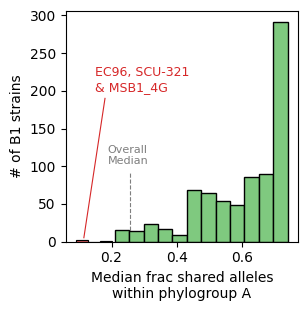

In [81]:
other_sim_medians = simil_df.loc[other_a, other_a].median()

_, ax = plt.subplots(figsize=(3, 3))

sns.histplot(other_sim_medians, ax=ax, color=phy_to_col['A'], alpha=1)
ax.axvline(overall_median_simil, linestyle='--', color='tab:gray', lw=0.8, zorder=-5, ymax=0.3)
ax.text(0.25, 100, 'Overall\nMedian', va='bottom', ha='center', color='tab:gray', fontsize=8)
ax.set_xlabel('Median frac shared alleles\nwithin phylogroup A')
ax.set_ylabel('# of B1 strains')

weird_medians = [simil_df.loc[weird_a_gid, other_a].median() for weird_a_gid in weird_a_lookup.values()]

sns.histplot(weird_medians, ax=ax, color='tab:red')
ax.text(0.15, 200, f'EC96, SCU-321\n& MSB1_4G', color='tab:red', ha='left', fontsize=9)
ax.plot([0.18, 0.115], [190, 5], color='tab:red', lw=0.8)

plt.savefig(Path(FIG_PATH, f'weird_a_hist.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'weird_a_hist.png'), dpi = 600, bbox_inches = 'tight')

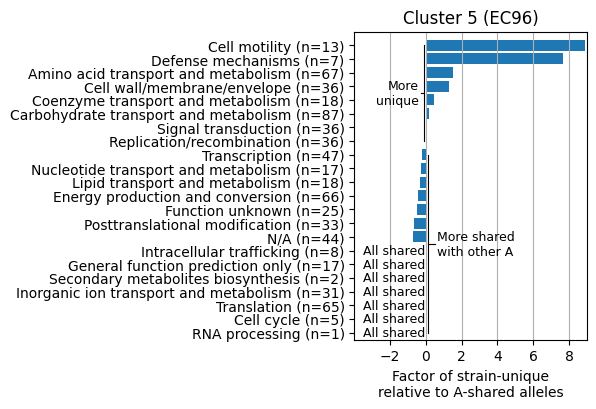

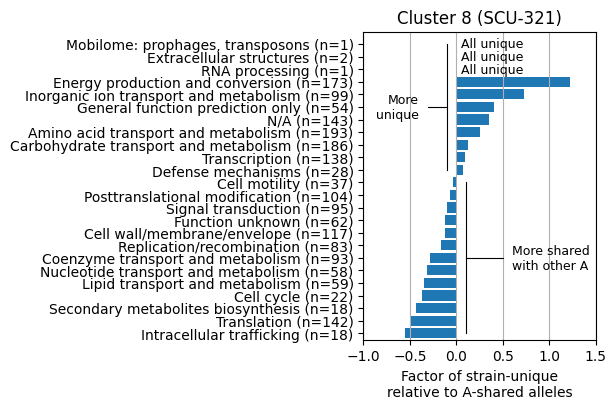

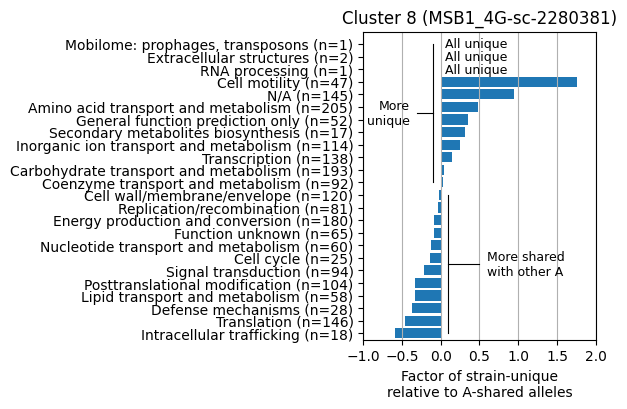

In [82]:
for manual_adj_i, (weird_name, weird_gid) in enumerate(weird_a_lookup.items()):

    shared_sometimes = []

    for other in other_a:
        shared = genome_id_to_alleles[weird_gid].intersection(genome_id_to_alleles[other])
        shared_sometimes.extend(list(shared))

    shared_sometimes = set(shared_sometimes)
    unique_to_this = genome_id_to_alleles[weird_gid] - shared_sometimes
    
    gene_provenance_dict = {
        'Shared': shared_sometimes,
        'Unique': unique_to_this
    }
    provenance_to_cogs = {}
    for provenance, allele_group in gene_provenance_dict.items():
    
        genes = []
        for feat_allele_id in allele_group:
            tss_id, gene_id, utr_id, allele_id = feat_allele_id.split('__')
            feat_id = '__'.join([tss_id, gene_id, utr_id])
            all_tss_df = with_genes[with_genes['first_gene_id'] == gene_id]
            for gid_raw in all_tss_df['gene_ids']:
                gids = gid_raw.split(';')
                genes.extend(gids)
        genes = list(set(genes))
        cogs = mg1655.gene_table.loc[genes]['cog'].fillna('N/A').values
        provenance_to_cogs[provenance] = cogs
        
    cog_to_total = Counter(list(provenance_to_cogs['Shared']) + list(provenance_to_cogs['Unique']))
    
    prov_to_cog_fracs = {prov: pd.Series(Counter(cogs)) / len(cogs) for prov, cogs in provenance_to_cogs.items()}
    prov_to_cog_fracs = {prov: cog_ser.loc[sorted(cog_ser.index)] for prov, cog_ser in prov_to_cog_fracs.items()}
    # default to -1 if missing
    cog_to_ratios = {}
    for cog in sorted(mg1655.gene_table['cog'].fillna('N/A').unique()):
        if cog in prov_to_cog_fracs['Unique'] and cog in prov_to_cog_fracs['Shared']:
            cog_to_ratios[cog] = (prov_to_cog_fracs['Unique'][cog] / prov_to_cog_fracs['Shared'][cog]) - 1
        elif cog in prov_to_cog_fracs['Unique']:
            cog_to_ratios[cog] = 1069
        elif cog in prov_to_cog_fracs['Shared']:
            cog_to_ratios[cog] = -1069
        # otherwise we don't have it at all - ignore
            
    sorted_cog_ratio_tups = sorted(cog_to_ratios.items(), key=lambda tup: tup[1])
            
    _, ax = plt.subplots(figsize=(3, 4))
    
    i_crossed_0 = None
    for i, (cog, ratio) in enumerate(sorted_cog_ratio_tups):
        if ratio > 0 and i_crossed_0 is None:
            i_crossed_0 = i - 1
        
        if ratio == 1069:
            ax.text(0.05, i, 'All unique', fontsize=9, ha='left', va='center')
        elif ratio == -1069:
            ax.text(-0.05, i, 'All shared', fontsize=9, ha='right', va='center')
        else:
            ax.barh(i, ratio, color='tab:blue')
    
    ax.plot([0.1, 0.1], [0, i_crossed_0], color='k', lw=0.8)
    ax.plot([0.1, 0.5], [i_crossed_0 / 2] * 2, color='k', lw=0.8)
    ax.text(0.6, i_crossed_0 / 2, 'More shared\nwith other A', ha='left', va='center', multialignment='left', fontsize=9)
    
    ax.plot([-0.1, -0.1], [i_crossed_0 + 1, len(sorted_cog_ratio_tups) - 1], color='k', lw=0.8)
    unique_mid = ((len(sorted_cog_ratio_tups) - 1) + (i_crossed_0 + 1)) / 2
    ax.plot([-0.1, -0.3], [unique_mid] * 2, color='k', lw=0.8)
    ax.text(-0.4, unique_mid, 'More\nunique', ha='right', va='center', multialignment='right', fontsize=9)
    
    if manual_adj_i == 0:
        ax.set_xlim(-4, 9)
        ax.set_xticks(range(-2, 10, 2))
    elif manual_adj_i == 1:
        ax.set_xlim(-1, 1.5)
    elif manual_adj_i == 2:
        ax.set_xlim(-1, 2)
        ax.set_xticks(np.arange(-1, 2.5, 0.5))
    ax.grid(axis='x', zorder=-5)
    ax.set_ylim(-0.5, len(sorted_cog_ratio_tups))
    ax.set_yticks(range(len(sorted_cog_ratio_tups)))
    ytick_labs = [f'{cog_name_lookup.get(cog, cog)} (n={cog_to_total[cog]})' for cog in list(zip(*sorted_cog_ratio_tups))[0]]
    ax.set_yticklabels(ytick_labs)
    ax.set_xlabel('Factor of strain-unique\nrelative to A-shared alleles')
    ax.set_title(weird_name)
    
    plt.savefig(Path(FIG_PATH, f'{weird_name}_cog_unique.svg'), dpi = 300, bbox_inches = 'tight')
    plt.savefig(Path(FIG_PATH, f'{weird_name}_cog_unique.png'), dpi = 300, bbox_inches = 'tight')

# Single Promoter/UTR Analysis

## Feature Styles

In [83]:
nice_name_to_patch_kwargs = {
    'Coding': {'facecolor': 'white', 'edgecolor': 'k', 'label': 'Coding', 'lw': 1},
    'RBS': {'color': 'violet', 'label': 'RBS', 'alpha': 0.6},
    '-10 Box': {'color': 'lightgreen', 'label': '-10 Box', 'alpha': 0.6},
    '-35 Box': {'color': 'lightsalmon', 'label': '-35 Box', 'alpha': 0.6},
    'Atten': {'color': 'goldenrod', 'label': 'Attenuator', 'alpha': 0.6},
    'TSS': {'color': 'k', 'shape': 'full', 'width': 0.5, 'head_width':2, 'length_includes_head':True, 'head_length':5, 'lw':0.8, 'label':'TSS'},
    'ALE': {'zorder':-5, 'color':'peru', 'label':'ALE Mut'},
    'Nothing': {'edgecolor': 'tab:gray', 'facecolor': 'white', 'linestyle': '--', 'lw':1, 'label':'No annot.', 'zorder':-20},
    'Spacer': {'color': 'tab:gray', 'alpha': 0.2, 'label': 'Spacer'},
    'TFBS': {'color': 'tab:blue', 'alpha': 0.6, 'label': 'TFBS'}
}

LEFT_TO_RIGHT = ['TFBS', '-35 Box', 'Spacer', '-10 Box', 'CRE', 'Atten', 'RBS', 'Coding', 'Nothing']

## Dashboard Function

In [89]:
# Define range constants; if you changed them in 0__build_alleleome make sure to change here too
FIVE_UTR_TSS_UP = 200
FIVE_UTR_GENE_DOWN = 50
SIG_THRESHOLD = 15

def alleleome_dashboard(feat_id, plot=True, save_prefix=None):

    tss_id, gene_id, _ = feat_id.split('__')
    tss_row = bitome_mg1655_tss_df.loc[tss_id]
    gene_row = mg1655.gene_table.loc[gene_id]
    feat_strand = tss_row['strand']

    feat_bp_df = base_pair_df[base_pair_df['feat_id'] == feat_id]
    feat_bp_df = feat_bp_df.sort_values(by='align_idx')
    feat_align_df = feat_id_to_align_df[feat_id]
    feat_align_df = feat_align_df.assign(
        allele_freq=(feat_align_df['count'] / feat_align_df['count'].sum() * 100)
    )

    n_total_bps = feat_bp_df.shape[0]
    n_variant_bps = feat_bp_df[feat_bp_df['variant_pct'] > 0].shape[0]
    n_invariant_bps = n_total_bps - n_variant_bps
    n_sig_vars = feat_bp_df[feat_bp_df['variant_pct'] > SIG_THRESHOLD].shape[0]
    n_insig_vars = n_variant_bps - n_sig_vars

    align_len = len(feat_align_df['seq_align'].iloc[0])
    total_seqs = feat_bp_df['num_seqs'].iloc[0]
    
    assert align_len == feat_bp_df.shape[0]
    
    feat_stat_dict = {
        'feat_id': feat_id,
        'n_total_bps': n_total_bps,
        'n_variant_bps': n_variant_bps,
        'n_invariant_bps': n_invariant_bps,
        'n_sig_vars': n_sig_vars,
        'n_insig_vars': n_insig_vars,
        'total_seqs': total_seqs,
        'n_alleles': feat_align_df.shape[0],
        'essential': feat_bp_df['essential'].iloc[0],
        'tpm_median_cat': feat_bp_df['tpm_median_cat'].iloc[0],
        'tpm_mad_cat': feat_bp_df['tpm_mad_cat'].iloc[0]
    }
    
    # we need a way of converting between axis positions and MG relative positions (non-aligned)
    align_idx_to_mg_rel = dict(zip(feat_bp_df['align_idx'], feat_bp_df['mg_rel_pos']))
    # take the smallest (closest to gene start) of the MG rel poses for this conversion to avoid duplicates
    mg_rel_to_align_idxes = {}
    for align_i, mg_rel in align_idx_to_mg_rel.items():
        if mg_rel in mg_rel_to_align_idxes:
            mg_rel_to_align_idxes[mg_rel].append(align_i)
        else:
            mg_rel_to_align_idxes[mg_rel] = [align_i]
    mg_rel_to_align_idx = {mg_rel: min(align_idxes) for mg_rel, align_idxes in mg_rel_to_align_idxes.items()}
    
    # =============================== PHYLOGROUP PLOT ============================
    
    
    
    # =============================== ALLELE PLOT =================================
    
    # keep some out of plot zone because we want it in the summary dict
    thresh_to_col = {
        90: 'tab:red',
        95: 'tab:orange',
        99: 'tab:green'
    }
    
    cumsum = np.cumsum(feat_align_df['allele_freq'])
    # prepend a 0
    cumsum = np.array([0] + list(cumsum))
    x_pct = np.linspace(0, 100, num=len(cumsum))
    
    thresh_to_pct_ymax = {}
    for thresh, col in thresh_to_col.items():
        selector = cumsum < thresh
        n_to_get_over_thresh = (selector).sum() + 1
        pct_to_get_over_thresh = n_to_get_over_thresh / len(cumsum) * 100
        max_cumsum = cumsum[selector].max()
        thresh_to_pct_ymax[thresh] = (pct_to_get_over_thresh, max_cumsum)
        feat_stat_dict[f'allele_pct_{thresh}'] = pct_to_get_over_thresh
        
    feat_stat_dict['top_allele_pct'] = cumsum[1]
    
    if plot:

        _, ax = plt.subplots(figsize=(3, 3))

        ax.plot(x_pct, cumsum)
        ax.set_ylabel(f'% of Genomes ({total_seqs} total)')
        ax.set_xlabel(f"% of Alleles ({feat_align_df.shape[0]} total)")
        ax.set_ylim(0, 100)
        ax.set_xlim(0, 100)
        
        # plot in the largest allele frac
        ax.plot([x_pct[1], x_pct[1] + 3.8], [cumsum[1]]*2, color='k')
        ax.text(x_pct[1] + 4, cumsum[1], f"Most Common\n({cumsum[1]:.1f}%)", fontsize=9, ha='left', va='center')

        for thresh, (pct, ymax) in thresh_to_pct_ymax.items():
            ax.axvline(pct, color=thresh_to_col[thresh], linestyle='--', lw=0.8, ymax=ymax/100, label=f"{thresh}%")

        ax.legend(loc='lower right')
        
        if save_prefix is not None:
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_allele_cum.svg'), dpi = 600, bbox_inches = 'tight')
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_allele_cum.png'), dpi = 600, bbox_inches = 'tight')
            
    # ============================== ALLELE PHYLOGROUP HEATMAP ==================================
    if plot:
        
        genome_id_to_phylo = dict(zip(valid_genome_md['genome_id'], valid_genome_md['phylogroup']))

        nf_allele_id = feat_align_df.index.max() + 1
        pgroup_to_all_ids = {phylo: [] for phylo in valid_genome_md['phylogroup'].unique()}
        for gid, alls in genome_id_to_alleles.items():
            phylo = genome_id_to_phylo[gid]
            found = False
            for allele in alls:
                tss, gene, utr, all_id = allele.split('__')
                fid_to_match = '__'.join([tss, gene, utr])
                if fid_to_match == feat_id:
                    pgroup_to_all_ids[phylo].append(all_id)
                    found = True
                    break
            if not found:
                pgroup_to_all_ids[phylo].append(nf_allele_id)

        pgroup_to_all_counts = {pgroup: Counter(alls) for pgroup, alls in pgroup_to_all_ids.items()}
        pgroup_allele_rows = []
        pgroup_index = []
        for pgroup, count_dict in pgroup_to_all_counts.items():
            pgroup_index.append(pgroup)
            pgroup_allele_rows.append(count_dict)

        pgroup_count_df = pd.DataFrame(pgroup_allele_rows, index=pgroup_index)
        pgroup_count_df = pgroup_count_df.rename(columns={col: int(col) for col in pgroup_count_df.columns})
        pgroup_count_df = pgroup_count_df[sorted(pgroup_count_df.columns)]
        pgroup_count_df = pgroup_count_df.loc[phy_to_count.keys()]
        pgroup_count_df = pgroup_count_df.fillna(0)
        pgroup_count_df_phylo_norm = pgroup_count_df.div(pgroup_count_df.sum(axis=1), axis=0)
        pgroup_count_df_both_norm = pgroup_count_df / 2350
        pgroup_count_df_allele_norm = pgroup_count_df.div(pgroup_count_df.sum(axis=0), axis=1)

        tot = 0
        thresh = 0.90
        cum_points = []
        for i, this in enumerate(pgroup_count_df_both_norm.sum()):
            if tot > thresh:
                break
            else:
                tot += this
                cum_points.append((i+0.5, tot * 100))
        last_i = i
        cutoff_df = pgroup_count_df_phylo_norm.iloc[:, :last_i]

        not_found_phylo_fracs = pgroup_count_df_phylo_norm.iloc[:, -1]
        remaining_phylo_fracs = 1 - cutoff_df.sum(axis=1) - not_found_phylo_fracs

        cutoff_df = cutoff_df.assign(
            dummy1=0,
            dummy2=0,
            dummy3=0,
            remaining=remaining_phylo_fracs,
            dummy4=0,
            dummy5=0,
            dummy6=0,
            not_found=not_found_phylo_fracs
        )

        _, ((ax_cum, _), (ax, ax_cbar)) = plt.subplots(2, 2, figsize=(6, 3), height_ratios=[1.5, 4], width_ratios=[10, 1], sharex=True)

        cum_x, cum_y = zip(*cum_points)
        for x, y in zip(cum_x, cum_y):
            ax_cum.scatter(x, y, color='tab:blue', alpha=0.5, s=5)
        ax_cum.set_ylim(0, 100)
        ax_cum.set_ylabel('% genomes                   ', rotation=0, ha='center', va='center')
        cum_yticks = [25, 50, 75, 90]
        for cum_tick in cum_yticks:
            if cum_tick == 25:
                continue
            first_pos = None
            for i, cum_y_pt in enumerate(cum_y):
                if cum_y_pt > cum_tick:
                    first_pos = i
                    break
            if first_pos is not None and first_pos != 0:
                ax_cum.plot(np.array([0, first_pos]) + 0.5, [cum_tick, cum_tick], zorder=-10, color='tab:gray', lw=0.8)
                ax_cum.plot(np.array([first_pos, first_pos]) + 0.5, [0, cum_tick], zorder=-10, color='tab:gray', lw=0.8)
                ax_cum.text(first_pos + 0.25, 0, f"{first_pos + 1}", ha='right', va='bottom', fontsize=8)

        ax_cum.set_yticks(cum_yticks)
        ax_cum.tick_params(axis='y', labelsize=9)
        for loc, spine in ax_cum.spines.items():
            if loc != 'left':
                spine.set_visible(False)

        plt.subplots_adjust(hspace=0.05)

        sns.heatmap(cutoff_df, mask=(cutoff_df==0), ax=ax, cmap='cool', norm='log', linewidths=0.4, linecolor='lightgray',
                   cbar_kws={'format': "{x:.2f}"}, cbar_ax=ax_cbar)
        ax.set_yticks(np.arange(0.5, len(phy_to_count) + 0.5, 1))
        ax.set_yticklabels([f'{phy} (n={ct})' for phy, ct in phy_to_count.items()])
        ax.set_xticks([])
        ax.tick_params(axis='y', labelsize=9)
        ax.add_patch(plt_patches.Rectangle(
            (last_i+0.2, 0), 3 - 0.4, 14,
            color='white',
            zorder=10
        ))
        ax.add_patch(plt_patches.Rectangle(
            (last_i+4.2, 0), 3 - 0.4, 14,
            color='white',
            zorder=10
        ))
        ax.spines['right'].set_visible(True)
        ax.spines['right'].set_linewidth(0.4)
        ax.spines['right'].set_color('lightgray')
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_linewidth(0.4)
        ax.spines['bottom'].set_color('lightgray')

        ax.text(0.01, -0.01, f"{last_i}/{feat_align_df.shape[0]} ({last_i/feat_align_df.shape[0] * 100:.0f}%) alleles →", transform=ax.transAxes, va='top')
        ax.set_xticks([last_i + 3.7, last_i + 7.7])
        ax.set_xticklabels(['Other Alleles', 'Not Found'], rotation=90, ha='center')
        ax.tick_params(axis='x', labelsize=9, length=0)
        ax_cum.tick_params(axis='x', length=0)
        ax.xaxis.tick_top()
        ax_cbar.set_ylabel('Frac of phylogroup')
        
        if save_prefix is not None:
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_allele_phylo_heat.svg'), dpi = 600, bbox_inches = 'tight')
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_allele_phylo_heat.png'), dpi = 600, bbox_inches = 'tight')

    # =============================== MAIN PLOT OF BITOME REGION =================================
    
    if plot:

        _, ax = plt.subplots(figsize=(6, 3))

        ax.plot(feat_bp_df['align_idx'], feat_bp_df['dominant_pct'], linewidth=0.8, label='Dom var')

        ax.set_xlim(0, align_len)
        ax.set_ylim(-5, 105)
        ax.set_ylabel('% Genomes with Allele', fontsize=10)
        ax.axhline(100, color='tab:red', linewidth=0.7, linestyle='--', zorder=-5)

        for _, bp_row in feat_bp_df.iterrows():

            # only need to plot any variant alleles if there are any
            align_idx = bp_row['align_idx']
            var_pct = bp_row['variant_pct']
            if var_pct > 0:
                dominant_base = bp_row['dominant_base']
                var_bases = set(list('ACGT-')) - set(dominant_base)
                for var_base in var_bases:
                    var_base_pct = bp_row[f'{var_base}_pct']
                    if var_base_pct >= SIG_THRESHOLD:
                        ax.scatter(align_idx, var_base_pct, marker='x', color='tab:red', s=10, label='Major')
                        ax.plot([align_idx]*2, [var_base_pct, 50], color='tab:red', linestyle='-.', lw=0.5)
                    elif var_base_pct > 0:
                        ax.scatter(align_idx, var_base_pct, marker='.', color='tab:gray', s=5, label='Minor')

        # use this to set the tick labels appropriately
        # ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True, which='both')
        ax.set_xlabel(f"bp from {gene_row['name']} Gene Start", fontsize=10)

        tss_graph_pos = mg_rel_to_align_idx[0]
        mg_rel_max_up = min(mg_rel_to_align_idxes.keys())
        tick_interval = 50
        x_ticks_mg = list(range(mg_rel_max_up + (-mg_rel_max_up % tick_interval), FIVE_UTR_GENE_DOWN + 1, tick_interval))
        x_ticks_graph_pos = [mg_rel_to_align_idx[x_tick_mg] for x_tick_mg in x_ticks_mg]
        ax.set_xticks(x_ticks_graph_pos)
        ax.set_xticklabels(x_ticks_mg);

        # add the "sequence"
        ax.axhline(50, linestyle='-', zorder=-20, linewidth=1, color='k')

        # keep track of tracks for stacked features
        align_idx_to_tfbs_track = {idx: 50.5 for idx in range(align_len)}
        align_idx_to_atten_term_track = {idx: 45.5 for idx in range(align_len)}

        ax.set_title(f"{gene_row['name']} UTR and promoter ({n_total_bps} total bps)\n"
                     f"{total_seqs}/2350 strains with feature ({feat_align_df.shape[0]} alleles)\n"
                     f"{'Essential' if gene_row['essential'] is True else 'Non-Essential'}; {mg1655.gene_table.loc[gene_id]['cog']}")

    # also keep track of some stats about each of the bool cols while we're at it
    feat_stats_rows = []

    for bool_col in in_bool_cols:
        nice_name = bool_col_to_nice_name[bool_col]
        bp_for_col_df = feat_bp_df[feat_bp_df[bool_col]]

        # add in some count stats about the bp in this range
        # bp_for_col_df may be empty, which is fine here;
        # want to make the entry anyways w/zeroes
        n_bp_for_col = bp_for_col_df.shape[0]
        bp_for_col_variant_df = bp_for_col_df[bp_for_col_df['variant_pct'] > 0]
        n_bp_for_col_variant = bp_for_col_variant_df.shape[0]
        frac_bp_for_col_in_seq = n_bp_for_col / n_total_bps
        frac_bp_for_col_var = n_bp_for_col_variant / n_variant_bps
        diff = frac_bp_for_col_var - frac_bp_for_col_in_seq
        feat_stats_rows.append({
            'feat_type': nice_name,
            'n_bp_seq': n_bp_for_col,
            'frac_bp_seq': frac_bp_for_col_in_seq,
            # make everything NA if we don't have this feature in seq at all
            'n_bp_var': n_bp_for_col_variant if frac_bp_for_col_in_seq > 0 else None,
            'frac_bp_var': frac_bp_for_col_var if frac_bp_for_col_in_seq > 0 else None,
            'median_var_pct': bp_for_col_variant_df['variant_pct'].median() if frac_bp_for_col_in_seq > 0 else None,
            'frac_diff_seq_vs_var': diff if frac_bp_for_col_in_seq > 0 else None,
            'diff_ratio': (diff / frac_bp_for_col_in_seq if frac_bp_for_col_in_seq > 0 else 0) if frac_bp_for_col_in_seq > 0 else None,
            'n_bp_invar': (n_bp_for_col - n_bp_for_col_variant) if frac_bp_for_col_in_seq > 0 else None
        })

        if plot and not bp_for_col_df.empty:
            non_bool_feat_col = bool_col.replace('_bool', '')
            # group by the individual features - except for 'nothing'
            if non_bool_feat_col == 'in_nothing':
                pass
            else:
                # there are some overlaps; so some bp rows have ;-separated entries - deal with that
                unique_feat_ids = []
                for feat_id_raw in bp_for_col_df[non_bool_feat_col].unique():
                    unique_feat_ids.extend(feat_id_raw.split(';'))
                unique_feat_ids = list(set(unique_feat_ids))
                # special case for color mapping of TFBS; define that here
                if nice_name == 'TFBS':
                    unique_tfs = set([ufi.split('__')[1] for ufi in unique_feat_ids])
                    tfbs_cols = ['tab:blue', 'tab:purple', 'tab:green', 'tab:pink', 'cyan', 'rosybrown']
                    assert len(tfbs_cols) >= len(unique_tfs)
                    tf_to_col = dict(zip(unique_tfs, tfbs_cols))
                for in_feat_id in unique_feat_ids:
                    # need to account for _# suffixes
                    def feat_in_col(raw_feat_ids):
                        feat_ids_split = raw_feat_ids.split(';')
                        return in_feat_id in feat_ids_split
                    in_feat_bp_df = bp_for_col_df[bp_for_col_df[non_bool_feat_col].apply(feat_in_col)]
                    min_align_idx, max_align_idx = in_feat_bp_df['align_idx'].min(), in_feat_bp_df['align_idx'].max()
                    feat_width = max_align_idx - min_align_idx

                    # --- CODING GENE PATCHES ---
                    if nice_name == 'Coding':
                        # want to point the gene appropriately to indicate strand
                        this_gene_row = mg1655.gene_table[mg1655.gene_table['name'] == in_feat_id].iloc[0]
                        arrow_w = 10
                        if this_gene_row['strand'] == feat_strand:
                            gene_patch = plt_patches.Polygon(
                                [
                                    # bottom left, top left, right top of arrow
                                    (min_align_idx, 45), (min_align_idx, 55), (max_align_idx - arrow_w, 55),
                                    # middle of arrow, right bottom of arrow
                                    (max_align_idx, 50), (max_align_idx - arrow_w, 45)
                                ],
                                **nice_name_to_patch_kwargs['Coding']
                            )
                        else:
                            gene_patch = plt_patches.Polygon(
                                [
                                    # bottom right, top right, left top of arrow
                                    (max_align_idx, 45), (max_align_idx, 55), (min_align_idx + arrow_w, 55),
                                    # middle of arrow, left bottom of arrow
                                    (min_align_idx, 50), (min_align_idx + arrow_w, 45)
                                ],
                                **nice_name_to_patch_kwargs[nice_name]
                            )
                        ax.add_patch(gene_patch)
                        gene_mid = min_align_idx + feat_width // 2
                        # text won't fit
                        if feat_width < 25:
                            ax.text(max_align_idx - 4, 45, this_gene_row['name'], va='center', ha='left', fontstyle='italic')
                        else:
                            ax.text(gene_mid, 50, this_gene_row['name'], va='center', ha='center', fontstyle='italic')

                    # ------- TFBS ------
                    elif nice_name == 'TFBS':
                        track_to_use = max([align_idx_to_tfbs_track[align_idx] for align_idx in range(min_align_idx, max_align_idx + 1)])
                        tf_name = in_feat_id.split('__')[1]
                        tfbs_rect = plt_patches.Rectangle(
                            (min_align_idx, track_to_use), feat_width, 4,
                            zorder=-5, color=tf_to_col[tf_name], label=tf_name
                        )
                        ax.add_patch(tfbs_rect)
                        for align_idx in range(min_align_idx, max_align_idx + 1):
                            align_idx_to_tfbs_track[align_idx] += 5

                    # --- TSS/CRE ---
                    elif nice_name == 'TSS':
                        # idxes should be the same
                        this_tss_row = bitome_mg1655_tss_df.loc[in_feat_id]
                        dx_mult = this_tss_row['strand'] * feat_strand
                        ax.plot([min_align_idx]*2, [50, 55], color='k', lw=0.8)
                        ax.arrow(min_align_idx, 55, 15 * dx_mult, 0, **nice_name_to_patch_kwargs[nice_name])

                    # --- ALE mutations ---
                    elif nice_name == 'ALE':
                        ax.plot([min_align_idx]*2, [40, 50], **nice_name_to_patch_kwargs[nice_name])
                        ax.scatter(min_align_idx, 40, color=nice_name_to_patch_kwargs[nice_name]['color'], s=7)

                    # --- attenuators and terminators may need to be tracked properly
                    elif nice_name == 'Atten':
                        track_to_use = min([align_idx_to_atten_term_track[align_idx] for align_idx in range(min_align_idx, max_align_idx + 1)])
                        feat_rect = plt_patches.Rectangle(
                            (min_align_idx, track_to_use), feat_width, 4,
                            **nice_name_to_patch_kwargs[nice_name]
                        )
                        ax.add_patch(feat_rect)
                        for align_idx in range(min_align_idx, max_align_idx + 1):
                            align_idx_to_atten_term_track[align_idx] -= 5

                    # --- RBS, -10/-35 boxes, are just simple boxes on the same track ---
                    elif nice_name in ['RBS', '-10 Box', '-35 Box']:
                        feat_rect = plt_patches.Rectangle(
                            (min_align_idx, 45), feat_width, 10,
                            **nice_name_to_patch_kwargs[nice_name]
                        )
                        ax.add_patch(feat_rect)

                    # --- intentionally do not plot for the CRE or Spacer for now ---
                    elif nice_name in ['CRE', 'Spacer']:
                        pass

                    else:
                        raise ValueError(f'Unrecognized nice name {nice_name}')

    if plot:
        handles, labels = ax.get_legend_handles_labels()
        new_handles = []
        new_labels = []
        for hand, lab in zip(handles, labels):
            if lab not in new_labels and lab != 'TSS':
                new_handles.append(hand)
                new_labels.append(lab)
        ax.legend(handles=new_handles, labels=new_labels, bbox_to_anchor=(1, 0.5), loc='center left', fontsize=9)

        if save_prefix is not None:
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_dashboard.svg'), dpi = 600, bbox_inches = 'tight')
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_dashboard.png'), dpi = 600, bbox_inches = 'tight')

    # =============================== BASIC PIE CHART =================================

    if plot:
        # create a long-form version for easier plotting with our desired fraction columns only
        _, ax_pie = plt.subplots(figsize=(3, 3))

        ax_pie.pie([n_invariant_bps, n_sig_vars, n_insig_vars],
                   labels=['Invariant', 'Major', 'Minor'], colors=['lightgrey', 'tab:red', 'tab:gray'],
                  autopct=lambda p: f'{int(np.round(p * n_total_bps / 100))}\n({p:.1f}%)')
        
        if save_prefix is not None:
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_pie.svg'), dpi = 600, bbox_inches = 'tight')
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_pie.png'), dpi = 600, bbox_inches = 'tight')

    # =============================== HISTOGRAM OF VARIANT PCTS for VARIANT BPs =================================

    if plot:
        _, ax_var_hist = plt.subplots(figsize=(2.5, 2))

        sns.histplot(feat_bp_df[feat_bp_df['variant_pct'] > 0]['variant_pct'], ax=ax_var_hist, bins=20)

        ax_var_hist.set_xlabel('Variant %')
        ax_var_hist.set_ylabel('# of bps')
        
        if save_prefix is not None:
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_var_hist.svg'), dpi = 600, bbox_inches = 'tight')
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_var_hist.png'), dpi = 600, bbox_inches = 'tight')

    # =============================== VARIANT BREAKDOWN BY BITOME FEATURE =================================

    # put together the data for the fractions and make a bar chart of the features that we happen to have in this UTR/promoter
    feat_stats_df = pd.DataFrame(feat_stats_rows)
    # only include things we want to plot - they will be in left_to_right
    feat_stats_df = feat_stats_df[feat_stats_df['feat_type'].isin(LEFT_TO_RIGHT)]
    feat_stats_df = feat_stats_df.assign(
        sort_idx=feat_stats_df['feat_type'].apply(lambda ft: LEFT_TO_RIGHT.index(ft))
    )
    feat_stats_df = feat_stats_df.sort_values(by='sort_idx')

    if plot:
        _, (ax_bars, ax_diag, ax_diff) = plt.subplots(3, 1, figsize=(5, 4), sharex=True, height_ratios=[3, 1, 3])

        plot_stats_rows = []
        for _, feat_stat_row in feat_stats_df.iterrows():
            plot_stats_rows.extend([
                {'feat_type': feat_stat_row['feat_type'], 'bps': 'Variant', 'value': feat_stat_row['frac_bp_var'] * 100},
                {'feat_type': feat_stat_row['feat_type'], 'bps': 'All', 'value': feat_stat_row['frac_bp_seq'] * 100}
            ])
        plot_stats_df = pd.DataFrame(plot_stats_rows)

        sns.barplot(data=plot_stats_df, x='feat_type', y='value', hue='bps', hue_order=['All', 'Variant'],
                    ax=ax_bars, palette=['tab:blue', 'tab:red'])
        ax_bars.set_xticks([])
        ax_bars.set_xlabel('')
        ax_bars.set_ylabel('')

        ax_bars.set_ylabel('% of bps')

        # place xs on the x axis to indicate we have none of that feature in this case
        bar_ymin, bar_ymax = ax_bars.get_ylim()
        bar_y_dist = bar_ymax - bar_ymin
        for i, n_bp in enumerate(feat_stats_df['n_bp_seq']):
            if n_bp == 0:
                ax_bars.scatter(i, bar_y_dist * 0.05, marker='x', color='lightcoral')

        plt.subplots_adjust(wspace=0, hspace=0.1)

        ax_diag.axhline(0.7, linewidth=1, color='k', zorder=-10)
        for s in ax_diag.spines.values():
            s.set_visible(False)
        ax_diag.tick_params(axis='y', length=0)
        ax_diag.set_ylim(0, 1)
        ax_diag.set_yticks([])

        for i, nice_name in enumerate(LEFT_TO_RIGHT):

            # do a big switch - this will make it easier to turn things on and off or re-shuffle later
            # gene is a bit cute shape
            if nice_name == 'Coding':
                gene_patch = plt_patches.Polygon(
                    [[i - 0.4, 0.5], [i + 0.25, 0.5], [i + 0.4, 0.7], [i + 0.25, 0.9], [i - 0.4, 0.9]],
                    **nice_name_to_patch_kwargs[nice_name]
                )
                ax_diag.add_patch(gene_patch)

            # make a little TSS arrow for the CRE
            elif nice_name == 'CRE':
                ax_diag.plot([i - 0.2, i - 0.2], [0.7, 0.9], color='k', lw=0.8, label='TSS/CRE')
                ax_diag.arrow(i - 0.2, 0.9, 0.5, 0, color='k', shape='full', width=0.01,
                              head_width=0.075, length_includes_head=True, head_length=0.1, lw=0.8)

            # RBS is a bit less wide
            elif nice_name == 'RBS':
                rbs_patch = plt_patches.Rectangle(
                    (i - 0.2, 0.5), 0.4, 0.4,
                    **nice_name_to_patch_kwargs[nice_name]
                )
                ax_diag.add_patch(rbs_patch)

            # these things are normal
            elif nice_name in ['Nothing', 'Atten', 'Term', '-10 Box', '-35 Box', 'Spacer', 'TFBS']:
                default_patch = plt_patches.Rectangle(
                    (i - 0.4, 0.5), 0.8, 0.4,
                    **nice_name_to_patch_kwargs[nice_name]
                )
                ax_diag.add_patch(default_patch)

        ax_diag.legend(bbox_to_anchor=(1, 0.5), loc='center left')

        for i, (n_all_bp, n_var_bp) in enumerate(zip(feat_stats_df['n_bp_seq'], feat_stats_df['n_bp_var'])):
            ax_diag.text(i, 0.3, f'{int(n_all_bp)}', fontsize=9, ha='center', va='center', color='tab:blue')
            ax_diag.text(i, 0.0, f'{int(n_var_bp)}' if pd.notna(n_var_bp) else '', fontsize=9, ha='center', va='center', color='tab:red')

        # make a new plot stats df that captures the diffs
        sns.barplot(data=feat_stats_df, x='feat_type', y='diff_ratio', ax=ax_diff, color='tab:green')
        ax_diff.set_ylabel('Rel Variant\nEnrichment', fontsize=10)
        ax_diff.set_xlabel('')
        ax_diff.set_xticks([])
        ax_diff.axhline(0, linestyle='--', color='tab:gray', lw=0.8)
        
        if save_prefix is not None:
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_var_by_feat.svg'), dpi = 600, bbox_inches = 'tight')
            plt.savefig(Path(FIG_PATH, f'{save_prefix}_var_by_feat.png'), dpi = 600, bbox_inches = 'tight')
        
    return feat_stat_dict, feat_bp_df, feat_stats_df

## Dashboard Sandbox

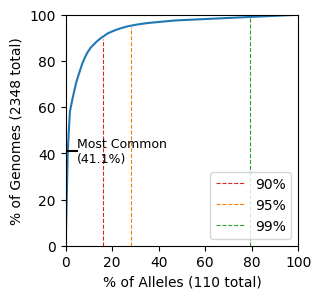

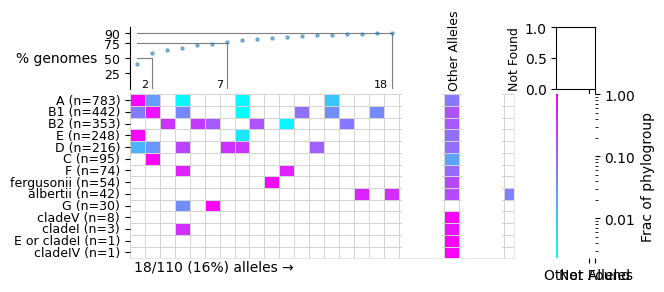

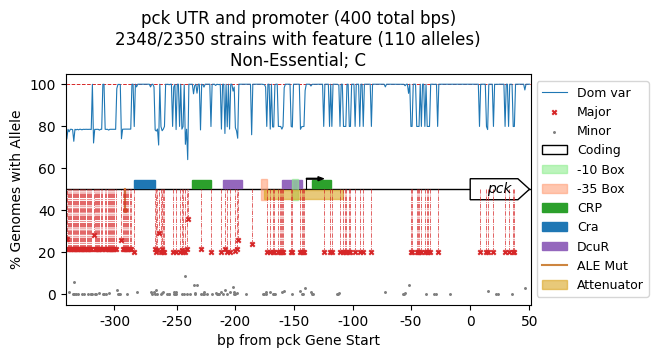

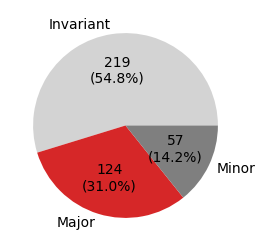

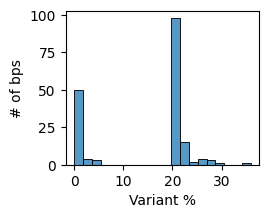

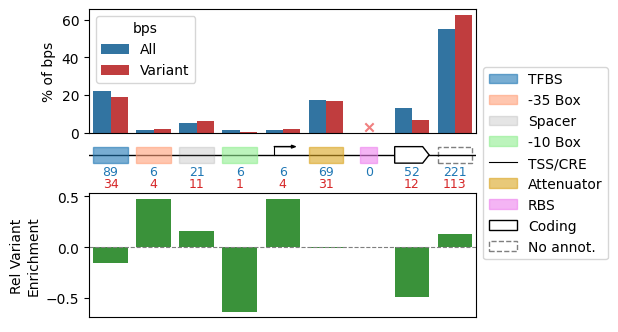

In [90]:
feat_stat_dict, feat_bp_df, feat_stat_df = alleleome_dashboard('TSS_3532679_f__b3403__5utr', plot=True)

## Dashboard Example [aceB]

aceB is really good: 'TSS_4215402_f__b4014__5utr'

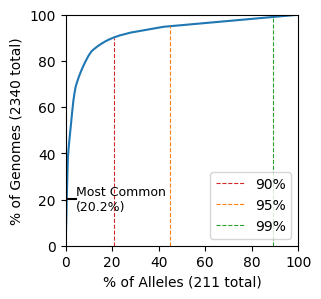

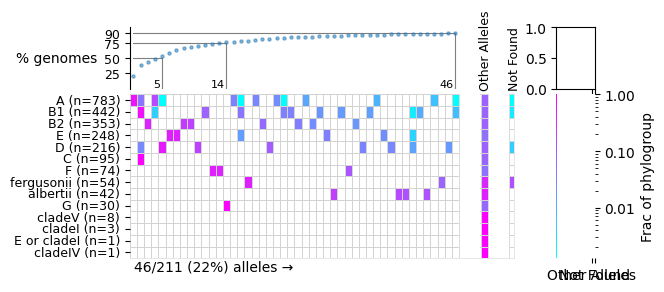

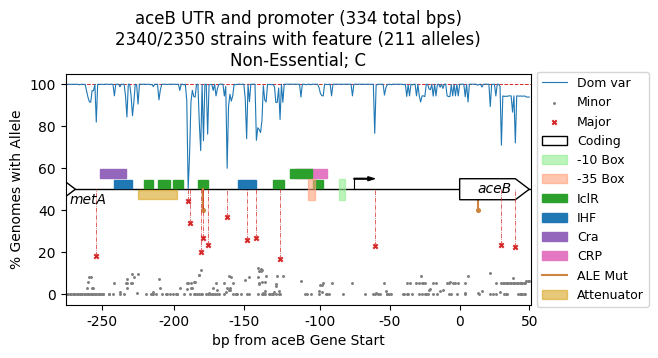

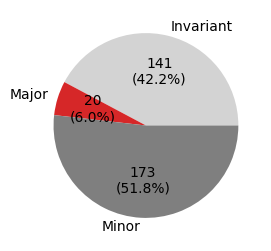

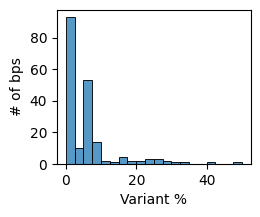

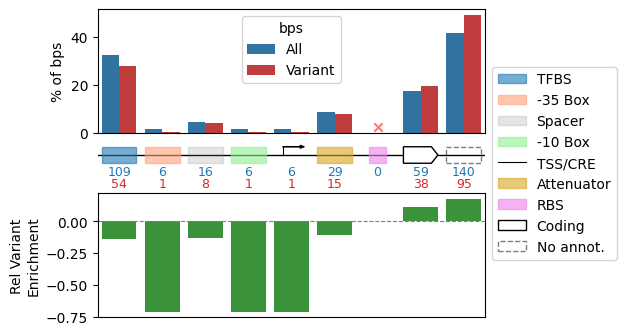

In [91]:
feat_stat_dict, feat_bp_df, feat_stat_df = alleleome_dashboard('TSS_4215402_f__b4014__5utr', plot=True, save_prefix='aceB')

## Bonus Dashboards (Figure 3)

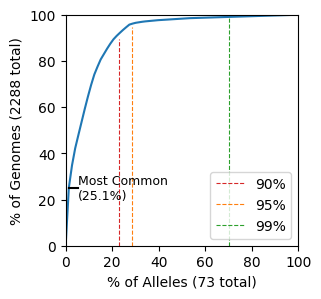

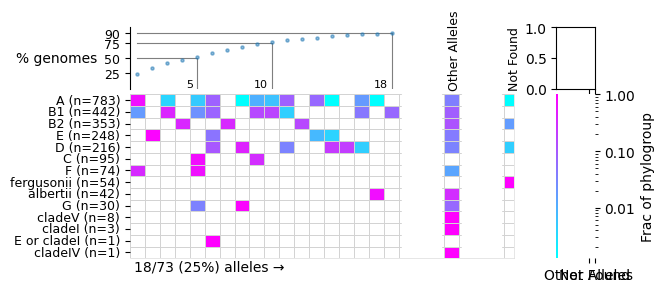

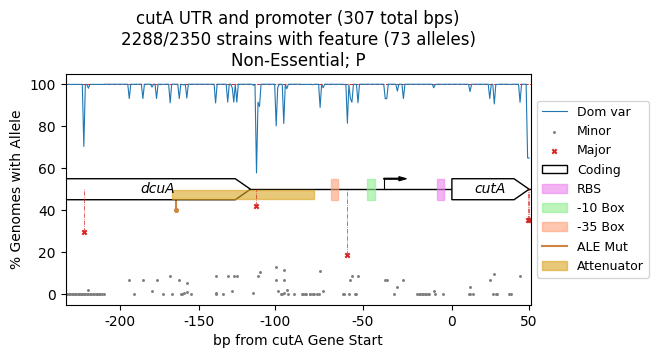

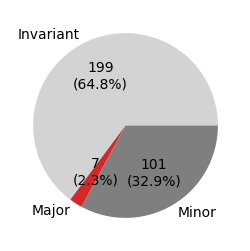

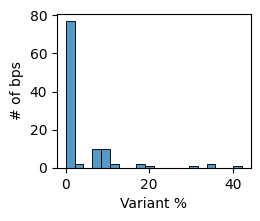

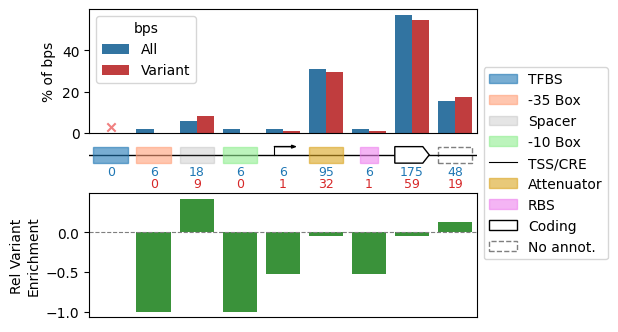

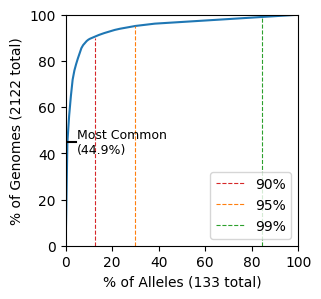

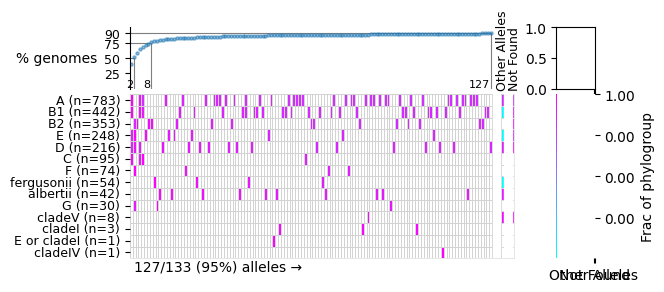

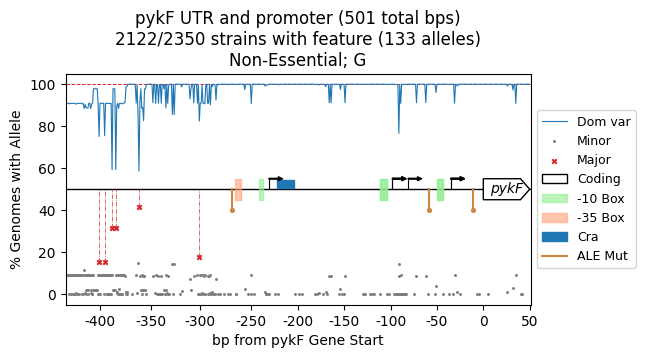

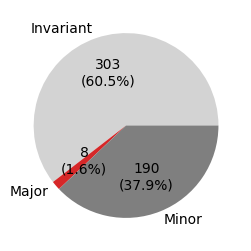

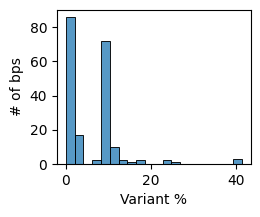

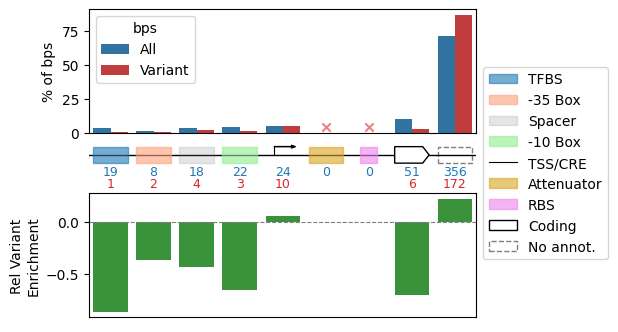

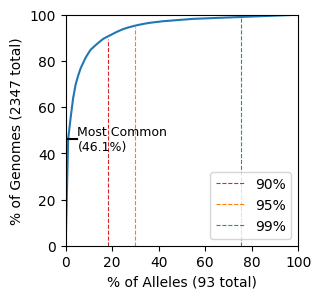

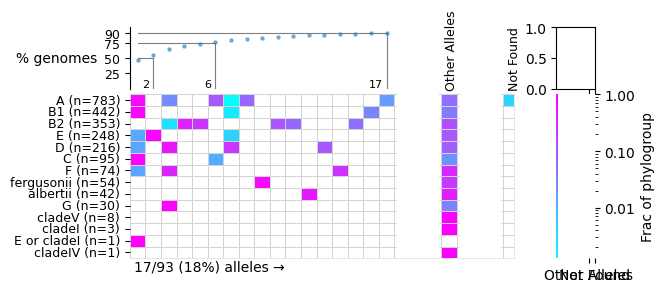

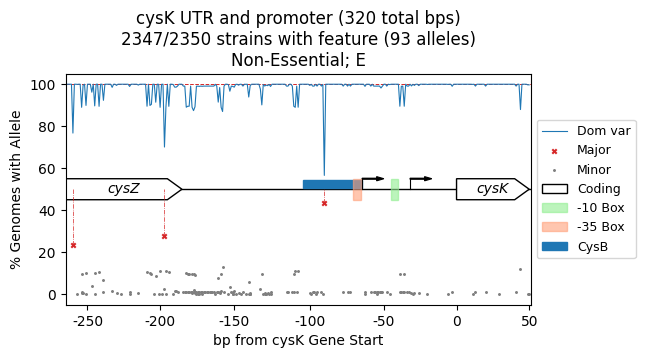

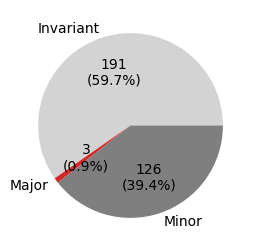

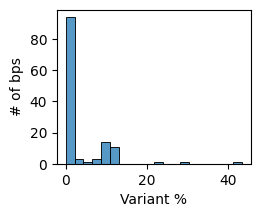

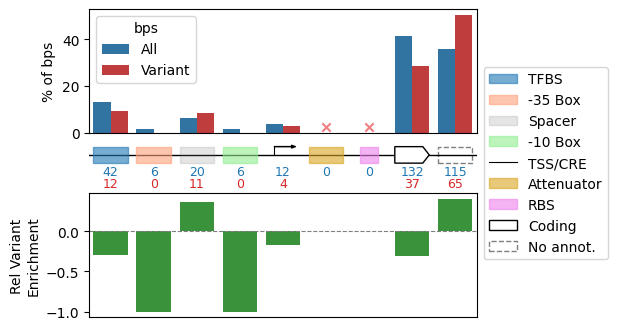

In [92]:
bonus_fids = [feat_ids_to_use[302], feat_ids_to_use[1099], feat_ids_to_use[678]]

for feat_id in bonus_fids: 
    gid = feat_id.split('__')[1]
    feat_stat_dict, feat_bp_df, feat_stat_df = alleleome_dashboard(feat_id, plot=True, save_prefix=f'bonus_{gid}')

# Global Analyses

## Combine All Feature Stats across UTR/Promoters

In [96]:
all_utr_feat_stat_dfs = []
feat_stat_dicts = []
for i, feat_id in enumerate(feat_ids_to_use):
    print(f'{i+1}/{len(feat_ids_to_use)}', end='\r')
    feat_stat_dict, feat_bp_df, feat_stats_df = alleleome_dashboard(feat_id, plot=False)
    feat_stat_dicts.append(feat_stat_dict)
    feat_stats_df = feat_stats_df.assign(
        feat_id=feat_id
    )
    all_utr_feat_stat_dfs.append(feat_stats_df)
utr_overview_df = pd.DataFrame(feat_stat_dicts)
utr_overview_df = utr_overview_df.assign(
    pct_sig_var=(utr_overview_df['n_sig_vars'] / utr_overview_df['n_total_bps'])*100,
    pct_insig_var=(utr_overview_df['n_insig_vars'] / utr_overview_df['n_total_bps'])*100,
    pct_invar=(utr_overview_df['n_invariant_bps'] / utr_overview_df['n_total_bps'])*100
)
all_utr_feat_stat_df = pd.concat(all_utr_feat_stat_dfs)

## Invariant/Variant by UTR

Invariant: 64.9171270718232
Minor: 31.451612903225808
Major: 2.112676056338028


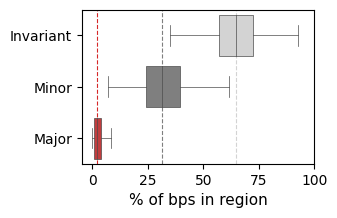

In [97]:
var_pct_rows = []
var_pct_to_nice = {
    'pct_invar': 'Invariant',
    'pct_sig_var': 'Major',
    'pct_insig_var': 'Minor'
}

for _, utr_overview_row in utr_overview_df.iterrows():
    var_pct_rows.extend([
        {'cat': vpnice, 'pct': utr_overview_row[vpcol]}
        for vpcol, vpnice in var_pct_to_nice.items()
    ])
    
var_pct_plot_df = pd.DataFrame(var_pct_rows)

_, ax = plt.subplots(figsize=(3, 2))

ordered_var_col = {
    'Invariant': 'lightgrey',
    'Minor': 'tab:gray',
    'Major': 'tab:red'
}
sns.boxplot(data=var_pct_plot_df, y='cat', x='pct', ax=ax, order=ordered_var_col.keys(), palette=ordered_var_col.values(), orient='h',
           showfliers=False, boxprops={'lw': 0.5}, medianprops={'lw': 0.5}, whiskerprops={'lw': 0.5}, capprops={'lw': 0.5})
ax.tick_params(axis='both', labelsize=10)

ymin, ymax = ax.get_ylim()
ax.set_xlim(right=100)

ax.set_xlabel('% of bps in region', fontsize=11)
ax.set_ylabel('')

for i, (var_cat, col) in enumerate(ordered_var_col.items()):
    median = var_pct_plot_df[var_pct_plot_df['cat'] == var_cat]['pct'].median()
    print(f'{var_cat}: {median}')
    ax.axvline(median, color=col, linestyle='--', lw=0.8, zorder=-10)

plt.savefig(Path(FIG_PATH, f'bp_breakdown_var_violin.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'bp_breakdown_var_violin.png'), dpi = 600, bbox_inches = 'tight')

## % of Alleles to Cover Genomes

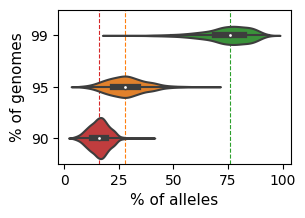

In [98]:
allele_pct_rows = []
allele_pct_cols = sorted([col for col in utr_overview_df.columns if 'allele_pct_' in col])

for _, utr_overview_row in utr_overview_df.iterrows():
    allele_pct_rows.extend([
        {'threshold': int(apcol.split('_')[-1]), 'pct': utr_overview_row[apcol]}
        for apcol in allele_pct_cols
    ])
    
allele_pct_plot_df = pd.DataFrame(allele_pct_rows)

_, ax = plt.subplots(figsize=(3, 2))

thresh_to_col = {
    90: 'tab:red',
    95: 'tab:orange',
    99: 'tab:green'
}
ordered_thresh_col = dict(zip(list(thresh_to_col.keys())[::-1], list(thresh_to_col.values())[::-1]))
sns.violinplot(data=allele_pct_plot_df, y='threshold', x='pct', ax=ax, order=ordered_thresh_col.keys(), palette=ordered_thresh_col.values(), orient='h')

ymin, ymax = ax.get_ylim()

for i, (thresh, col) in enumerate(ordered_thresh_col.items()):
    median = allele_pct_plot_df[allele_pct_plot_df['threshold'] == thresh]['pct'].median()
    ax.axvline(median, color=col, linestyle='--', lw=0.8, zorder=-10)

ax.set_xlabel('% of alleles', fontsize=11)
ax.set_ylabel('% of genomes', fontsize=11)
ax.tick_params(axis='both', labelsize=10)

plt.savefig(Path(FIG_PATH, f'allele_coverage_violin.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'allele_coverage_violin.png'), dpi = 600, bbox_inches = 'tight')

## Genomes Covered by Most Common Allele

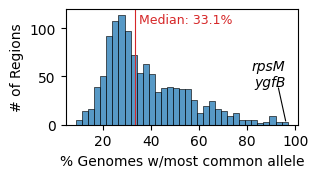

In [99]:
_, ax = plt.subplots(figsize=(3, 1.5))

sns.histplot(utr_overview_df['top_allele_pct'], ax=ax, bins=35)
ax.set_ylabel('# of Regions')
ax.set_xlabel('% Genomes w/most common allele')

ax.text(96, 40, 'rpsM\nygfB', fontstyle='italic', ha='right', fontsize=10)
ax.plot([93, 96], [38, 4], lw=0.8, color='k')
med = np.median(utr_overview_df['top_allele_pct'])
ax.axvline(med, color='tab:red', lw=0.8)
ax.text(med + 2, 105, f'Median: {med:.1f}%', color='tab:red', fontsize=9)

plt.savefig(Path(FIG_PATH, f'common_allele_coverage_hist.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'common_allele_coverage_hist.png'), dpi = 600, bbox_inches = 'tight')

## COG Breakdown

What are the variant percentages in promoters by COG?

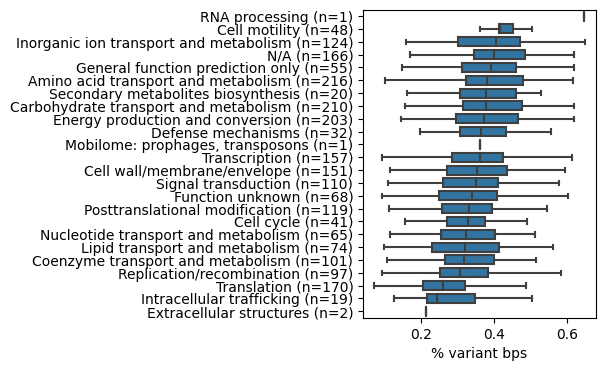

In [101]:
cog_to_var_pcts = {}
genes_seen = []

for _, utr_overview_row in utr_overview_df.iterrows():

    var_pct = utr_overview_row['n_variant_bps'] / utr_overview_row['n_total_bps']
    
    genes = []
    tss_id, gene_id, _ = utr_overview_row['feat_id'].split('__')
    all_tss_df = with_genes[with_genes['first_gene_id'] == gene_id]
    for gid_raw in all_tss_df['gene_ids']:
        gids = gid_raw.split(';')
        genes.extend(gids)
    genes = list(set(genes))
    gene_cogs = mg1655.gene_table.loc[genes]['cog'].fillna('N/A')
    genes_seen.extend(genes)
    for cog in gene_cogs:
        if cog in cog_to_var_pcts:
            cog_to_var_pcts[cog].append(var_pct)
        else:
            cog_to_var_pcts[cog] = [var_pct]
            
cog_var_pct_rows = []
cog_to_counts = {cog: len(pcts) for cog, pcts in cog_to_var_pcts.items()}
for cog, var_pcts in cog_to_var_pcts.items():
    cog_var_pct_rows.extend([
        {'cog': f'{cog_name_lookup.get(cog, cog)} (n={cog_to_counts[cog]})', 'var_pct': var_pct}
        for var_pct in var_pcts
    ])
    
cog_var_pct_df = pd.DataFrame(cog_var_pct_rows)

order, _ = zip(*sorted(
    [(cog, cog_df['var_pct'].median()) for cog, cog_df in cog_var_pct_df.groupby('cog')],
    key=lambda tup: tup[1], reverse=True
))

_, ax = plt.subplots(figsize=(3, 4))

sns.boxplot(data=cog_var_pct_df, y='cog', x='var_pct', order=order,ax=ax, showfliers=False, color='tab:blue', width=0.7)
ax.set_ylabel('')
ax.set_xlabel('% variant bps')

plt.savefig(Path(FIG_PATH, f'cog_variant_box.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'cog_variant_box.png'), dpi = 600, bbox_inches = 'tight')

## Bitome Feature Variant vs Seq Coverage %

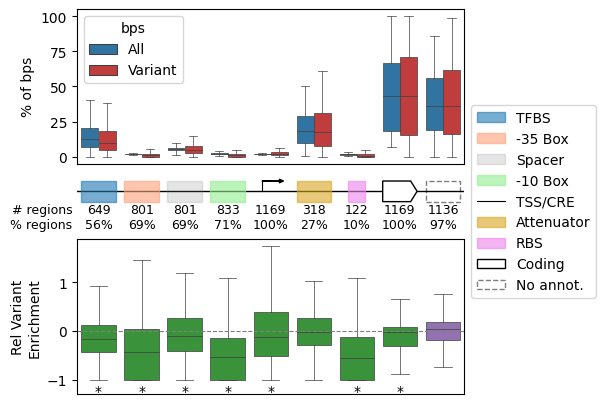

In [102]:
all_utr_plot_stats_rows = []
for _, all_utr_stat_row in all_utr_feat_stat_df.iterrows():
    # only append the row if we actually have any of this feature here
    if all_utr_stat_row['frac_bp_seq'] > 0:
        all_utr_plot_stats_rows.extend([
            {'feat_id': all_utr_stat_row['feat_id'], 'feat_type': all_utr_stat_row['feat_type'],
             'bps': 'Variant', 'value': all_utr_stat_row['frac_bp_var'] * 100},
            {'feat_id': all_utr_stat_row['feat_id'], 'feat_type': all_utr_stat_row['feat_type'],
             'bps': 'All', 'value': all_utr_stat_row['frac_bp_seq'] * 100}
        ])
all_utr_plot_stats_df = pd.DataFrame(all_utr_plot_stats_rows)

_, (ax_bars, ax_diag, ax_diff) = plt.subplots(3, 1, figsize=(5, 5), sharex=True, height_ratios=[3, 1, 3])

sns.boxplot(data=all_utr_plot_stats_df, order=LEFT_TO_RIGHT, x='feat_type', y='value', hue='bps', hue_order=['All', 'Variant'],
            ax=ax_bars, palette=['tab:blue', 'tab:red'], showfliers=False,
           boxprops={'lw':0.5},whiskerprops={'lw':0.5},medianprops={'lw':0.5},capprops={'lw':0.5})
ax_bars.set_xticks([])
ax_bars.set_xlabel('')
ax_bars.set_ylabel('')

ax_bars.set_ylabel('% of bps')

plt.subplots_adjust(wspace=0, hspace=0.1)

ax_diag.axhline(0.7, linewidth=1, color='k', zorder=-10)
for s in ax_diag.spines.values():
    s.set_visible(False)
ax_diag.tick_params(axis='y', length=0)
ax_diag.set_ylim(0, 1)

for i, nice_name in enumerate(LEFT_TO_RIGHT):

    # do a big switch - this will make it easier to turn things on and off or re-shuffle later
    # gene is a bit cute shape
    if nice_name == 'Coding':
        gene_patch = plt_patches.Polygon(
            [[i - 0.4, 0.5], [i + 0.25, 0.5], [i + 0.4, 0.7], [i + 0.25, 0.9], [i - 0.4, 0.9]],
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(gene_patch)

    # make a little TSS arrow for the CRE
    elif nice_name == 'CRE':
        ax_diag.plot([i - 0.2, i - 0.2], [0.7, 0.9], color='k', lw=0.8, label='TSS/CRE')
        ax_diag.arrow(i - 0.2, 0.9, 0.5, 0, color='k', shape='full', width=0.01,
                      head_width=0.075, length_includes_head=True, head_length=0.1, lw=0.8)

    # RBS is a bit less wide
    elif nice_name == 'RBS':
        rbs_patch = plt_patches.Rectangle(
            (i - 0.2, 0.5), 0.4, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(rbs_patch)

    # these things are normal
    elif nice_name in ['Nothing', 'Atten', 'Term', '-10 Box', '-35 Box', 'Spacer', 'TFBS']:
        default_patch = plt_patches.Rectangle(
            (i - 0.4, 0.5), 0.8, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(default_patch)

ax_diag.legend(bbox_to_anchor=(1, 0.5), loc='center left')

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    n_utr_with_feat = all_utr_feat_stat_df[(all_utr_feat_stat_df['feat_type'] == nice_name) & (all_utr_feat_stat_df['n_bp_var'].notna())].shape[0]
    ax_diag.text(i, 0.2, f'{n_utr_with_feat}\n{n_utr_with_feat/len(feat_ids_to_use)*100:.0f}%', fontsize=9, ha='center', va='center')
ax_diag.set_yticks([0.25])
ax_diag.set_yticklabels(['# regions\n% regions'])
ax_diag.tick_params(axis='y', labelsize=9)

pvals = []
nothing_distrib = all_utr_feat_stat_df[all_utr_feat_stat_df['feat_type'] == 'Nothing']['diff_ratio'].dropna()
labs = []
for nice_name in LEFT_TO_RIGHT:
    if nice_name != 'Nothing':
        u, p = mannwhitneyu(nothing_distrib, all_utr_feat_stat_df[all_utr_feat_stat_df['feat_type'] == nice_name]['diff_ratio'].dropna())
        pvals.append(p)
        labs.append(nice_name)
alpha = 0.01
_, p_vals_adj = fdrcorrection(pvals, alpha=alpha)
name_to_padj = dict(zip(labs, p_vals_adj))

# make a new plot stats df that captures the diffs
sns.boxplot(data=all_utr_feat_stat_df, x='feat_type', y='diff_ratio', ax=ax_diff, palette=['tab:green'] * (len(LEFT_TO_RIGHT) - 1) + ['tab:purple'],
            showfliers=False, order=LEFT_TO_RIGHT,boxprops={'lw':0.5},whiskerprops={'lw':0.5},medianprops={'lw':0.5},capprops={'lw':0.5})
ax_diff.set_ylabel('Rel Variant\nEnrichment', fontsize=10)
ax_diff.set_xlabel('')
ax_diff.set_xticks([])
ax_diff.axhline(0, linestyle='--', color='tab:gray', lw=0.8)

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    if nice_name != 'Nothing':
        padj_this = name_to_padj[nice_name]
        if padj_this < alpha:
            ax_diff.text(i, -1.1, '*', va='top', ha='center')
            
ax_diff.set_ylim(bottom=-1.3)

plt.savefig(Path(FIG_PATH, f'bitome_feat_breakdown_all.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'bitome_feat_breakdown_all.png'), dpi = 600, bbox_inches = 'tight')

### Individual Plots by Feature

TFBS -0.1650591627721985
-35 Box -0.4268041237113402
Spacer -0.10575605299223385
-10 Box -0.5391849529780565
CRE -0.11845730027548204
Atten -0.024599061672526186
RBS -0.5466806185327286
Coding -0.026370614035087725
Nothing 0.03292332213021036


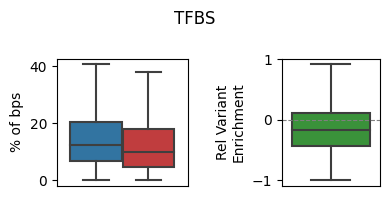

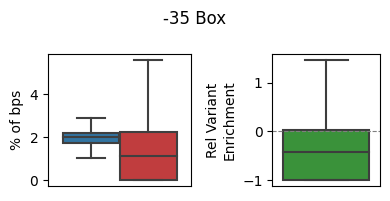

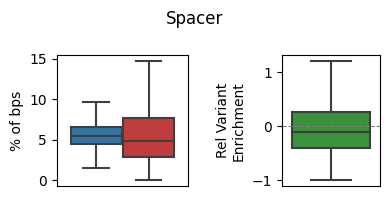

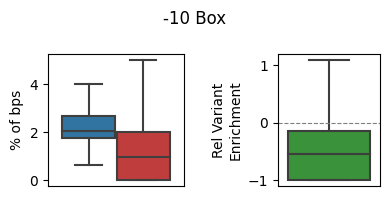

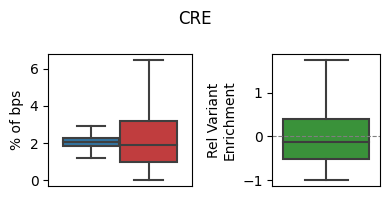

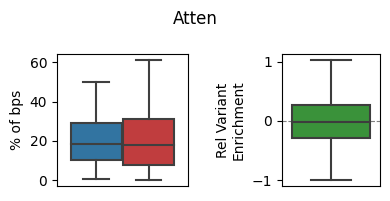

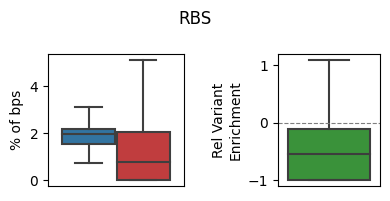

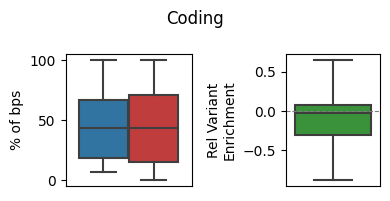

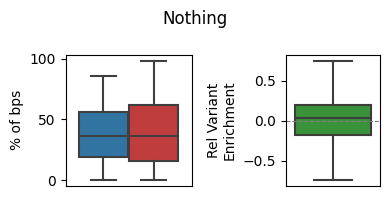

In [103]:
for i, nice_name in enumerate(LEFT_TO_RIGHT):
    
    only_this_feat_plot_df = all_utr_plot_stats_df[all_utr_plot_stats_df['feat_type'] == nice_name]
    
    fig, (ax_bars, ax_diff) = plt.subplots(1, 2, figsize=(4, 2), width_ratios=[2, 1.5])

    sns.boxplot(data=only_this_feat_plot_df, x='feat_type', y='value', hue='bps', hue_order=['All', 'Variant'],
                ax=ax_bars, palette=['tab:blue', 'tab:red'], showfliers=False)
    ax_bars.set_xticks([])
    ax_bars.set_xlabel('')
    ax_bars.set_ylabel('')

    ax_bars.set_ylabel('% of bps')
    ax_bars.legend().set_visible(False)

    ax_diag.axhline(0.7, linewidth=1, color='k', zorder=-10)
    for s in ax_diag.spines.values():
        s.set_visible(False)
    ax_diag.tick_params(axis='y', length=0)
    ax_diag.set_ylim(0, 1)
    ax_diag.set_yticks([])

    # make a new plot stats df that captures the diffs
    only_this_feat_stat_df = all_utr_feat_stat_df[all_utr_feat_stat_df['feat_type'] == nice_name]
    sns.boxplot(data=only_this_feat_stat_df, x='feat_type', y='diff_ratio', ax=ax_diff, color='tab:green', showfliers=False)
    print(nice_name, only_this_feat_stat_df['diff_ratio'].median())
    ax_diff.set_ylabel('Rel Variant\nEnrichment', fontsize=10)
    ax_diff.set_xlabel('')
    ax_diff.set_xticks([])
    ax_diff.axhline(0, linestyle='--', color='tab:gray', lw=0.8)
    
    plt.suptitle(nice_name)
    
    plt.tight_layout()

Make sure to consider synonymous vs non-synonymous when summarizing coding mutations

Rho vs non-rho terminator

Rates across different TFs

## Variant % at Variant bps

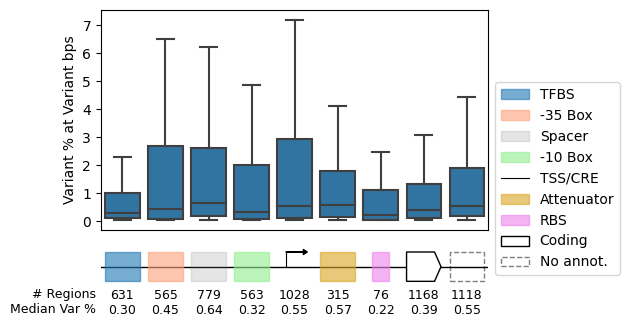

In [104]:
_, (ax_bars, ax_diag) = plt.subplots(2, 1, figsize=(5, 4), sharex=True, height_ratios=[3, 1])

sns.boxplot(data=all_utr_feat_stat_df, order=LEFT_TO_RIGHT, x='feat_type', y='median_var_pct', ax=ax_bars,
              color='tab:blue', showfliers=False)
ax_bars.set_xticks([])
ax_bars.set_xlabel('')
ax_bars.set_ylabel('')
ax_bars.set_yticks(range(8))

ax_bars.set_ylabel('Variant % at Variant bps')

plt.subplots_adjust(wspace=0, hspace=0.1)

ax_diag.axhline(0.7, linewidth=1, color='k', zorder=-10)
for s in ax_diag.spines.values():
    s.set_visible(False)
ax_diag.tick_params(axis='y', length=0)
ax_diag.set_ylim(0, 1)
ax_diag.set_yticks([])

for i, nice_name in enumerate(LEFT_TO_RIGHT):

    # do a big switch - this will make it easier to turn things on and off or re-shuffle later
    # gene is a bit cute shape
    if nice_name == 'Coding':
        gene_patch = plt_patches.Polygon(
            [[i - 0.4, 0.5], [i + 0.25, 0.5], [i + 0.4, 0.7], [i + 0.25, 0.9], [i - 0.4, 0.9]],
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(gene_patch)

    # make a little TSS arrow for the CRE
    elif nice_name == 'CRE':
        ax_diag.plot([i - 0.2, i - 0.2], [0.7, 0.9], color='k', lw=0.8, label='TSS/CRE')
        ax_diag.arrow(i - 0.2, 0.9, 0.5, 0, color='k', shape='full', width=0.01,
                      head_width=0.075, length_includes_head=True, head_length=0.1, lw=0.8)

    # RBS is a bit less wide
    elif nice_name == 'RBS':
        rbs_patch = plt_patches.Rectangle(
            (i - 0.2, 0.5), 0.4, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(rbs_patch)

    # these things are normal
    elif nice_name in ['Nothing', 'Atten', 'Term', '-10 Box', '-35 Box', 'Spacer', 'TFBS']:
        default_patch = plt_patches.Rectangle(
            (i - 0.4, 0.5), 0.8, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(default_patch)

ax_diag.legend(bbox_to_anchor=(1, 1.9), loc='center left')

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    utr_with_feat_df = all_utr_feat_stat_df[(all_utr_feat_stat_df['feat_type'] == nice_name) & (all_utr_feat_stat_df['median_var_pct'].notna())]
    n_utr_with_feat = utr_with_feat_df.shape[0]
    med = utr_with_feat_df['median_var_pct'].median()
    ax_diag.text(i, 0.2, f'{n_utr_with_feat}\n{med:.2f}', fontsize=9, ha='center', va='center')
    
ax_diag.set_yticks([0.25])
ax_diag.set_yticklabels(['# Regions\nMedian Var %'], fontsize=9)

plt.savefig(Path(FIG_PATH, f'var_pct_at_var_bps.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'var_pct_at_var_bps.png'), dpi = 600, bbox_inches = 'tight')

NOTE: these numbers are lower than in the yes/no variant coverage plots because some UTRs have a given feature but 0 variants in that feature, so the median is undefined

## TFBS

In [105]:
in_tfbs = base_pair_df[base_pair_df['in_tfbs_bool']]

# need to identify individual binding sites and separate those out - then can also group by TF
unique_tfbs_full_ids = []
unique_tfs = []
for tfbs_raw in in_tfbs['in_tfbs'].unique():
    tfbs_full_id_list = tfbs_raw.split(';')
    unique_tfbs_full_ids.extend(tfbs_full_id_list)
    unique_tfs.extend([tfbs_full_id.split('__')[1] for tfbs_full_id in tfbs_full_id_list])
unique_tfbs_full_ids = list(set(unique_tfbs_full_ids))
unique_tfs = list(set(unique_tfs))

# now let's get the DF for each unique TFBS
tfbs_full_id_to_var_pcts = {}
tfbs_full_id_info_rows = []
for tfbs_full_id in unique_tfbs_full_ids:
    tfbs_bp_df = in_tfbs[in_tfbs['in_tfbs'].str.contains(tfbs_full_id)]
    # delete opposite strand duplicates
    tfbs_bp_df = tfbs_bp_df.drop_duplicates(subset=['mg_abs_coord'])
    tfbs_full_id_to_var_pcts[tfbs_full_id] = tfbs_bp_df['variant_pct']
    tfbs_full_id_info_rows.append({
        'tfbs_id': tfbs_full_id,
        'feat_ids': ';'.join(tfbs_bp_df['feat_id'].unique()),
        'n_invariant': tfbs_bp_df[tfbs_bp_df['variant_pct'] == 0].shape[0],
        'n_insig_var': tfbs_bp_df[(tfbs_bp_df['variant_pct'] > 0) & (tfbs_bp_df['variant_pct'] <= SIG_THRESHOLD)].shape[0],
        'n_sig_var': tfbs_bp_df[tfbs_bp_df['variant_pct'] > SIG_THRESHOLD].shape[0],
        'tf': tfbs_full_id.split('__')[1],
        'n_total_bps': tfbs_bp_df.shape[0]
    })

tfbs_info_df = pd.DataFrame(tfbs_full_id_info_rows)
tfbs_info_df = tfbs_info_df.assign(
    invar_pct=(tfbs_info_df['n_invariant'] / tfbs_info_df['n_total_bps']) * 100,
    insig_var_pct=(tfbs_info_df['n_insig_var'] / tfbs_info_df['n_total_bps']) * 100,
    sig_var_pct=(tfbs_info_df['n_sig_var'] / tfbs_info_df['n_total_bps']) * 100
)

tf_info_rows = []
for tf, tf_tfbs_info_df in tfbs_info_df.groupby('tf'):
    tf_info_rows.append({
        'tf': tf,
        'n_sites': tf_tfbs_info_df.shape[0],
        'median_invar_pct': tf_tfbs_info_df['invar_pct'].median(),
        'median_insig_var_pct': tf_tfbs_info_df['insig_var_pct'].median(),
        'median_sig_var_pct': tf_tfbs_info_df['sig_var_pct'].median(),
        'min_invar_pct': tf_tfbs_info_df['invar_pct'].min(),
        'max_invar_pct': tf_tfbs_info_df['invar_pct'].max()
    })
    
tf_info_df = pd.DataFrame(tf_info_rows)

### Major Exp Var P1K

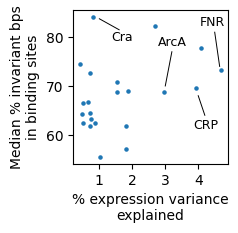

In [107]:
reg_ims = p1k.imodulon_table[p1k.imodulon_table['enrichment_category'] == 'Regulatory'].sort_values(by='exp_var', ascending=False)
total_reg_im_exp_var = reg_ims['exp_var'].sum()
pct_of_reg_var = 0.75

var_thresh = total_reg_im_exp_var * pct_of_reg_var
exp_var_cum_sum = np.cumsum(reg_ims['exp_var'])
var_thresh_idx = min(np.where(exp_var_cum_sum.values > var_thresh)[0])

important_reg_ims = reg_ims.iloc[:var_thresh_idx]

reg_to_exp_var = {}

for _, im_row in important_reg_ims.iterrows():
    reg_raw = im_row['regulator']
    exp_var = im_row['exp_var']
    for reg in re.split(r'\+|/', reg_raw):
        if reg in reg_to_exp_var:
            reg_to_exp_var[reg] += exp_var * 100
        else:
            reg_to_exp_var[reg] = exp_var * 100

# do some modifying
fix_names = {
    'Crp': 'CRP',
    'Fnr': 'FNR'
}
reg_to_exp_var = {fix_names.get(reg, reg): ev for reg, ev in reg_to_exp_var.items()}

maj_exp_var_reg_tfbs_df = tfbs_info_df[tfbs_info_df['tf'].isin(reg_to_exp_var.keys())]

tf_to_site_count = {tf: tf_tfbs_df.shape[0] for tf, tf_tfbs_df in maj_exp_var_reg_tfbs_df.groupby('tf')}
thresh = 10
big_tf_to_count = {tf: ct for tf, ct in tf_to_site_count.items() if ct >= thresh}

only_big_tf = maj_exp_var_reg_tfbs_df[maj_exp_var_reg_tfbs_df['tf'].isin(big_tf_to_count.keys())]
big_tf_to_med_invar = {tf: tf_tfbs_df['invar_pct'].median() for tf, tf_tfbs_df in only_big_tf.groupby('tf')}

_, ax = plt.subplots(figsize=(2, 2))

for tf, tf_tfbs_df in only_big_tf.groupby('tf'):
    med_invar = tf_tfbs_df['invar_pct'].median()
    tf_exp_var = reg_to_exp_var[tf]
    ax.scatter(tf_exp_var, med_invar, color='tab:blue', s=5)
    
ax.set_xticks(range(5))
ax.set_xlabel('% expression variance\nexplained')
ax.set_ylabel('Median % invariant bps\nin binding sites')

ax.text(4.8, 83, 'FNR', ha='right', va='center', fontsize=9)
ax.plot([4.5, 4.65], [81, 74], color='k', lw=0.7)

ax.text(4.6, 62, 'CRP', ha='right', va='center', fontsize=9)
ax.plot([4.2, 4], [64, 68], color='k', lw=0.7)

ax.text(3.2, 79, 'ArcA', ha='center', va='center', fontsize=9)
ax.plot([3.2, 3], [77, 70], color='k', lw=0.7)

ax.text(1.7, 80, 'Cra', ha='center', va='center', fontsize=9)
ax.plot([1.6, 1], [81.5, 83.75], color='k', lw=0.7)

plt.savefig(Path(FIG_PATH, f'tfbs_maj_exp_var_med_invar.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'tfbs_maj_exp_var_med_invar.png'), dpi = 600, bbox_inches = 'tight')

### Variation in Binding Sites

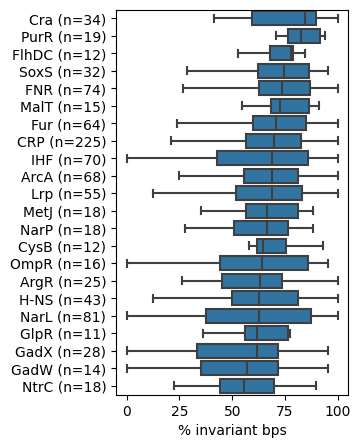

In [108]:
tf_order = sorted(big_tf_to_count.keys(), key=lambda tf: big_tf_to_med_invar[tf], reverse=True)

_, ax = plt.subplots(figsize=(3, 5))

sns.boxplot(data=only_big_tf, x='invar_pct', y='tf', ax=ax, showfliers=False, color='tab:blue', order=tf_order)
ax.set_ylabel('')
ax.set_xlabel('% invariant bps')
ax.set_yticklabels([f"{ylab.get_text()} (n={big_tf_to_count[ylab.get_text()]})" for ylab in ax.get_yticklabels()]);

plt.savefig(Path(FIG_PATH, f'tfbs_invar_box_large.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'tfbs_invar_box_large.png'), dpi = 600, bbox_inches = 'tight')

### CRP Motif vs Examples

In [114]:
seqs = []
with open(Path(DATA_DIR, 'crp_sites_regdb.txt'), 'r') as f:
    for line in f.readlines():
        if line[0] != '>':
            seqs.append(line.strip())
            
logo_mat_crp = logo.alignment_to_matrix(seqs)

/Users/cam/.venv/bitome/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


In [115]:
only_big_tf[
    (only_big_tf['tf'] == 'CRP') &
    (only_big_tf['n_sig_var'] > 2)
]

,tfbs_id,feat_ids,n_invariant,n_insig_var,n_sig_var,tf,n_total_bps,invar_pct,insig_var_pct,sig_var_pct
325,ECK120029481__CRP,TSS_957579_f__b0907__5utr,11,9,3,CRP,23,47.826087,39.130435,13.043478
364,ECK120016826__CRP,TSS_1103344_r__b1040__5utr,10,10,3,CRP,23,43.478261,43.478261,13.043478
501,ECK120011812__CRP,TSS_4611153_f__b4376__5utr,10,10,3,CRP,23,43.478261,43.478261,13.043478
691,ECK120011945__CRP,TSS_4058222_r__b3870__5utr,14,6,3,CRP,23,60.869565,26.086957,13.043478
710,ECK120016034__CRP,TSS_612687_f__b0585__5utr;TSS_612667_r__b0584_...,14,6,4,CRP,24,58.333333,25.000000,16.666667
986,ECK125158215__CRP,TSS_1100252_f__b1036__5utr,7,12,4,CRP,23,30.434783,52.173913,17.391304
1144,ECK120016044__CRP,TSS_987092_r__b0929__5utr,7,11,5,CRP,23,30.434783,47.826087,21.739130
1162,ECK120016828__CRP,TSS_451653_r__b0432__5utr,0,17,4,CRP,21,0.000000,80.952381,19.047619
1354,ECK120011316__CRP,TSS_2868118_r__b2741__5utr,12,7,4,CRP,23,52.173913,30.434783,17.391304
1842,ECK120011947__CRP,TSS_4058222_r__b3870__5utr,14,6,3,CRP,23,60.869565,26.086957,13.043478


In [117]:
high_feat_id, high_site_id = 'TSS_3601003_r__b3461__5utr', 'ECK120012882'
low_feat_id, low_site_id = 'TSS_451653_r__b0432__5utr', 'ECK120016828'

has_tfbs = base_pair_df[base_pair_df['in_tfbs'].notna()]

in_low = has_tfbs[has_tfbs['in_tfbs'].str.contains(low_site_id)]
align_min, align_max = in_low['align_idx'].min(), in_low['align_idx'].max()

low_fid_align_df = feat_id_to_align_df[low_feat_id]

all_seqs = []
for count, a_seq in zip(low_fid_align_df['count'], low_fid_align_df['seq_align']):
    all_seqs.extend([a_seq[align_min:align_max+1]]*count)
    
logo_mat_lowcrp = logo.alignment_to_matrix(all_seqs)

in_high = has_tfbs[has_tfbs['in_tfbs'].str.contains(high_site_id)]
align_min, align_max = in_high['align_idx'].min(), in_high['align_idx'].max()

high_fid_align_df = feat_id_to_align_df[high_feat_id]

all_seqs = []
for count, a_seq in zip(high_fid_align_df['count'], high_fid_align_df['seq_align']):
    all_seqs.extend([a_seq[align_min:align_max+1]]*count)
    
logo_mat_highcrp = logo.alignment_to_matrix(all_seqs)

/Users/cam/.venv/bitome/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T
/Users/cam/.venv/bitome/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


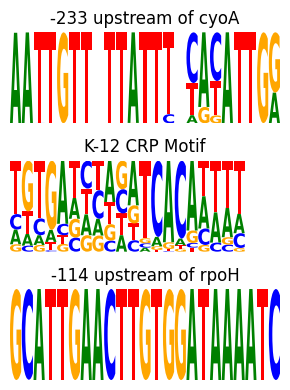

In [121]:
_, (ax_top, ax_mid, ax_bot) = plt.subplots(3, 1, figsize=(3, 4), sharex=True)

logo.Logo(logo_mat_lowcrp, show_spines=False, ax=ax_top)
ax_top.set_title(f"{int(in_low['mg_rel_pos'].mean())} upstream of cyoA")

logo.Logo(logo_mat_crp, show_spines=False, ax=ax_mid)
ax_mid.set_title(f"K-12 CRP Motif")

logo.Logo(logo_mat_highcrp, show_spines=False, ax=ax_bot)
ax_bot.set_title(f"{int(in_high['mg_rel_pos'].mean())} upstream of rpoH")

for ax in [ax_top, ax_mid, ax_bot]:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()

plt.savefig(Path(FIG_PATH, f'crp_sites_example.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'crp_sites_example.png'), dpi = 600, bbox_inches = 'tight')

### Major Regulon Dual Effect

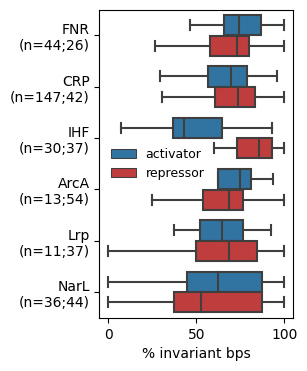

In [122]:
def get_reg_dir(tfbs_id_raw):
    site_id = tfbs_id_raw.split('__')[0]
    funcs = ri_df[ri_df['SITE_ID'] == site_id]['RI_FUNCTION'].unique()
    reg_type = funcs[0] if len(funcs) == 1 else 'dual'
    return reg_type.replace('unknown', 'dual')
    
only_big_tf = only_big_tf.assign(
    effect=only_big_tf['tfbs_id'].apply(get_reg_dir)
)
only_dual_tf = only_big_tf[only_big_tf['effect'].isin(['activator', 'repressor'])]

dual_tf = [tf for tf, tf_tfbs_df in only_big_tf.groupby('tf')
           if tf_tfbs_df['effect'].value_counts().shape[0] >= 2 and tf_tfbs_df['effect'].value_counts().sort_values(ascending=False).iloc[1] > 10]

only_dual_tf = only_big_tf[only_big_tf['tf'].isin(dual_tf)]

tfs = []
praws = []

for tf, tf_tfbs_df in only_dual_tf.groupby('tf'):
    act = tf_tfbs_df[tf_tfbs_df['effect'] == 'activator']['invar_pct']
    rep = tf_tfbs_df[tf_tfbs_df['effect'] == 'repressor']['invar_pct']
    u, p = mannwhitneyu(act, rep)
    praws.append(p)
    tfs.append(tf)
_, p_adjs = fdrcorrection(praws, alpha=0.1)
tf_to_padjs = {tf: padj for tf, padj in zip(tfs, p_adjs)}

_, ax = plt.subplots(figsize=(2.5, 4))

only_dual_order = sorted(only_dual_tf['tf'].unique(), key=lambda dtf: tf_order.index(dtf))

sns.boxplot(data=only_dual_tf, x='invar_pct', y='tf', hue='effect', ax=ax, showfliers=False, hue_order=['activator', 'repressor'],
           order=only_dual_order, palette=['tab:blue', 'tab:red'])
ax.set_ylabel('')
ax.set_xlabel('% invariant bps')
new_ylabs = []
for old_ylab in ax.get_yticklabels():
    act_count = only_dual_tf[
        (only_dual_tf['tf'] == old_ylab.get_text()) & 
        (only_dual_tf['effect'] == 'activator')
    ].shape[0]
    repress_count = only_dual_tf[
        (only_dual_tf['tf'] == old_ylab.get_text()) & 
        (only_dual_tf['effect'] == 'repressor')
    ].shape[0]
    new_ylabs.append(f"{old_ylab.get_text()}\n(n={act_count};{repress_count})")
ax.set_yticklabels(new_ylabs);
ax.legend(fontsize=9, frameon=False, loc='center left')

plt.savefig(Path(FIG_PATH, f'dual_reg_effect.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'dual_reg_effect.png'), dpi = 600, bbox_inches = 'tight')

### Invar Pct vs Regulon Size

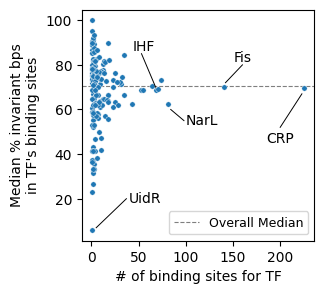

In [479]:
_, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(data=tf_info_df, x='n_sites', y='median_invar_pct', s=15, ax=ax)

ax.axhline(tf_pct_plot_df[tf_pct_plot_df['var_type'] == 'Invariant']['pct'].median(), zorder=-10,
           linestyle='--', label='Overall Median', color='tab:gray', lw=0.8)

ax.text(200, 50, 'CRP', ha='center', va='top')
ax.plot([200, 223], [52, 67], color='k', lw=0.7)

ax.text(160, 80, 'Fis', ha='center', va='bottom')
ax.plot([160, 142], [80, 72], color='k', lw=0.7)

ax.text(100, 55, 'NarL', ha='left', va='center')
ax.plot([98, 84], [55, 60], color='k', lw=0.7)

ax.text(40, 20, 'UidR', ha='left', va='center')
ax.plot([37, 5], [20, 7], color='k', lw=0.7)

ax.text(55, 85, 'IHF', ha='center', va='bottom')
ax.plot([53, 68], [85, 70], color='k', lw=0.7)

ax.set_xlabel('# of binding sites for TF')
ax.set_ylabel("Median % invariant bps\nin TF's binding sites")

ax.legend(loc='lower right', fontsize=9)

plt.savefig(Path(FIG_PATH, f'tfbs_num_sites.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'tfbs_num_sites.png'), dpi = 600, bbox_inches = 'tight')

### Range of Variant Pct

Okay so how much variance is there in terms of conservation within a given TFs set of binding sites?

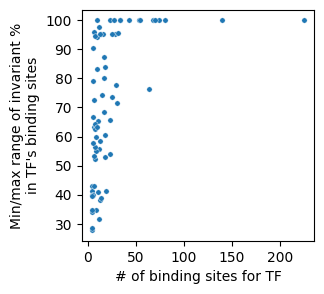

In [2328]:
tf_info_df = tf_info_df.assign(
    invar_pct_range=(tf_info_df['max_invar_pct'] - tf_info_df['min_invar_pct'])
)
with_min_5 = tf_info_df[tf_info_df['n_sites'] >= 5]

_, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(data=with_min_5, x='n_sites', y='invar_pct_range', s=15, ax=ax)

ax.set_xlabel('# of binding sites for TF')
ax.set_ylabel("Min/max range of invariant %\nin TF's binding sites")

plt.savefig(Path(FIG_PATH, f'tfbs_var_range.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'tfbs_var_range.png'), dpi = 600, bbox_inches = 'tight')

### IHF

/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_24142/3260867761.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=detail_tfbs_df, x='invar_pct', y='plot_nice', palette=['tab:blue', 'tab:red', 'tab:green'])


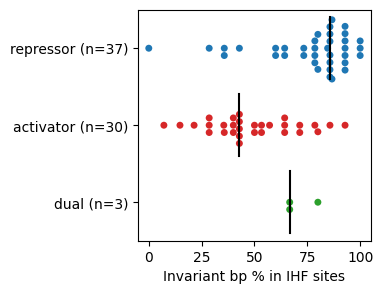

In [2645]:
detail_tfbs_df = tfbs_info_df[tfbs_info_df['tf'] == 'IHF']
detail_tfbs_df = detail_tfbs_df.assign(
    tfbs_only=detail_tfbs_df['tfbs_id'].apply(lambda s: s.split('__')[0])
)
id_to_act_type = {}
for crp_tfbs_id in detail_tfbs_df['tfbs_only']:
    funcs = ri_df[ri_df['SITE_ID'] == crp_tfbs_id]['RI_FUNCTION'].unique()
    reg_type = funcs[0] if len(funcs) == 1 else 'dual'
    id_to_act_type[crp_tfbs_id] = reg_type
    
detail_tfbs_df = detail_tfbs_df.assign(
    reg_type=detail_tfbs_df['tfbs_only'].map(id_to_act_type)
)

reg_type_counts = detail_tfbs_df['reg_type'].value_counts()
detail_tfbs_df = detail_tfbs_df.assign(
    plot_nice=detail_tfbs_df['reg_type'].apply(lambda rt: f'{rt} (n={reg_type_counts[rt]})')
)

_, ax = plt.subplots(figsize=(3, 3))

sns.swarmplot(data=detail_tfbs_df, x='invar_pct', y='plot_nice', palette=['tab:blue', 'tab:red', 'tab:green'])
# plot the mean line
sns.boxplot(medianprops={'color': 'k', 'ls': '-', 'lw': 1.5},
            whiskerprops={'visible': False},
            zorder=5,
            x="invar_pct",
            y="plot_nice",
            data=detail_tfbs_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)
ax.set_xlabel('Invariant bp % in IHF sites')
ax.set_ylabel('')

plt.savefig(Path(FIG_PATH, f'ihf_breakdown.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'ihf_breakdown.png'), dpi = 600, bbox_inches = 'tight')

### iModulons

In [637]:
important_reg_ims.index

Index(['RpoS', 'FlhDC-2', 'FliA', 'ppGpp', 'GadXW', 'Pyrimidine', 'Fnr-3',
       'Fnr-1', 'ArcA', 'Putrescine', 'Lrp', 'Crp-1', 'Copper', 'Zinc-1',
       'Fur-1', 'Fnr-2', 'Thiamine-1', 'Purine', 'Crp-2', 'Arginine',
       'Translation', 'Glycerol', 'Cysteine-1', 'Maltose', 'Methionine',
       'FlhDC-1', 'Fur-2', 'Glycolate', 'gcvB', 'Capsule', 'NtrC-1',
       'Glutamine', 'Rhamnose', 'N Reduction', 'NRZ', 'Fimbriae', 'Propionate',
       'Osmoprotectant', 'SoxS', 'Thr/Ser-1', 'RpoH', 'Cra'],
      dtype='object')

In [662]:
reg_ims[reg_ims['regulator'].str.contains('SoxS')]

,exp_var,imodulon_size,enrichment_category,system_category,functional_category,function,regulator,n_regs,pvalue,qvalue,...,single_gene_dominant_technical,tcs,regulon_discovery,ko,PRECISE 2.0,PRECISE 2.0_pearson,PRECISE 2.0_spearman,PRECISE,PRECISE_pearson,PRECISE_spearman
SoxS,0.004168,117,Regulatory,Stress Responses,Redox Stress,"Superoxide/nitric oxide sensing and removal, p...",SoxS,1.0,1.414130e-43,6.308857e-39,...,False,False,False,False,SoxS,0.977157,0.845601,SoxS,0.746366,0.368721


In [680]:
tf_to_ims = {
    'Fur': ['Fur-1', 'Fur-2'],
    'CRP': ['Crp-1', 'Crp-2'],
    'GadX': ['GadXW'],
    'GadW': ['GadXW'],
    'PurR': ['Pyrimidine', 'Purine'],
    'FNR': ['Fnr-1', 'Fnr-2', 'Fnr-3'],
    'ArcA': ['ArcA'],
    'Lrp': ['Lrp'],
    'ArgR': ['Arginine'],
    'MetJ': ['Methionine'],
    'NtrC': ['NtrC-1', 'NtrC-2', 'NtrC-3', 'Glutamine'],
    'SoxS': ['SoxS'],
    'Cra': ['Cra']
}

/Users/cam/.venv/bitome/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 21.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


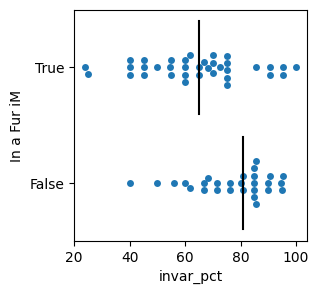

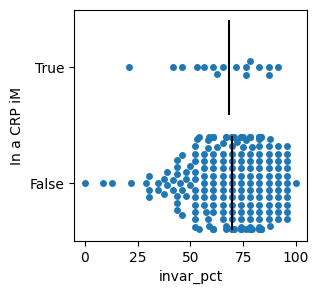

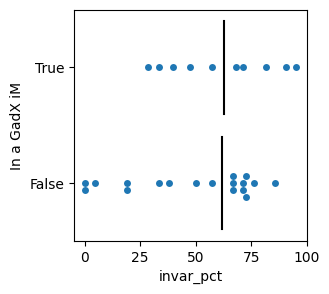

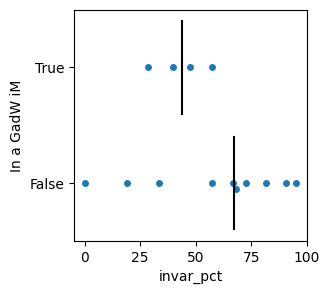

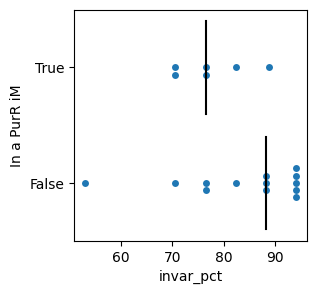

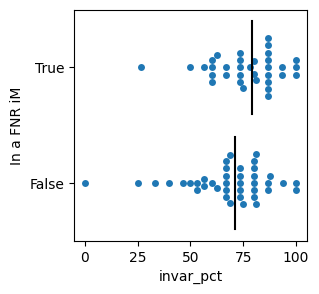

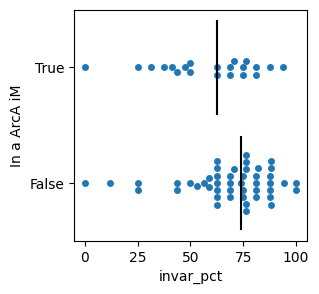

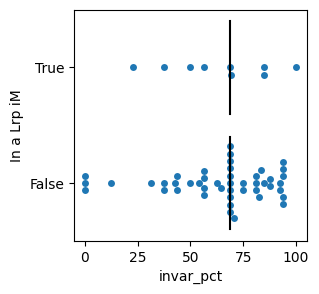

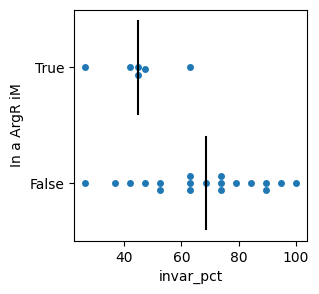

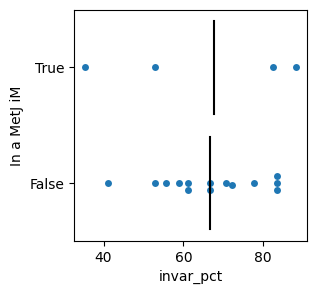

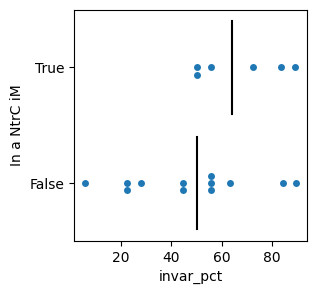

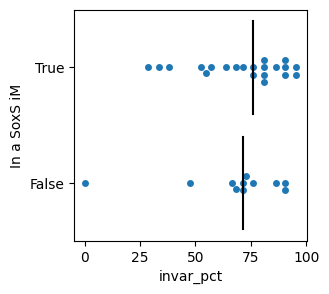

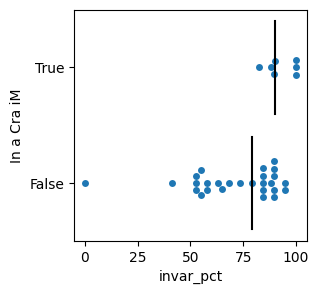

In [682]:
for tf_of_interest, ims_of_interest in tf_to_ims.items():

    crp_tfbs_df = tfbs_info_df[tfbs_info_df['tf'] == tf_of_interest]

    # associate in the regulatory info about this site
    crp_tfbs_df = crp_tfbs_df.assign(
        tfbs_only=crp_tfbs_df['tfbs_id'].apply(lambda s: s.split('__')[0])
    )
    # site info
    crp_ri_df = ri_df[ri_df['T_FACTOR_NAME'] == tf_of_interest]
    crp_reg_interact_df = crp_ri_df.merge(crp_tfbs_df, left_on='SITE_ID', right_on='tfbs_only', how='inner')

    pid_to_crp = {}
    for pid in crp_reg_interact_df['PROMOTER_ID'].unique():
        tss_df = bitome_mg1655_tss_df[bitome_mg1655_tss_df['promoter_id'] == pid]
        genes = []
        for gids_raw in tss_df['gene_ids']:
            if pd.notna(gids_raw):
                genes.extend(gids_raw.split(';'))
        genes = set(genes)
        genes_in_mbinar = list(genes.intersection(p1k.M_binarized.index))
        mbinar_cols = p1k.M_binarized.loc[genes_in_mbinar, ims_of_interest].sum()
        crp_ims = list(mbinar_cols[mbinar_cols == 1].index)
        if crp_ims:
            pid_to_crp[pid] = ';'.join(crp_ims)

    crp_reg_interact_df = crp_reg_interact_df.assign(
        crp_ims=crp_reg_interact_df['PROMOTER_ID'].apply(lambda pid: pid_to_crp.get(pid, 'None'))
    )
    crp_reg_interact_df = crp_reg_interact_df.assign(
        im_bool=(crp_reg_interact_df['crp_ims'] != 'None').apply(str)
    )

    no_dups = crp_reg_interact_df.drop_duplicates(subset='SITE_ID')

    _, ax = plt.subplots(figsize=(3, 3))

    sns.swarmplot(data=no_dups, x='invar_pct', y='im_bool', ax=ax, order=['True', 'False'])
    sns.boxplot(medianprops={'color': 'k', 'ls': '-', 'lw': 1.5},
                whiskerprops={'visible': False},
                zorder=5,
                x="invar_pct",
                y="im_bool",
                data=no_dups,
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=ax, order=['True', 'False'])

    ax.set_ylabel(f'In a {tf_of_interest} iM')

## Coding Overlaps

Best to do this on base-pair basis

In [437]:
coding_overlap_rows = []
special_rows = []
for i, (ftid, feat_id_bp_df) in enumerate(base_pair_df.groupby('feat_id')):
    print(f'{i+1}/1169', end='\r')
    for bool_col, nicename in bool_col_to_nice_name.items():
        if bool_col not in ['in_ale_mut_bool', 'in_nothing_bool', 'in_gene_bool', 'in_tss_bool']:
            feat_id_bool_bp_df = feat_id_bp_df[feat_id_bp_df[bool_col]]
            if not feat_id_bool_bp_df.empty:
                in_coding = feat_id_bool_bp_df[feat_id_bool_bp_df['in_gene_bool']]
                if not in_coding.empty:
                    fracvar_in_coding = (in_coding['variant_pct'] > 0).sum() / in_coding.shape[0]
                    in_code_row = {
                        'feat_type': nicename,
                        'feat_id': ftid,
                        'pctvar': fracvar_in_coding * 100,
                        'incoding': 'Gene overlap'
                    }
                    coding_overlap_rows.append(in_code_row)

                notincoding = feat_id_bool_bp_df[~feat_id_bool_bp_df['in_gene_bool']]
                if not notincoding.empty:
                    fracvar_notin_coding = (notincoding['variant_pct'] > 0).sum() / notincoding.shape[0]
                    notincode_row = {
                        'feat_type': nicename,
                        'feat_id': ftid,
                        'pctvar': fracvar_notin_coding * 100,
                        'incoding': 'No gene overlap'
                    }
                    coding_overlap_rows.append(notincode_row)
                    
                if not notincoding.empty and not in_coding.empty:
                    special_rows.append({
                        'feat_type': nicename,
                        'feat_id': ftid,
                        'diff': (fracvar_notin_coding * 100) - (fracvar_in_coding * 100)
                    })

                
coding_overlap_df = pd.DataFrame(coding_overlap_rows)
special_df = pd.DataFrame(special_rows)

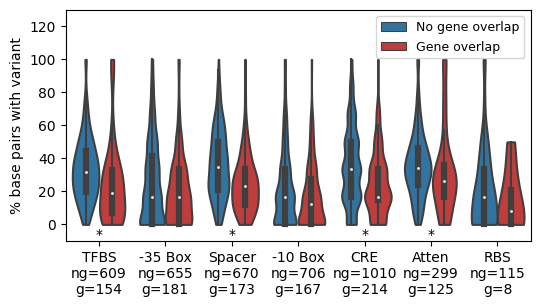

In [438]:
_, ax = plt.subplots(figsize=(6, 3))

upd_order = [l2r for l2r in LEFT_TO_RIGHT if l2r in coding_overlap_df['feat_type'].unique()]

pvals = []
nicey_to_nums = {}
for nicey in upd_order:
    for_nicey = coding_overlap_df[coding_overlap_df['feat_type'] == nicey]
    incoding = for_nicey[for_nicey['incoding'] == 'Gene overlap']['pctvar']
    notincoding = for_nicey[for_nicey['incoding'] == 'No gene overlap']['pctvar']
    nicey_to_nums[nicey] = {incoding.shape[0], notincoding.shape[0]}
    u, p = mannwhitneyu(incoding, notincoding)
    pvals.append(p)
    
alpha = 0.005
_, padjs = fdrcorrection(pvals, alpha=alpha)
nice_to_padj = dict(zip(upd_order, padjs))

sns.violinplot(data=coding_overlap_df, y='pctvar', hue='incoding', x='feat_type',
           palette=['tab:blue', 'tab:red'],
           order=upd_order, ax=ax, cut=0)
ax.set_xlabel('')
ax.set_ylabel('% base pairs with variant')
ax.legend(fontsize=9)
new_xlabs = [
    f"{lab}\nng={coding_overlap_df[coding_overlap_df['feat_type'] == lab]['incoding'].value_counts()['No gene overlap']}"
    f"\ng={coding_overlap_df[coding_overlap_df['feat_type'] == lab]['incoding'].value_counts()['Gene overlap']}"
    for lab in [t.get_text() for t in ax.get_xticklabels()]
]
ax.set_xticklabels(new_xlabs)

for i, nice_name in enumerate(upd_order):
    p_adj = nice_to_padj[nice_name]
    if p_adj < alpha:
        ax.text(i, -2, '*', ha='center', va='top')
        
ax.set_ylim(bottom=-10, top=130)

plt.savefig(Path(FIG_PATH, f'gene_overlap.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'gene_overlap.png'), dpi = 600, bbox_inches = 'tight')

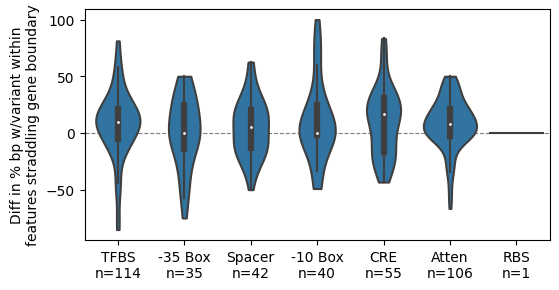

In [449]:
_, ax = plt.subplots(figsize=(6, 3))

sns.violinplot(data=special_df, y='diff', x='feat_type',
           order=upd_order, ax=ax, cut=0, color='tab:blue')
ax.set_xlabel('')
ax.set_ylabel('% base pairs with variant')
new_xlabs = [
    f"{lab}\nn={special_df[special_df['feat_type'] == lab].shape[0]}"
    for lab in [t.get_text() for t in ax.get_xticklabels()]
]
ax.set_xticklabels(new_xlabs)
ax.axhline(0, linestyle='--', zorder=-5, color='tab:gray', lw=0.8)
ax.set_ylabel('Diff in % bp w/variant within\nfeatures straddling gene boundary')

plt.savefig(Path(FIG_PATH, f'gene_overlap_special.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'gene_overlap_special.png'), dpi = 600, bbox_inches = 'tight')

In [475]:
special_df.groupby('feat_type').median()

/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_17126/976813925.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  special_df.groupby('feat_type').median()


,diff
feat_type,
-10 Box,0.000000
-35 Box,0.000000
Atten,7.692641
CRE,16.666667
RBS,0.000000
Spacer,4.932791
TFBS,9.571183


## Essential

### Overall

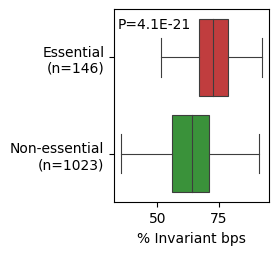

In [72]:
for_ess_plot = utr_overview_df.copy()
for_ess_plot = for_ess_plot.assign(
    essential=for_ess_plot['essential'].apply(lambda essboo: 'Yes' if essboo else 'No')
)

_, ax = plt.subplots(figsize=(2, 2.5))

orderos = ['Yes', 'No']
sns.boxplot(data=for_ess_plot, x='pct_invar', y='essential', ax=ax, showfliers=False,
           whiskerprops={'lw':0.8},capprops={'lw':0.8}, boxprops={'lw':0.8}, medianprops={'lw':0.8},
           order=orderos, palette=['tab:red', 'tab:green'])
ax.set_ylabel('')
ax.set_xlabel('% Invariant bps', fontsize=10)

lab_adj = {'Yes': 'Essential', 'No': 'Non-essential'}
ax.set_yticklabels([f"{lab_adj[lab]}\n(n={for_ess_plot[for_ess_plot['essential'] == lab].shape[0]})" for lab in orderos])

ess_vals = for_ess_plot[for_ess_plot['essential'] == 'Yes']['pct_invar']
noness_vals = for_ess_plot[for_ess_plot['essential'] == 'No']['pct_invar']
u, p = mannwhitneyu(ess_vals, noness_vals)
ax.text(0.02, 0.9, f'P={p:.1E}', transform=ax.transAxes)

plt.savefig(Path(FIG_PATH, f'essential_invar_overall.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'essential_invar_overall.png'), dpi = 600, bbox_inches = 'tight')

### Variant Pct by Bitome

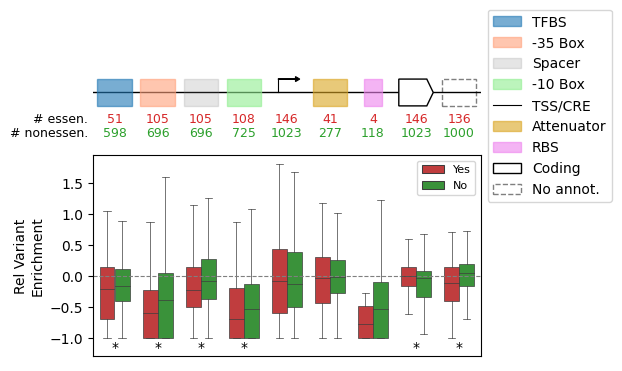

In [233]:
# add in the essential column
def get_essential(feat_id):
    return utr_overview_df[utr_overview_df['feat_id'] == feat_id].iloc[0]['essential']
all_utr_feat_stat_df = all_utr_feat_stat_df.assign(
    essential=all_utr_feat_stat_df['feat_id'].apply(get_essential)
)

all_utr_plot_stats_rows_ess = []
for _, all_utr_stat_row in all_utr_feat_stat_df.iterrows():
    # only want to include this row at all if we have any of this feature
    if all_utr_stat_row['frac_bp_seq'] > 0:
        if all_utr_stat_row['essential']:
            var_stat_row = {'feat_id': feat_id, 'feat_type': all_utr_stat_row['feat_type'],
                            'bps': 'Essential', 'value': all_utr_stat_row['frac_bp_var'] * 100}
        else:
            var_stat_row = {'feat_id': feat_id, 'feat_type': all_utr_stat_row['feat_type'],
                            'bps': 'Non-Essential', 'value': all_utr_stat_row['frac_bp_var'] * 100}
        all_utr_plot_stats_rows_ess.extend([
            var_stat_row,
            {'feat_id': feat_id, 'feat_type': all_utr_stat_row['feat_type'],
             'bps': 'Seq', 'value': all_utr_stat_row['frac_bp_seq'] * 100}
        ])
all_utr_plot_stats_essent_df = pd.DataFrame(all_utr_plot_stats_rows_ess)

ftype_to_p = {}

for feat_type, ft_df in all_utr_feat_stat_df.groupby('feat_type'):
    ess_vals = ft_df[ft_df['essential']]['diff_ratio'].dropna()
    noness_vals = ft_df[~ft_df['essential']]['diff_ratio'].dropna()
    u, p = mannwhitneyu(ess_vals, noness_vals)
    ftype_to_p[feat_type] = p
    
fdr_thresh = 0.1
_, p_adjs = fdrcorrection(list(ftype_to_p.values()), alpha=fdr_thresh)
ftype_to_padj = {}
for feat_type, p_adj in zip(ftype_to_p.keys(), p_adjs):
    ftype_to_padj[feat_type] = p_adj

_, (ax_bars, ax_diag, ax_diff) = plt.subplots(3, 1, figsize=(5, 6.5), sharex=True, height_ratios=[3, 1, 3])

sns.boxplot(data=all_utr_plot_stats_essent_df, order=LEFT_TO_RIGHT, x='feat_type', y='value', hue='bps', hue_order=['Seq', 'Essential', 'Non-Essential'],
            ax=ax_bars, palette=['tab:blue', 'tab:red', 'tab:green'], showfliers=False,
           boxprops={'lw':0.5},whiskerprops={'lw':0.5},medianprops={'lw':0.5},capprops={'lw':0.5})
ax_bars.set_xticks([])
ax_bars.set_xlabel('')
ax_bars.set_ylabel('')

ax_bars.set_ylabel('% of bps')
ax_bars.legend(fontsize=9)

plt.subplots_adjust(wspace=0, hspace=0.1)

ax_diag.axhline(0.7, linewidth=1, color='k', zorder=-10)
for s in ax_diag.spines.values():
    s.set_visible(False)
ax_diag.tick_params(axis='y', length=0)
ax_diag.set_ylim(0, 1)

for i, nice_name in enumerate(LEFT_TO_RIGHT):

    # do a big switch - this will make it easier to turn things on and off or re-shuffle later
    # gene is a bit cute shape
    if nice_name == 'Coding':
        gene_patch = plt_patches.Polygon(
            [[i - 0.4, 0.5], [i + 0.25, 0.5], [i + 0.4, 0.7], [i + 0.25, 0.9], [i - 0.4, 0.9]],
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(gene_patch)

    # make a little TSS arrow for the CRE
    elif nice_name == 'CRE':
        ax_diag.plot([i - 0.2, i - 0.2], [0.7, 0.9], color='k', lw=0.8, label='TSS/CRE')
        ax_diag.arrow(i - 0.2, 0.9, 0.5, 0, color='k', shape='full', width=0.01,
                      head_width=0.075, length_includes_head=True, head_length=0.1, lw=0.8)

    # RBS is a bit less wide
    elif nice_name == 'RBS':
        rbs_patch = plt_patches.Rectangle(
            (i - 0.2, 0.5), 0.4, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(rbs_patch)

    # these things are normal
    elif nice_name in ['Nothing', 'Atten', 'Term', '-10 Box', '-35 Box', 'Spacer', 'TFBS']:
        default_patch = plt_patches.Rectangle(
            (i - 0.4, 0.5), 0.8, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(default_patch)

ax_diag.legend(bbox_to_anchor=(1, 0.5), loc='center left')

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    utr_with_feat = all_utr_feat_stat_df[
        (all_utr_feat_stat_df['feat_type'] == nice_name) &
        (all_utr_feat_stat_df['n_bp_var'].notna())
    ]
    n_utr_with_feat_ess = utr_with_feat['essential'].sum()
    n_utr_with_feat_noness = utr_with_feat.shape[0] - n_utr_with_feat_ess
    ax_diag.text(i, 0.3, n_utr_with_feat_ess, fontsize=9, ha='center', va='center', color='tab:red')
    ax_diag.text(i, 0.1, n_utr_with_feat_noness, fontsize=9, ha='center', va='center', color='tab:green')
ax_diag.set_yticks([0.12, 0.32])
ax_diag.set_yticklabels(['# nonessen.', '# essen.'])
ax_diag.tick_params(axis='y', labelsize=9)

# make a new plot stats df that captures the diffs
sns.boxplot(data=all_utr_feat_stat_df, x='feat_type', y='diff_ratio', ax=ax_diff, hue='essential', hue_order=[True, False],
            palette=['tab:red', 'tab:green'], showfliers=False, width=0.7,
           order=LEFT_TO_RIGHT, boxprops={'lw':0.5},whiskerprops={'lw':0.5},medianprops={'lw':0.5},capprops={'lw':0.5})
ax_diff.set_ylabel('Rel Variant\nEnrichment', fontsize=10)
ax_diff.set_xlabel('')
ax_diff.set_xticks([])
ax_diff.axhline(0, linestyle='--', color='tab:gray', lw=0.8)
hands, labs = ax_diff.get_legend_handles_labels()
ax_diff.legend(handles=hands, labels=[{'True': 'Yes', 'False': 'No'}.get(lb) for lb in labs], loc='upper right', fontsize=8)

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    p_adj = ftype_to_p[nice_name]
    if p_adj < fdr_thresh:
        ax_diff.text(i, -1.05, '*', ha='center', va='top')
        
ax_diff.set_ylim(bottom=-1.3)
        
# toggle for top one
ax_bars.set_visible(False)

plt.savefig(Path(FIG_PATH, f'essential_var_breakdown.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'essential_var_breakdown.png'), dpi = 600, bbox_inches = 'tight')

## Expression

### Median Overall Box

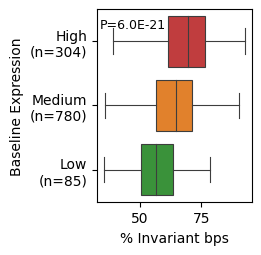

In [73]:
_, ax = plt.subplots(figsize=(2, 2.5))

orderase = ['High', 'Medium', 'Low']
sns.boxplot(data=utr_overview_df, x='pct_invar', y='tpm_median_cat', ax=ax, showfliers=False,
           whiskerprops={'lw':0.8},capprops={'lw':0.8}, boxprops={'lw':0.8}, medianprops={'lw':0.8},
           order=orderase, palette=['tab:red', 'tab:orange', 'tab:green'])
ax.set_ylabel('Baseline Expression', fontsize=10)
ax.set_xlabel('% Invariant bps', fontsize=10)

ax.set_yticklabels([f"{lab}\n(n={utr_overview_df[utr_overview_df['tpm_median_cat'] == lab].shape[0]})" for lab in orderase])

high_vals = utr_overview_df[utr_overview_df['tpm_median_cat'] == 'High']['pct_invar']
med_vals = utr_overview_df[utr_overview_df['tpm_median_cat'] == 'Medium']['pct_invar']
low_vals = utr_overview_df[utr_overview_df['tpm_median_cat'] == 'Low']['pct_invar']
f, p = f_oneway(high_vals, med_vals, low_vals)
ax.text(0.02, 0.9, f'P={p:.1E}', transform=ax.transAxes, fontsize=9)

plt.savefig(Path(FIG_PATH, f'tpm_med_invar_overall.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'tpm_med_invar_overall.png'), dpi = 600, bbox_inches = 'tight')

### Variant Pct Violins and Bars [Median]

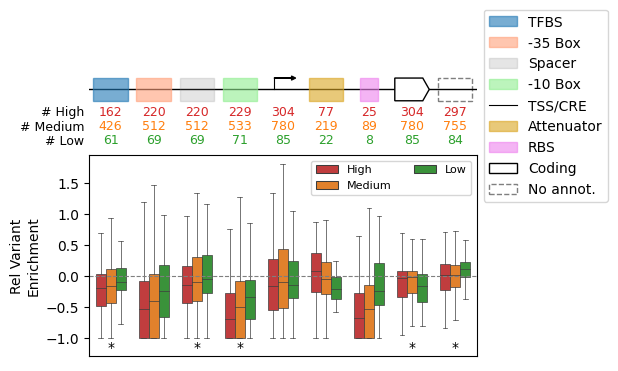

In [234]:
# add in the relevant column
def get_tpm_median_cat(feat_id):
    return utr_overview_df[utr_overview_df['feat_id'] == feat_id].iloc[0]['tpm_median_cat']
all_utr_feat_stat_df = all_utr_feat_stat_df.assign(
    tpm_median_cat=all_utr_feat_stat_df['feat_id'].apply(get_tpm_median_cat)
)

all_utr_plot_stats_rows_tpm_med = []
for _, all_utr_stat_row in all_utr_feat_stat_df.iterrows():
    # only want to include this row at all if we have any of this feature
    if all_utr_stat_row['frac_bp_seq'] > 0:
        all_utr_plot_stats_rows_tpm_med.extend([
            {'feat_id': feat_id, 'feat_type': all_utr_stat_row['feat_type'],
                'bps': all_utr_stat_row['tpm_median_cat'], 'value': all_utr_stat_row['frac_bp_var'] * 100},
            {'feat_id': feat_id, 'feat_type': all_utr_stat_row['feat_type'],
             'bps': 'Seq', 'value': all_utr_stat_row['frac_bp_seq'] * 100}
        ])
all_utr_plot_stats_tpm_med_df = pd.DataFrame(all_utr_plot_stats_rows_tpm_med)

ftype_to_p = {}

for feat_type, ft_df in all_utr_feat_stat_df.groupby('feat_type'):
    groups = [med_cat_df['diff_ratio'].dropna() for _, med_cat_df in ft_df.groupby('tpm_median_cat')]
    f, p = f_oneway(*groups)
    ftype_to_p[feat_type] = p
    
fdr_thresh = 0.1
_, p_adjs = fdrcorrection(list(ftype_to_p.values()), alpha=fdr_thresh)
ftype_to_padj = {}
for feat_type, p_adj in zip(ftype_to_p.keys(), p_adjs):
    ftype_to_padj[feat_type] = p_adj

_, (ax_bars, ax_diag, ax_diff) = plt.subplots(3, 1, figsize=(5, 6.5), sharex=True, height_ratios=[3, 1, 3])

sns.boxplot(data=all_utr_plot_stats_tpm_med_df, order=LEFT_TO_RIGHT, x='feat_type', y='value', hue='bps', hue_order=['Seq', 'High', 'Medium', 'Low'],
            ax=ax_bars, palette=['tab:blue', 'tab:red', 'tab:orange', 'tab:green'], showfliers=False,
           boxprops={'lw':0.5},whiskerprops={'lw':0.5},medianprops={'lw':0.5},capprops={'lw':0.5})
ax_bars.set_xticks([])
ax_bars.set_xlabel('')
ax_bars.set_ylabel('')

ax_bars.set_ylabel('% of bps')
ax_bars.legend(fontsize=9)

plt.subplots_adjust(wspace=0, hspace=0.1)

ax_diag.axhline(0.7, linewidth=1, color='k', zorder=-10)
for s in ax_diag.spines.values():
    s.set_visible(False)
ax_diag.tick_params(axis='y', length=0)
ax_diag.set_ylim(0, 1)

for i, nice_name in enumerate(LEFT_TO_RIGHT):

    # do a big switch - this will make it easier to turn things on and off or re-shuffle later
    # gene is a bit cute shape
    if nice_name == 'Coding':
        gene_patch = plt_patches.Polygon(
            [[i - 0.4, 0.5], [i + 0.25, 0.5], [i + 0.4, 0.7], [i + 0.25, 0.9], [i - 0.4, 0.9]],
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(gene_patch)

    # make a little TSS arrow for the CRE
    elif nice_name == 'CRE':
        ax_diag.plot([i - 0.2, i - 0.2], [0.7, 0.9], color='k', lw=0.8, label='TSS/CRE')
        ax_diag.arrow(i - 0.2, 0.9, 0.5, 0, color='k', shape='full', width=0.01,
                      head_width=0.075, length_includes_head=True, head_length=0.1, lw=0.8)

    # RBS is a bit less wide
    elif nice_name == 'RBS':
        rbs_patch = plt_patches.Rectangle(
            (i - 0.2, 0.5), 0.4, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(rbs_patch)

    # these things are normal
    elif nice_name in ['Nothing', 'Atten', 'Term', '-10 Box', '-35 Box', 'Spacer', 'TFBS']:
        default_patch = plt_patches.Rectangle(
            (i - 0.4, 0.5), 0.8, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(default_patch)

ax_diag.legend(bbox_to_anchor=(1, 0.5), loc='center left')

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    utr_with_feat = all_utr_feat_stat_df[
        (all_utr_feat_stat_df['feat_type'] == nice_name) &
        (all_utr_feat_stat_df['n_bp_var'].notna())
    ]
    feat_to_counts = utr_with_feat['tpm_median_cat'].value_counts()
    for spot, cat_name, col in zip([0.3, 0.05, -0.2], ['High', 'Medium', 'Low'], ['tab:red', 'tab:orange', 'tab:green']):
        ax_diag.text(i, spot, feat_to_counts[cat_name], fontsize=9, ha='center', va='center', color=col)
ax_diag.set_yticks([-0.18, 0.07, 0.32])
ax_diag.set_yticklabels([f'# {cat_name}' for cat_name in ['Low', 'Medium', 'High']])
ax_diag.tick_params(axis='y', labelsize=9)

# make a new plot stats df that captures the diffs
sns.boxplot(data=all_utr_feat_stat_df, x='feat_type', y='diff_ratio', ax=ax_diff, hue='tpm_median_cat', hue_order=['High', 'Medium', 'Low'],
            palette=['tab:red', 'tab:orange', 'tab:green'], showfliers=False, width=0.7,
           order=LEFT_TO_RIGHT,boxprops={'lw':0.5},whiskerprops={'lw':0.5},medianprops={'lw':0.5},capprops={'lw':0.5})
ax_diff.set_ylabel('Rel Variant\nEnrichment', fontsize=10)
ax_diff.set_xlabel('')
ax_diff.set_xticks([])
ax_diff.axhline(0, linestyle='--', color='tab:gray', lw=0.8)
ax_diff.legend(loc='upper right', fontsize=8, ncols=2)

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    p_adj = ftype_to_p[nice_name]
    if p_adj < fdr_thresh:
        ax_diff.text(i, -1.05, '*', ha='center', va='top')
        
ax_diff.set_ylim(bottom=-1.3)
        
ax_bars.set_visible(False)

plt.savefig(Path(FIG_PATH, f'tpm_median_var_breakdown.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'tpm_median_var_breakdown.png'), dpi = 600, bbox_inches = 'tight')

### Variant Pct Violins and Bars [MAD]

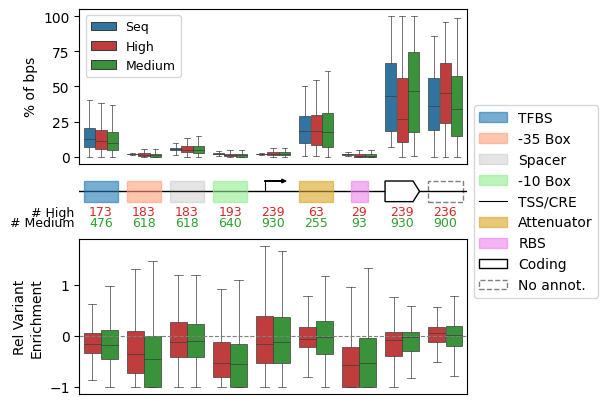

In [235]:
# add in the relevant column
def get_tpm_mad_cat(feat_id):
    return utr_overview_df[utr_overview_df['feat_id'] == feat_id].iloc[0]['tpm_mad_cat']
all_utr_feat_stat_df = all_utr_feat_stat_df.assign(
    tpm_mad_cat=all_utr_feat_stat_df['feat_id'].apply(get_tpm_mad_cat)
)

all_utr_plot_stats_rows_tpm_var = []
for _, all_utr_stat_row in all_utr_feat_stat_df.iterrows():
    # only want to include this row at all if we have any of this feature
    if all_utr_stat_row['frac_bp_seq'] > 0:
        all_utr_plot_stats_rows_tpm_var.extend([
            {'feat_id': feat_id, 'feat_type': all_utr_stat_row['feat_type'],
                'bps': all_utr_stat_row['tpm_mad_cat'], 'value': all_utr_stat_row['frac_bp_var'] * 100},
            {'feat_id': feat_id, 'feat_type': all_utr_stat_row['feat_type'],
             'bps': 'Seq', 'value': all_utr_stat_row['frac_bp_seq'] * 100}
        ])
all_utr_plot_stats_tpm_var_df = pd.DataFrame(all_utr_plot_stats_rows_tpm_var)

_, (ax_bars, ax_diag, ax_diff) = plt.subplots(3, 1, figsize=(5, 5), sharex=True, height_ratios=[3, 1, 3])

sns.boxplot(data=all_utr_plot_stats_tpm_var_df, order=LEFT_TO_RIGHT, x='feat_type', y='value', hue='bps', hue_order=['Seq', 'High', 'Medium'],
            ax=ax_bars, palette=['tab:blue', 'tab:red', 'tab:green'], showfliers=False,
           boxprops={'lw':0.5},whiskerprops={'lw':0.5},medianprops={'lw':0.5},capprops={'lw':0.5})
ax_bars.set_xticks([])
ax_bars.set_xlabel('')
ax_bars.set_ylabel('')

ax_bars.set_ylabel('% of bps')
ax_bars.legend(fontsize=9)

plt.subplots_adjust(wspace=0, hspace=0.1)

ax_diag.axhline(0.7, linewidth=1, color='k', zorder=-10)
for s in ax_diag.spines.values():
    s.set_visible(False)
ax_diag.tick_params(axis='y', length=0)
ax_diag.set_ylim(0, 1)

for i, nice_name in enumerate(LEFT_TO_RIGHT):

    # do a big switch - this will make it easier to turn things on and off or re-shuffle later
    # gene is a bit cute shape
    if nice_name == 'Coding':
        gene_patch = plt_patches.Polygon(
            [[i - 0.4, 0.5], [i + 0.25, 0.5], [i + 0.4, 0.7], [i + 0.25, 0.9], [i - 0.4, 0.9]],
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(gene_patch)

    # make a little TSS arrow for the CRE
    elif nice_name == 'CRE':
        ax_diag.plot([i - 0.2, i - 0.2], [0.7, 0.9], color='k', lw=0.8, label='TSS/CRE')
        ax_diag.arrow(i - 0.2, 0.9, 0.5, 0, color='k', shape='full', width=0.01,
                      head_width=0.075, length_includes_head=True, head_length=0.1, lw=0.8)

    # RBS is a bit less wide
    elif nice_name == 'RBS':
        rbs_patch = plt_patches.Rectangle(
            (i - 0.2, 0.5), 0.4, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(rbs_patch)

    # these things are normal
    elif nice_name in ['Nothing', 'Atten', 'Term', '-10 Box', '-35 Box', 'Spacer', 'TFBS']:
        default_patch = plt_patches.Rectangle(
            (i - 0.4, 0.5), 0.8, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(default_patch)

ax_diag.legend(bbox_to_anchor=(1, 0.5), loc='center left')

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    utr_with_feat = all_utr_feat_stat_df[
        (all_utr_feat_stat_df['feat_type'] == nice_name) &
        (all_utr_feat_stat_df['n_bp_var'].notna())
    ]
    feat_to_counts = utr_with_feat['tpm_mad_cat'].value_counts()
    for spot, cat_name, col in zip([0.3, 0.1], ['High', 'Medium'], ['tab:red', 'tab:green']):
        ax_diag.text(i, spot, feat_to_counts[cat_name], fontsize=9, ha='center', va='center', color=col)
ax_diag.set_yticks([0.12, 0.32])
ax_diag.set_yticklabels([f'# {cat_name}' for cat_name in ['Medium', 'High']])
ax_diag.tick_params(axis='y', labelsize=9)

# make a new plot stats df that captures the diffs
sns.boxplot(data=all_utr_feat_stat_df, x='feat_type', y='diff_ratio', ax=ax_diff, hue='tpm_mad_cat', hue_order=['High', 'Medium'],
            palette=['tab:red', 'tab:green'], showfliers=False,
           order=LEFT_TO_RIGHT,boxprops={'lw':0.5},whiskerprops={'lw':0.5},medianprops={'lw':0.5},capprops={'lw':0.5})
ax_diff.set_ylabel('Rel Variant\nEnrichment', fontsize=10)
ax_diff.set_xlabel('')
ax_diff.set_xticks([])
ax_diff.axhline(0, linestyle='--', color='tab:gray', lw=0.8)
ax_diff.legend().set_visible(False)

plt.savefig(Path(FIG_PATH, f'tpm_mad_var_breakdown.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'tpm_mad_var_breakdown.png'), dpi = 600, bbox_inches = 'tight')

## ALE Mutations

Now we want to more specifically compare ALE mutation locations to natural sequence variant locations

### ALE vs WT Distribution across Bitome Features

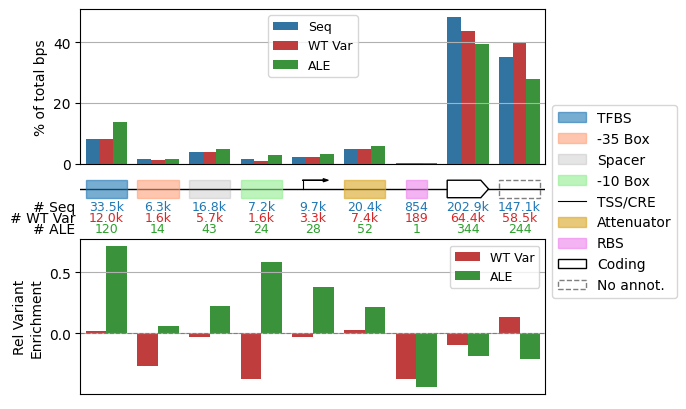

In [505]:
ale_v_nat_rows = []

# have to be careful when computing fraction of ALE muts in each bucket
# because there are overlaps
ale_mut_bp_df = base_pair_df[base_pair_df['in_ale_mut_bool']]
n_total_ale_muts = ale_mut_bp_df.shape[0]

ale_bp_counts = ale_mut_bp_df[in_bool_cols].sum()
total_ale_mut_count = ale_bp_counts.loc['in_ale_mut_bool']
ale_bp_counts = ale_bp_counts.drop(index='in_ale_mut_bool')

ale_bp_counts['in_nothing_bool'] = total_ale_mut_count - ale_bp_counts.sum()
ale_v_nat_rows.extend(
    [{'feat': bool_col_to_nice_name[k], 'pct': v / n_total_ale_muts * 100, 'group': 'ALE', 'count': v} for k, v in ale_bp_counts.items()])

variant_bp_df = base_pair_df[base_pair_df['variant_pct'] > 0]
total_variant_bp = variant_bp_df.shape[0]
variant_count_by_bool = variant_bp_df[in_bool_cols].sum()
variant_count_by_bool['in_nothing_bool'] += variant_count_by_bool['in_ale_mut_bool']
variant_count_by_bool = variant_count_by_bool.drop(index='in_ale_mut_bool')
ale_v_nat_rows.extend(
    [{'feat': bool_col_to_nice_name[k], 'pct': v / total_variant_bp * 100, 'group': 'WT Var', 'count': v} for k, v in variant_count_by_bool.items()])

ale_v_nat_df = pd.DataFrame(ale_v_nat_rows)

total_bps = base_pair_df.shape[0]

new_rows = []
for nice_feat_name in ale_v_nat_df['feat'].unique():
    feat_bp_df = base_pair_df[base_pair_df[nice_to_bool[nice_feat_name]]]
    n_bp_with_feat = feat_bp_df.shape[0]
    new_rows.append({
        'feat': nice_feat_name, 'group': 'Seq',
        'count': n_bp_with_feat, 'pct': n_bp_with_feat / total_bps * 100
    })

new_seq_df = pd.DataFrame(new_rows)
ale_v_nat_df = pd.concat([ale_v_nat_df, new_seq_df])

_, (ax, ax_diag, ax_diff) = plt.subplots(3, 1, figsize=(6, 5), sharex=True, height_ratios=[3, 1, 3])

ax.set_xticks(range(len(LEFT_TO_RIGHT)))
ax.set_xlim(-0.5, len(LEFT_TO_RIGHT))

sns.barplot(data=ale_v_nat_df, x='feat', y='pct', hue='group', ax=ax, palette=['tab:blue', 'tab:red', 'tab:green'],
           hue_order=['Seq', 'WT Var', 'ALE'], order=LEFT_TO_RIGHT)
ax.set_ylabel('% of total bps')
ax.set_xlabel('')
ax.set_xticks([])
ax.legend(loc='upper center', fontsize=9)
ax.grid(axis='y')

plt.subplots_adjust(wspace=0, hspace=0.1)

ax_diag.axhline(0.7, linewidth=1, color='k', zorder=-10)
for s in ax_diag.spines.values():
    s.set_visible(False)
ax_diag.tick_params(axis='y', length=0)
ax_diag.set_ylim(0, 1)

for i, nice_name in enumerate(LEFT_TO_RIGHT):

    # do a big switch - this will make it easier to turn things on and off or re-shuffle later
    # gene is a bit cute shape
    if nice_name == 'Coding':
        gene_patch = plt_patches.Polygon(
            [[i - 0.4, 0.5], [i + 0.25, 0.5], [i + 0.4, 0.7], [i + 0.25, 0.9], [i - 0.4, 0.9]],
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(gene_patch)

    # make a little TSS arrow for the CRE
    elif nice_name == 'CRE':
        ax_diag.plot([i - 0.2, i - 0.2], [0.7, 0.9], color='k', lw=0.8, label='TSS/CRE')
        ax_diag.arrow(i - 0.2, 0.9, 0.5, 0, color='k', shape='full', width=0.01,
                      head_width=0.075, length_includes_head=True, head_length=0.1, lw=0.8)

    # RBS is a bit less wide
    elif nice_name == 'RBS':
        rbs_patch = plt_patches.Rectangle(
            (i - 0.2, 0.5), 0.4, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(rbs_patch)

    # these things are normal
    elif nice_name in ['Nothing', 'Atten', 'Term', '-10 Box', '-35 Box', 'Spacer', 'TFBS']:
        default_patch = plt_patches.Rectangle(
            (i - 0.4, 0.5), 0.8, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(default_patch)

ax_diag.legend(bbox_to_anchor=(1, 0.5), loc='center left')

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    ale_v_nat_df_for_name = ale_v_nat_df[ale_v_nat_df['feat'] == nice_name]
    feat_to_counts = dict(zip(ale_v_nat_df_for_name['group'], ale_v_nat_df_for_name['count']))
    for spot, cat_name, col in zip([0.3, 0.05, -0.2], ['Seq', 'WT Var', 'ALE'], ['tab:blue', 'tab:red', 'tab:green']):
        raw_count = feat_to_counts[cat_name]
        if raw_count < 1000:
            format_txt = raw_count
        else:
            format_txt = f"{raw_count // 1000}.{(raw_count % 1000) // 100}k"
        ax_diag.text(i, spot, format_txt, fontsize=9, ha='center', va='center', color=col)
ax_diag.set_yticks([-0.18, 0.07, 0.32])
ax_diag.set_yticklabels([f'# {cat_name}' for cat_name in ['ALE', 'WT Var', 'Seq']])

seq_df = ale_v_nat_df[ale_v_nat_df['group'] == 'Seq'].sort_values(by='feat')
diff_dfs = []
for thing in ['WT Var', 'ALE']:
    
    group_df =  ale_v_nat_df[ale_v_nat_df['group'] == thing].sort_values(by='feat')
    group_df = group_df.assign(
        diff_ratio=(group_df['pct'].values - seq_df['pct'].values) / seq_df['pct'].values
    )
    diff_dfs.append(group_df)
ale_diff_df = pd.concat(diff_dfs)

sns.barplot(data=ale_diff_df, x='feat', y='diff_ratio', ax=ax_diff, hue='group', hue_order=['WT Var', 'ALE'],
            palette=['tab:red', 'tab:green'], order=LEFT_TO_RIGHT)
ax_diff.set_ylabel('Rel Variant\nEnrichment', fontsize=10)
ax_diff.set_xlabel('')
ax_diff.set_xticks([])
ax_diff.axhline(0, linestyle='--', color='tab:gray', lw=0.8)
ax_diff.legend(loc='upper right', fontsize=9)
ax_diff.grid(axis='y')

plt.savefig(Path(FIG_PATH, f'ale_v_wt_var_bitome.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'ale_v_wt_var_bitome.png'), dpi = 600, bbox_inches = 'tight')

#### Investigating -10/-35 Box Muts

In [130]:
ale_b10_bp_df = ale_mut_bp_df[ale_mut_bp_df['in_b10_bool']]
ale_b10_mut_ids = [int(ale_id) for ale_id in ale_b10_bp_df['in_ale_mut'].unique()]
ale_b10_mut_df = ale_muts_df.loc[ale_b10_mut_ids]
ale_b10_mut_df_snp = ale_b10_mut_df[ale_b10_mut_df['Mutation Type'] == 'SNP']

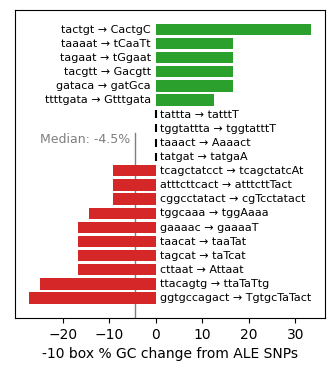

In [131]:
comp_base = {
    'A': 'T',
    'G': 'C',
    'C': 'G',
    'T': 'A'
}

ale_b10_bp_df = ale_mut_bp_df[ale_mut_bp_df['in_b10_bool']]
ale_b10_mut_ids = [int(ale_id) for ale_id in ale_b10_bp_df['in_ale_mut'].unique()]
ale_b10_mut_df = ale_muts_df.loc[ale_b10_mut_ids]
ale_b10_mut_df_snp = ale_b10_mut_df[ale_b10_mut_df['Mutation Type'] == 'SNP']
wt_to_muts_b10 = {}

for mut_id_int, mut_row in ale_b10_mut_df_snp.iterrows():

    base_wt, _, base_mut = tuple(mut_row['Sequence Change'])

    ale_b10_bp_df_for_mut = ale_b10_bp_df[ale_b10_bp_df['in_ale_mut'] == str(mut_id_int)]
    b10s_in = []
    for b10_raw in ale_b10_bp_df_for_mut['in_b10']:
        b10s_in.extend(b10_raw.split(';'))
    b10s_in = list(set(b10s_in))
    for b10_tss_id in b10s_in:
        b10_tss_row = bitome_mg1655_tss_df.loc[b10_tss_id]
        b10_l, b10_r = map(int, b10_tss_row[['box_10_left', 'box_10_right']])
        b10_wt = str(mg1655.get_sequence(b10_l, b10_r, b10_tss_row['strand']))
        if b10_tss_row['strand'] == 1:
            range_loop = range(b10_l, b10_r + 1)
        else:
            range_loop = range(b10_r, b10_l - 1, -1)
        b10_mut_seq = []
        if b10_wt in wt_to_muts_b10:
            b10_to_mod = wt_to_muts_b10[b10_wt]
        else:
            b10_to_mod = b10_wt
        for b10_wt_base, b10_abs_pos in zip(b10_to_mod, range_loop):
            if b10_abs_pos == mut_row['Position']:
                if b10_wt_base == base_wt:
                    b10_mut_seq.append(base_mut)
                else:
                    b10_mut_seq.append(comp_base[base_mut])
            else:
                b10_mut_seq.append(b10_wt_base)
        b10_mut_seq = ''.join(b10_mut_seq)
        wt_to_muts_b10[b10_wt] = b10_mut_seq

wt_mut_gc_change_tups = [(wt_b10_seq, mut_b10_seq, GC(mut_b10_seq) - GC(wt_b10_seq)) for wt_b10_seq, mut_b10_seq in wt_to_muts_b10.items()]
sorted_gc_change_tups = sorted(wt_mut_gc_change_tups, key=lambda tup: tup[2])

_, ax = plt.subplots(figsize=(4, 4))

for i, (wt_seq, mut_seq, gc_change) in enumerate(sorted_gc_change_tups):
    mut_idxes = np.where(np.array(list(wt_seq)) != np.array(list(mut_seq)))[0]
    ax.barh(i, gc_change, color='tab:green' if gc_change > 0 else 'tab:red')
    if gc_change == 0:
        ax.scatter(0, i, marker="|", color='k')
    mut_seq_to_show = []
    for mut_i, mut_base in enumerate(mut_seq):
        if mut_i in mut_idxes:
            mut_seq_to_show.append(mut_base)
        else:
            mut_seq_to_show.append(mut_base.lower())
    mut_seq_to_show = ''.join(mut_seq_to_show)
    text_to_show = f'{wt_seq.lower()} → {mut_seq_to_show}'
    if gc_change > 0:
        ax.text(-1, i, text_to_show, fontsize=8, ha='right', va='center')
    else:
        ax.text(1, i, text_to_show, fontsize=8, ha='left', va='center')
med_ale_gc_change = np.median(list(zip(*sorted_gc_change_tups))[2])
ax.axvline(med_ale_gc_change, zorder=-10, ymax=0.6, color='tab:gray',
          lw=1)
ax.text(med_ale_gc_change - 1, 11, f'Median: {med_ale_gc_change:.1f}%', color='tab:gray', ha='right', fontsize=9)

ax.set_xlabel('-10 box % GC change from ALE SNPs')
ax.set_xticks(range(-20, 40, 10))
ax.set_yticks([]);

plt.savefig(Path(FIG_PATH, f'ale_box10.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'ale_box10.png'), dpi = 600, bbox_inches = 'tight')

#### How Do WT Vars affect these -10 boxes?

#### How Do WT Vars affect -10 Box generally?

In [2117]:
# loop through all of the regions we have so that we can treat each allele as a sample point
all_gc_changes = []
for i, feat_id_to_use in enumerate(feat_ids_to_use):
    print(f'{i+1}/{len(feat_ids_to_use)}', end='\r')
    feat_align_df = feat_id_to_align_df[feat_id_to_use]
    feat_bp_df = base_pair_df[base_pair_df['feat_id'] == feat_id_to_use]
    if feat_bp_df['in_b10_bool'].sum() == 0:
        continue
        
    feat_bp_df_b10 = feat_bp_df[feat_bp_df['in_b10_bool']]
    if feat_bp_df_b10['variant_pct'].max() == 0:
        continue
        
    unique_b10s_here = []
    for b10_raw in feat_bp_df_b10['in_b10'].unique():
        unique_b10s_here.extend(b10_raw.split(';'))
    unique_b10s_here = list(set(unique_b10s_here))

    align_idx_seen = []
    for b10_tss_id in unique_b10s_here:
        def has_this_id(b10_raw):
            return b10_tss_id in b10_raw.split(';')
        feat_bp_df_this_b10 = feat_bp_df_b10[feat_bp_df_b10['in_b10'].apply(has_this_id)]
        # skip if this is a direct repeat of the same b10
        this_align_idx = feat_bp_df_this_b10['align_idx']
        if set(this_align_idx) in align_idx_seen:
            continue
        else:
            align_idx_seen.append(set(this_align_idx))
        
        wt_seq = ''.join(feat_bp_df_this_b10.sort_values(by='align_idx')['dominant_base'].values)

        wt_gc = GC(wt_seq)
        var_allele_ids = []
        for _, bp_row in feat_bp_df_this_b10.iterrows():
            if bp_row['variant_pct'] > 0:
                def has_var_here(seq_al):
                    return seq_al[bp_row['align_idx']] != bp_row['dominant_base']
                # get alleles that don't have the dominant base at this idx
                allele_with_var_here = feat_align_df[feat_align_df['seq_align'].apply(has_var_here)]
                var_allele_ids.extend(allele_with_var_here.index)
        var_allele_ids = list(set(var_allele_ids))
        b10_vars = []
        for var_allele_id in var_allele_ids:
            var_b10_seq = feat_align_df.loc[var_allele_id]['seq_align'][this_align_idx.min():this_align_idx.max()+1]
            b10_vars.append(var_b10_seq)
        b10_vars = list(set(b10_vars))
        for b10_var in b10_vars:
            all_gc_changes.append(GC(b10_var) - GC(wt_seq))

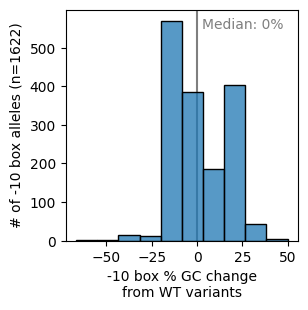

In [2174]:
_, ax = plt.subplots(figsize=(3, 3))

sns.histplot(all_gc_changes, ax=ax, bins=10)
ax.set_xlabel('-10 box % GC change\nfrom WT variants')
ax.set_xticks(range(-50, 75, 25))
med_gc_change = np.median(all_gc_changes)
ax.axvline(med_gc_change, color='tab:gray', zorder=-5)
ax.text(med_gc_change + 3, 550, f'Median: {med_gc_change:.0f}%', color='tab:gray')
ax.set_ylabel(f'# of -10 box alleles (n={len(all_gc_changes)})')

plt.savefig(Path(FIG_PATH, f'wt_Var_box10.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'wt_Var_box10.png'), dpi = 600, bbox_inches = 'tight')

### Sneak in General bp-view of variant enrichent

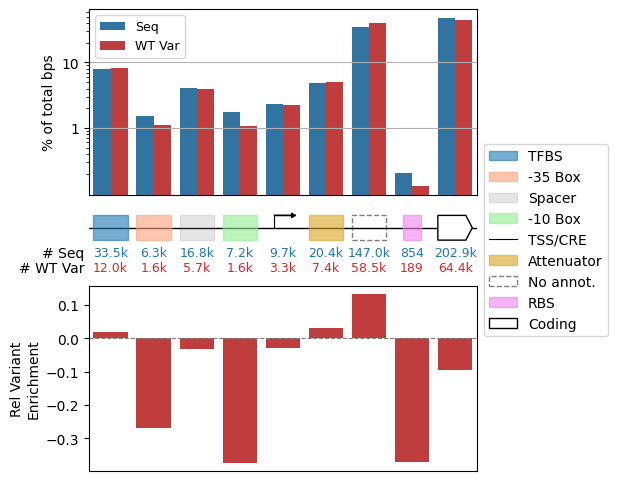

In [57]:
_, (ax, ax_diag, ax_diff) = plt.subplots(3, 1, figsize=(5, 6), sharex=True, height_ratios=[3, 1, 3])

ax.set_xticks(range(len(LEFT_TO_RIGHT)))
ax.set_xlim(-0.5, len(LEFT_TO_RIGHT))

sns.barplot(data=ale_v_nat_df, x='feat', y='pct', hue='group', ax=ax, palette=['tab:blue', 'tab:red'],
           hue_order=['Seq', 'WT Var'], order=LEFT_TO_RIGHT)
ax.set_ylabel('% of total bps')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yscale('log')
ax.set_yticks([1, 10])
ax.set_yticklabels([1, 10])
ax.legend(loc='upper left', fontsize=9)
ax.grid(axis='y')

plt.subplots_adjust(wspace=0, hspace=0.1)

ax_diag.axhline(0.7, linewidth=1, color='k', zorder=-10)
for s in ax_diag.spines.values():
    s.set_visible(False)
ax_diag.tick_params(axis='y', length=0)
ax_diag.set_ylim(0, 1)

for i, nice_name in enumerate(LEFT_TO_RIGHT):

    # do a big switch - this will make it easier to turn things on and off or re-shuffle later
    # gene is a bit cute shape
    if nice_name == 'Coding':
        gene_patch = plt_patches.Polygon(
            [[i - 0.4, 0.5], [i + 0.25, 0.5], [i + 0.4, 0.7], [i + 0.25, 0.9], [i - 0.4, 0.9]],
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(gene_patch)

    # make a little TSS arrow for the CRE
    elif nice_name == 'CRE':
        ax_diag.plot([i - 0.2, i - 0.2], [0.7, 0.9], color='k', lw=0.8, label='TSS/CRE')
        ax_diag.arrow(i - 0.2, 0.9, 0.5, 0, color='k', shape='full', width=0.01,
                      head_width=0.075, length_includes_head=True, head_length=0.1, lw=0.8)

    # RBS is a bit less wide
    elif nice_name == 'RBS':
        rbs_patch = plt_patches.Rectangle(
            (i - 0.2, 0.5), 0.4, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(rbs_patch)

    # these things are normal
    elif nice_name in ['Nothing', 'Atten', 'Term', '-10 Box', '-35 Box', 'Spacer', 'TFBS']:
        default_patch = plt_patches.Rectangle(
            (i - 0.4, 0.5), 0.8, 0.4,
            **nice_name_to_patch_kwargs[nice_name]
        )
        ax_diag.add_patch(default_patch)

ax_diag.legend(bbox_to_anchor=(1, 0.5), loc='center left')

for i, nice_name in enumerate(LEFT_TO_RIGHT):
    ale_v_nat_df_for_name = ale_v_nat_df[ale_v_nat_df['feat'] == nice_name]
    feat_to_counts = dict(zip(ale_v_nat_df_for_name['group'], ale_v_nat_df_for_name['count']))
    for spot, cat_name, col in zip([0.3, 0.05], ['Seq', 'WT Var'], ['tab:blue', 'tab:red']):
        raw_count = feat_to_counts[cat_name]
        if raw_count < 1000:
            format_txt = raw_count
        else:
            format_txt = f"{raw_count // 1000}.{(raw_count % 1000) // 100}k"
        ax_diag.text(i, spot, format_txt, fontsize=9, ha='center', va='center', color=col)
ax_diag.set_yticks([0.07, 0.32])
ax_diag.set_yticklabels([f'# {cat_name}' for cat_name in ['WT Var', 'Seq']])

seq_df = ale_v_nat_df[ale_v_nat_df['group'] == 'Seq'].sort_values(by='feat')
wt_diff_df =  ale_v_nat_df[ale_v_nat_df['group'] == 'WT Var'].sort_values(by='feat')
wt_diff_df = wt_diff_df.assign(
    diff_ratio=(wt_diff_df['pct'].values - seq_df['pct'].values) / seq_df['pct'].values
)

sns.barplot(data=wt_diff_df, x='feat', y='diff_ratio', ax=ax_diff, palette=['tab:red'], order=LEFT_TO_RIGHT)
ax_diff.set_ylabel('Rel Variant\nEnrichment', fontsize=10)
ax_diff.set_xlabel('')
ax_diff.set_xticks([])
ax_diff.axhline(0, linestyle='--', color='tab:gray', lw=0.8)

plt.savefig(Path(FIG_PATH, f'bitome_var_breakdown_bp_view.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, f'bitome_var_breakdown_bp_view.png'), dpi = 600, bbox_inches = 'tight')

### Rho vs Non-Rho Terminators

# 3' UTR Alleleome Analysis

## Load Aligned and Full Results

In [246]:
three_utr_dir = Path(MG_PANGENOME_BLAST_RESULT_DIR, '3utr')

feat_id_to_align_df_3utr = {}
feat_id_to_full_result_df_3utr = {}

for i, three_utr_align_file in enumerate(os.listdir(three_utr_dir)):
    
    if 'align' not in three_utr_align_file:
        continue
    
    print(f"{i+1}/{len(os.listdir(three_utr_dir))}", end='\r')
    
    feat_id = three_utr_align_file.split('.')[0].split('_align')[0]

    align_result_df = pd.read_csv(Path(three_utr_dir, three_utr_align_file), index_col=0)
    full_result_df = pd.read_csv(Path(three_utr_dir, three_utr_align_file.replace('_align', '')), index_col=0)
    
    feat_id_to_align_df_3utr[feat_id] = align_result_df
    feat_id_to_full_result_df_3utr[feat_id] = full_result_df

## Determine Widest 3' UTRs

# TODO

- profile untouched intergenic regions to demonstrate no notable conservation
- compare to Eddie's 
- ICA of alleles in single region?
Ideas from talk 1) equivalent of grantham score for noncoding - adding in the impact of the allele and how much motif info is at the annotated site to weight it
4:11
2) scoring a binding site or gene based on allele hits - maybe more variants are indicative of lack of importance of the site/gene
4:14
3) any workflow to figure out cases like fur or ihf?
4:15
And are those unique cases or does it vary from tf to tf with similar magnitude of effect
4:18
4) on ale -10 boxes, the -10 box isnt where dna opens during transcription its where the sigma factor binds, not that it doesnt join the tf bubble but just saying there are binding effects too
4:21
5) for aceb you didnt have an rbs but i wonder if with motif sweep and allelome depletion of variants you could find it